In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
from scipy.ndimage import binary_fill_holes, binary_opening, binary_closing
from sklearn.metrics import jaccard_score, accuracy_score
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import textwrap

# -------------------
# DATA CONFIG
# -------------------
data_pairs_18 = [
    {'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/raster_cb__normalized_predicted_raster.tif',
     'label': 'Chandra Bhaga basin'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/cb_vali_normalized_128_predicted_raster.tif',
     'label': 'Miyer Valley region'},
    {'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/NEW_UK_TIF_fixedB10_predicted_raster.tif',
     'label': 'Alaknanda and Bhagirathi basin'},
    {'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/KASHMIR_NORMALIZED_255_final_predicted_raster.tif',
     'label': 'Pangong Region'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/sikkim_chaudhary_255_final_predicted_raster.tif',
     'label': 'Chhombo Chhu Watershed'},
]

data_pairs_6 = [
    {'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/raster_cb__normalized_6band_predicted_raster.tif',
     'label': 'Chandra Bhaga basin'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/cb_vali_normalized_128_6band_predicted_raster.tif',
     'label': 'Miyer Valley region'},
    {'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/NEW_UK_TIF_fixedB10_6band_predicted_raster.tif',
     'label': 'Alaknanda and Bhagirathi basin'},
    {'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/KASHMIR_NORMALIZED_255_final_6band_predicted_raster.tif',
     'label': 'Pangong Region'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/sikkim_chaudhary_255_final_6band_predicted_raster.tif',
     'label': 'Chhombo Chhu Watershed'},
]

desired_order = [
    'Chandra Bhaga basin',
    'Pangong Region',
    'Chhombo Chhu Watershed',
    'Miyer Valley region',
    'Alaknanda and Bhagirathi basin',
]

# -------------------
# FUNCTIONS
# -------------------
def clean_pred_mask(pred, ref_mask):
    pred_filled = binary_fill_holes(pred > 0).astype(np.uint8)
    pred_clean = binary_opening(pred_filled, structure=np.ones((3, 3))).astype(np.uint8)
    pred_clean = binary_closing(pred_clean, structure=np.ones((3, 3))).astype(np.uint8)
    return np.where(ref_mask > 0, pred_clean, 0).astype(np.uint8)

def load_and_resample(mask_path, pred_path):
    with rasterio.open(mask_path) as src:
        mask = src.read(1).astype(np.uint8)
        profile = src.profile
        transform = src.transform
        crs = src.crs
    with rasterio.open(pred_path) as src_pred:
        resampled_pred = np.empty_like(mask, dtype=np.uint8)
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_pred,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=profile['transform'],
            dst_crs=profile['crs'],
            resampling=Resampling.nearest
        )
    return mask, clean_pred_mask(resampled_pred, mask), transform, crs

def make_diff_map_no_fp(gt, pred):
    diff = np.zeros_like(gt, dtype=np.uint8)
    diff[(gt == 1) & (pred == 1)] = 1  # TP
    diff[(gt == 1) & (pred == 0)] = 3  # FN
    return diff

def compute_metrics(y_true, y_pred):
    return accuracy_score(y_true, y_pred), jaccard_score(y_true, y_pred, average="binary")

def extent_from_transform(transform, width, height, make_square=False):
    left, top = transform * (0, 0)
    right, bottom = transform * (width, height)
    if not make_square:
        return [left, right, bottom, top]
    px_w, px_h = transform.a, abs(transform.e)
    max_side = max(width * px_w, height * px_h)
    return [left, left + max_side, top - max_side, top]

# -------------------
# PLOT CONFIG
# -------------------
diff_cmap = ListedColormap(["white", "green", "white", "blue"])
legend_elements = [
    Patch(facecolor="green", edgecolor="black", label="Matched (TP)"),
    Patch(facecolor="blue", edgecolor="black", label="Mismatched (FN)")
]
col_titles = ["Original Mask", "Visualization (18)", "Visualization (6)"]

# -------------------
# PROCESS DATA
# -------------------
pairs18_by_label = {p['label']: p for p in data_pairs_18}
pairs6_by_label = {p['label']: p for p in data_pairs_6}
ordered_labels = [lab for lab in desired_order if lab in pairs18_by_label and lab in pairs6_by_label]

originals, diffs_18, diffs_6, metrics_18, metrics_6, transforms = [], [], [], [], [], []

for label in ordered_labels:
    mask, pred18, transform, _ = load_and_resample(pairs18_by_label[label]['mask'], pairs18_by_label[label]['predicted'])
    _, pred6, _, _ = load_and_resample(pairs6_by_label[label]['mask'], pairs6_by_label[label]['predicted'])
    originals.append(mask)
    transforms.append(transform)
    diffs_18.append(make_diff_map_no_fp(mask, pred18))
    diffs_6.append(make_diff_map_no_fp(mask, pred6))
    metrics_18.append(compute_metrics(mask.flatten(), pred18.flatten()))
    metrics_6.append(compute_metrics(mask.flatten(), pred6.flatten()))

# -------------------
# PLOT FIGURE
# -------------------
n_basins = len(ordered_labels)
fig, axes = plt.subplots(n_basins, 3, figsize=(14, 3.5 * n_basins), subplot_kw={'aspect': 'equal'})

plt.tight_layout(rect=[0, 0.06, 1, 0.95])

# Column headings above first row
for j, title in enumerate(col_titles):
    ax_pos = axes[0, j].get_position()
    heading_y = ax_pos.y1 + 0.01
    fig.text(ax_pos.x0 + ax_pos.width / 2, heading_y,
             title,
             ha="center", va="bottom",
             fontsize=12, weight="bold",
             bbox=dict(facecolor="white", edgecolor="black"))

# Plot subplots
for i, (label, orig, d18, d6, tr, m18, m6) in enumerate(zip(
        ordered_labels, originals, diffs_18, diffs_6, transforms, metrics_18, metrics_6)):

    acc18, iou18 = m18
    acc6, iou6 = m6
    h, w = orig.shape
    extent = extent_from_transform(tr, w, h, make_square=("Miyer Valley region" in label))

    lon_ticks = np.round(np.linspace(extent[0], extent[1], 3), 2)
    lat_ticks = np.round(np.linspace(extent[2], extent[3], 3), 2)

    # Col 1
    axes[i, 0].imshow(orig, cmap="gray", extent=extent)
    axes[i, 0].set_xticks(lon_ticks)
    axes[i, 0].set_yticks(lat_ticks)
    axes[i, 0].set_xlabel("Longitude")
    axes[i, 0].set_ylabel("Latitude")

    # Col 2
    axes[i, 1].imshow(d18, cmap=diff_cmap, vmin=0, vmax=3, extent=extent)
    axes[i, 1].set_xticks(lon_ticks)
    axes[i, 1].set_yticks(lat_ticks)
    for spine in axes[i, 1].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    axes[i, 1].text(0.98, 0.98, f"Acc={acc18:.3f}\nIoU={iou18:.3f}",
                    transform=axes[i, 1].transAxes, fontsize=12,
                    va="top", ha="right",
                    bbox=dict(facecolor="white", alpha=0.8, edgecolor='black'))

    # Col 3
    axes[i, 2].imshow(d6, cmap=diff_cmap, vmin=0, vmax=3, extent=extent)
    axes[i, 2].set_xticks(lon_ticks)
    axes[i, 2].set_yticks(lat_ticks)
    for spine in axes[i, 2].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    axes[i, 2].text(0.98, 0.98, f"Acc={acc6:.3f}\nIoU={iou6:.3f}",
                    transform=axes[i, 2].transAxes, fontsize=12,
                    va="top", ha="right",
                    bbox=dict(facecolor="white", alpha=0.8, edgecolor='black'))

# Legend just below last row
last_row_pos = axes[-1, 0].get_position()
legend_y = last_row_pos.y0 - 0.05
fig.legend(handles=legend_elements,
           loc="lower center",
           bbox_to_anchor=(0.5, legend_y),
           ncol=2, fontsize=12, frameon=True)

out_path = "sarvesh/mlandsnet_sato_new/figures_tp_tf/m_landsnet_compare.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.close(fig)

print(f"\n✅ Saved figure at {out_path}")

In [1]:
import os
import numpy as np
import rasterio
from rasterio.transform import Affine
from concurrent.futures import ThreadPoolExecutor
from scipy.ndimage import rotate as nd_rotate

# ============================
# INPUT
# ============================
raster_mask_pairs = [
    ("sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif", "sarvesh/chandrabasin/cb_dataset/dataset-9999-limit/cb_glacier_raster.tif"),
    ("sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif", "sarvesh/sato_new/glacier_mask_binary.tif"),
    ("sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif", "sarvesh/DATASETS_NORMALIZED/vectors/KASHMIR_CLIP.tif"),
    ("sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif", "sarvesh/DATASETS_NORMALIZED/vectors/sikkim_clip_mask.tif"),
]

output_raster_dir = "sarvesh/mlandsnet_sato_new/rasterlayer"
output_mask_dir   = "sarvesh/mlandsnet_sato_new/vectorlayer"
patch_size = 128

# ============================
# Directory Preparation
# ============================
def clear_and_create_dir(path):
    if os.path.exists(path):
        for f in os.listdir(path):
            os.remove(os.path.join(path, f))
    else:
        os.makedirs(path)

clear_and_create_dir(output_raster_dir)
clear_and_create_dir(output_mask_dir)

# ============================
# Augmentations
# ============================
def horizontal_flip(p): return np.flip(p, axis=2)
def vertical_flip(p): return np.flip(p, axis=1)
def mirror_flip(p): return np.transpose(p, (0, 2, 1))  # diagonal flip

def rotate_90(p): return np.rot90(p, k=1, axes=(1, 2))
def rotate_180(p): return np.rot90(p, k=2, axes=(1, 2))
def rotate_270(p): return np.rot90(p, k=3, axes=(1, 2))

# Extra rotations (scipy)
def rotate_any(p, angle, order=1):
    return np.stack([
        nd_rotate(band, angle=angle, axes=(0, 1), reshape=False, order=order, mode="nearest") 
        for band in p
    ], axis=0)

def apply_augmentations(data, mask_data):
    augments = [("original", data, mask_data)]
    
    # flips & 90° rotations
    for name, func in [
        ("hflip", horizontal_flip),
        ("vflip", vertical_flip),
        ("mirror", mirror_flip),
        ("rot90", rotate_90),
        ("rot180", rotate_180),
        ("rot270", rotate_270)]:
        augments.append((name, func(data), func(mask_data)))
    
    # extra arbitrary rotations (mask nearest-neighbor safe)
    for angle in [45, 135, 225]:
        d_rot = rotate_any(data, angle, order=1)
        m_rot = rotate_any(mask_data, angle, order=0)
        augments.append((f"rot{angle}", d_rot, m_rot))
    
    return augments

# ============================
# Patch Check + Save
# ============================
def is_empty_patch(mask_patch):
    return np.all(mask_patch == 0)

def get_patch_transform(transform, i, j, patch_size):
    # Shift original transform by patch offset (j cols, i rows)
    return transform * Affine.translation(j, i)

def save_patch(data, output_dir, prefix, i, j, transform, crs, aug_name):
    filename = os.path.join(output_dir, f"{prefix}_patch_{i}_{j}_{aug_name}.tif")
    height, width = data.shape[1], data.shape[2]
    count = data.shape[0]
    patch_transform = get_patch_transform(transform, i, j, patch_size)

    with rasterio.open(
        filename, 'w', driver='GTiff',
        height=height, width=width,
        count=count, dtype=data.dtype,
        crs=crs, transform=patch_transform
    ) as dst:
        dst.write(data)

# ============================
# Main Processing
# ============================
def process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size):
    with rasterio.open(raster_path) as raster_src, rasterio.open(mask_path) as mask_src:
        raster = raster_src.read()  # (bands, h, w)
        mask = mask_src.read()      # (1, h, w) or (bands, h, w)
        crs = raster_src.crs
        transform = raster_src.transform

        # If mask is single band, enforce (1, h, w)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=0)

        h, w = raster.shape[1], raster.shape[2]
        jobs = []

        for i in range(0, h - patch_size + 1, patch_size):
            for j in range(0, w - patch_size + 1, patch_size):
                r_patch = raster[:, i:i+patch_size, j:j+patch_size]
                m_patch = mask[:, i:i+patch_size, j:j+patch_size]

                if r_patch.shape[1:] != (patch_size, patch_size):
                    continue
                if m_patch.shape[1:] != (patch_size, patch_size):
                    continue
                if is_empty_patch(m_patch):
                    continue

                for aug_name, aug_r, aug_m in apply_augmentations(r_patch, m_patch):
                    jobs.append((aug_r, output_raster_dir, 'raster', i, j, transform, crs, aug_name))
                    jobs.append((aug_m, output_mask_dir, 'mask', i, j, transform, crs, aug_name))

        # Save patches in parallel
        with ThreadPoolExecutor() as executor:
            for job in jobs:
                executor.submit(save_patch, *job)

# ============================
# Run All
# ============================
for raster_path, mask_path in raster_mask_pairs:
    print(f"Processing: {raster_path}")
    process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size)

# ============================
# Summary
# ============================
patch_count = len([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
print(f"Total {patch_size}x{patch_size} patches generated (with augmentations): {patch_count}")

Processing: sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif
Processing: sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif
Processing: sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif
Processing: sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif
Total 128x128 patches generated (with augmentations): 23060


Number of bands in raster: 18


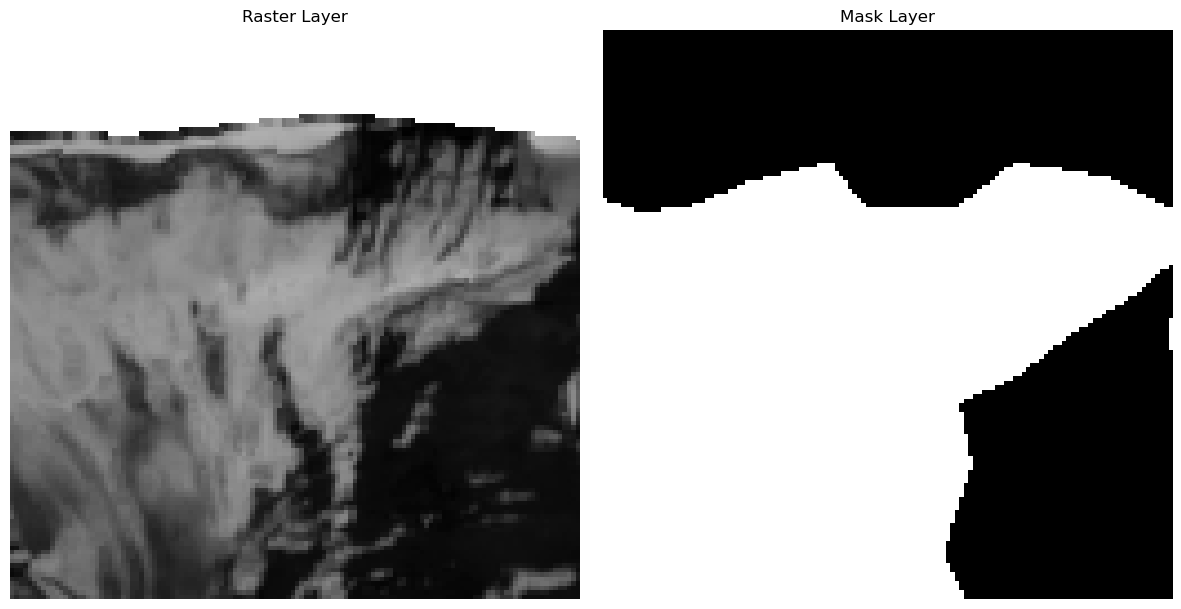

Number of bands in raster: 18


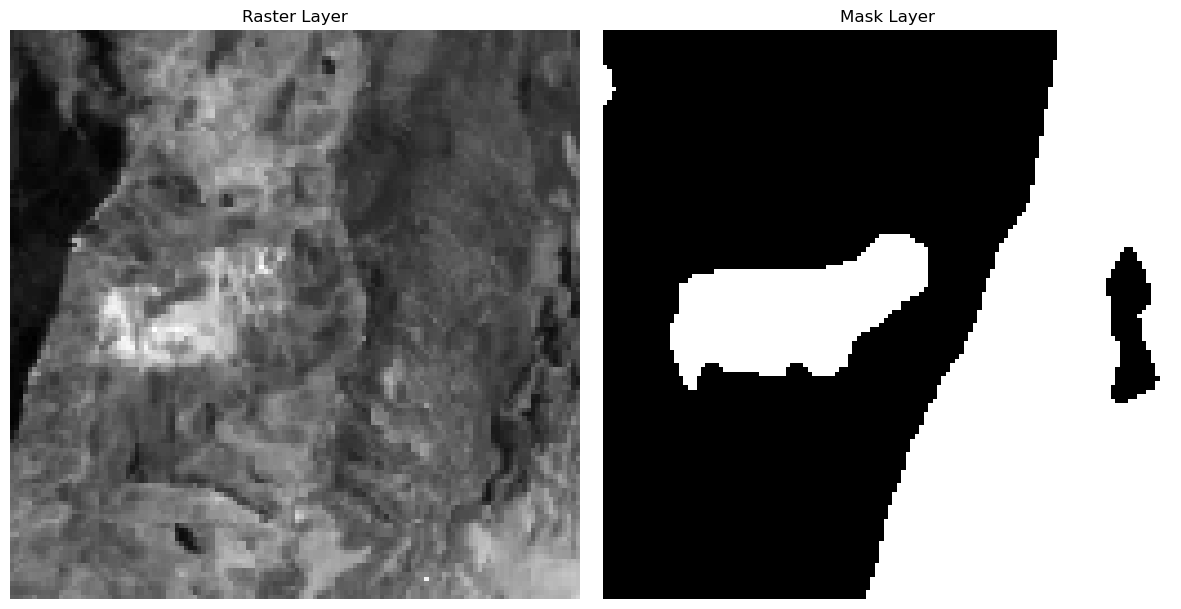

Number of bands in raster: 18


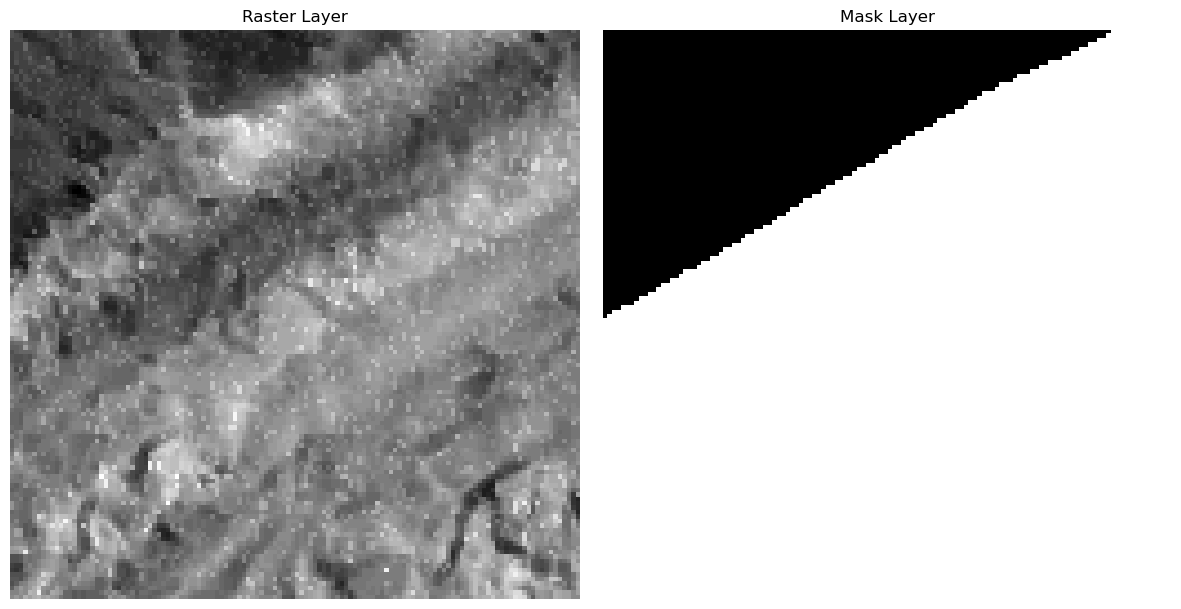

Number of bands in raster: 18


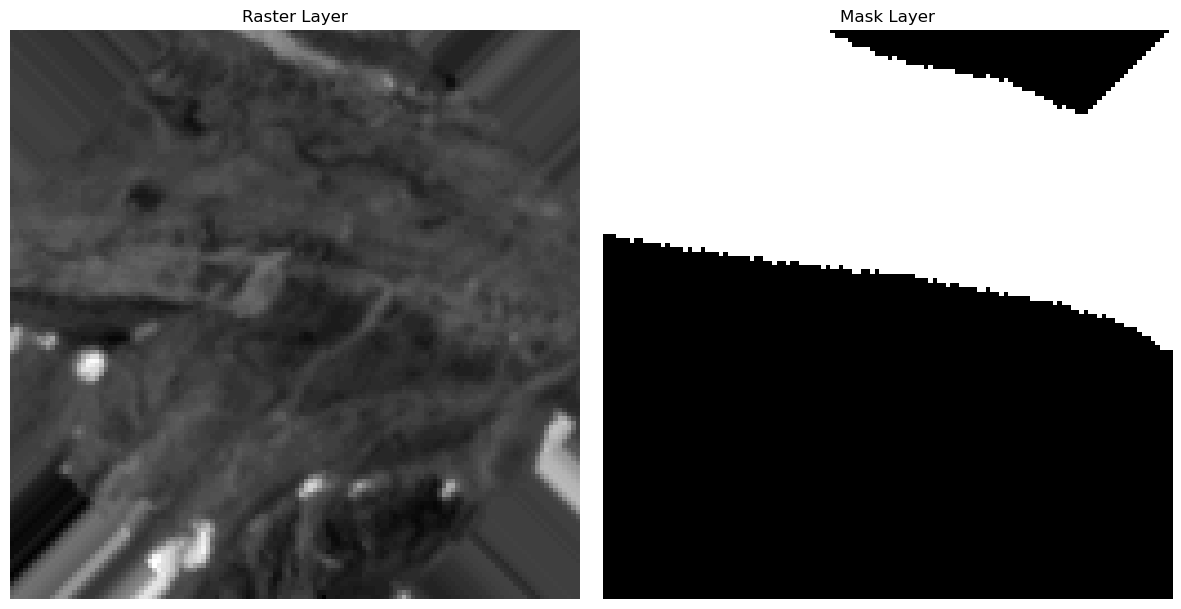

In [2]:
import os
import random
import rasterio
import matplotlib.pyplot as plt

# Output directories
output_raster_dir = "sarvesh/mlandsnet_sato_new/rasterlayer"
output_mask_dir   = "sarvesh/mlandsnet_sato_new/vectorlayer"
patch_size = 128

# Get a list of patch files
raster_files = sorted([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(output_mask_dir) if f.endswith('.tif')])

# Randomly select 4 unique indices
if len(raster_files) >= 4 and len(mask_files) >= 4:
    random_indices = random.sample(range(len(raster_files)), 4)
else:
    print("Not enough raster or mask files available.")
    random_indices = []

# Visualization function for raster and mask
def visualize_layers(raster_file, mask_file):
    with rasterio.open(raster_file) as src_raster:
        # Check the number of bands in the raster
        num_bands = src_raster.count
        print(f"Number of bands in raster: {num_bands}")  # Debugging line

        # Select the first band (ensure it's the correct band)
        raster_data = src_raster.read(1)  # Change this if you want a different band

    with rasterio.open(mask_file) as src_mask:
        mask_data = src_mask.read(1)  # Read the first band (or layer)

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot raster
    ax[0].imshow(raster_data, cmap='gray')
    ax[0].set_title('Raster Layer')
    ax[0].axis('off')  # Hide axis

    # Plot mask
    ax[1].imshow(mask_data, cmap='gray')
    ax[1].set_title('Mask Layer')
    ax[1].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Visualize the selected random patches
for index in random_indices:
    visualize_layers(os.path.join(output_raster_dir, raster_files[index]),
                     os.path.join(output_mask_dir, mask_files[index]))

In [2]:
import os
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from osgeo import gdal
import random
import tensorflow as tf
from matplotlib import pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import rasterio
from rasterio.windows import Window

In [3]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
import os
import rasterio
import numpy as np

output_raster_dir = "sarvesh/mlandsnet_sato_new/rasterlayer"
output_mask_dir   = "sarvesh/mlandsnet_sato_new/vectorlayer"

# Function to check if a file is a valid raster
def is_valid_raster(file_path):
    try:
        with rasterio.open(file_path) as src:
            return True
    except:
        return False

# Function to load patches and calculate metrics
def load_and_calculate_metrics(raster_dir, mask_dir):
    raster_files = sorted([f for f in os.listdir(raster_dir) if is_valid_raster(os.path.join(raster_dir, f))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if is_valid_raster(os.path.join(mask_dir, f))])

    if not raster_files or not mask_files:
        print("No valid raster or mask files found.")
        return

    # Load first raster file to extract dimensions
    with rasterio.open(os.path.join(raster_dir, raster_files[0])) as src:
        raster_height = src.height
        raster_width = src.width
        raster_channels = src.count

    # Count the number of patches
    raster_length = len(raster_files)
    mask_length = len(mask_files)

    # Check for the total classes in the mask
    mask_classes = set()

    for mask_file in mask_files:
        with rasterio.open(os.path.join(mask_dir, mask_file)) as mask_src:
            mask_data = mask_src.read(1)  # Read the first band
            mask_classes.update(np.unique(mask_data))

    # Print the calculated metrics
    print("Length of raster dataset:", raster_length)
    print("Length of mask dataset:", mask_length)
    print("Raster height:", raster_height)
    print("Raster width:", raster_width)
    print("Raster channels:", raster_channels)
    print("Total classes of mask (1 for glacier, 0 for non-glacier):", sorted(mask_classes))

# Call the function to load datasets and calculate metrics
load_and_calculate_metrics(output_raster_dir, output_mask_dir)

Length of raster dataset: 23060
Length of mask dataset: 23060
Raster height: 128
Raster width: 128
Raster channels: 18
Total classes of mask (1 for glacier, 0 for non-glacier): [0, 1]


In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [7]:
import os
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Define paths
output_raster_dir = "sarvesh/mlandsnet_sato_new/rasterlayer"
output_mask_dir   = "sarvesh/mlandsnet_sato_new/vectorlayer"

# Function to load raster dataset
def load_raster_dataset(directory):
    image_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                image_data = src.read()  # (channels, height, width)
                image_list.append(image_data)
    return np.stack(image_list, axis=0) if image_list else np.array([])

# Function to load mask dataset
def load_mask_dataset(directory):
    mask_list = []
    mask_files = sorted([f for f in os.listdir(directory) if f.endswith('.tif')])
    for filename in mask_files:
        file_path = os.path.join(directory, filename)
        with rasterio.open(file_path) as src:
            mask_data = src.read(1)  # (height, width) single band
            mask_list.append(mask_data)
    return np.array(mask_list)

# Load raster data
image_dataset = load_raster_dataset(output_raster_dir)
print("Original image dataset shape:", image_dataset.shape)

# Transpose image data to (n_samples, height, width, channels)
if image_dataset.ndim == 4:
    image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))  # from (N, C, H, W) to (N, H, W, C)
    print("Transposed image dataset shape:", image_dataset.shape)
else:
    print("Warning: Unexpected image dataset shape.")

# Extract dimensions
if image_dataset.size > 0:
    image_height, image_width, image_channels = image_dataset.shape[1:]
    print("Image height:", image_height)
    print("Image width:", image_width)
    print("Image channels:", image_channels)
else:
    print("Error: Empty image dataset!")

# Load mask data
mask_dataset = load_mask_dataset(output_mask_dir)
print("Mask dataset shape:", mask_dataset.shape)
print("Length of mask dataset:", len(mask_dataset))

# Unique classes in the masks
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
print("Unique labels in masks:", unique_labels)
print("Total number of unique classes:", total_classes)

# One-hot encode the masks
labels_categorical_dataset = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
if image_dataset.shape[0] == labels_categorical_dataset.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(
        image_dataset,
        labels_categorical_dataset,
        test_size=0.2,
        random_state=100
    )

    print("Dataset split completed.")
    print("Training set shape (X, y):", X_train.shape, y_train.shape)
    print("Testing set shape (X, y):", X_test.shape, y_test.shape)
else:
    print("Mismatch in number of images and masks!")

Original image dataset shape: (23060, 18, 128, 128)
Transposed image dataset shape: (23060, 128, 128, 18)
Image height: 128
Image width: 128
Image channels: 18
Mask dataset shape: (23060, 128, 128)
Length of mask dataset: 23060
Unique labels in masks: [0. 1.]
Total number of unique classes: 2
Dataset split completed.
Training set shape (X, y): (18448, 128, 128, 18) (18448, 128, 128, 2)
Testing set shape (X, y): (4612, 128, 128, 18) (4612, 128, 128, 2)


In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(18448, 128, 128, 18)
(4612, 128, 128, 18)
(18448, 128, 128, 2)
(4612, 128, 128, 2)


In [5]:
from keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [6]:
import os
import numpy as np
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, Add, Activation, Multiply, GlobalAveragePooling2D, DepthwiseConv2D, Reshape, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2

In [8]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

In [9]:
# Clear the session to free memory
from keras import backend as K
K.clear_session()

In [14]:
output_raster_dir = "sarvesh/mlandsnet_sato_new/rasterlayer"
output_mask_dir   = "sarvesh/mlandsnet_sato_new/vectorlayer"
patch_size = 128  # Ensure your patches match your input shape

# Function to load raster dataset
def load_raster_dataset(directory):
    image_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                image_data = src.read()
                image_list.append(image_data)
    return np.stack(image_list, axis=0) if image_list else np.array([])

In [15]:
# Function to load mask dataset
def load_mask_dataset(directory):
    mask_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                mask_data = src.read(1)
                mask_list.append(mask_data)
    return np.stack(mask_list, axis=0) if mask_list else np.array([])

# Load datasets
image_dataset = load_raster_dataset(output_raster_dir)
mask_dataset = load_mask_dataset(output_mask_dir)

# Transpose image dataset to have channels last
image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))

# Normalize image data
#image_dataset = image_dataset.astype('float32') / 255.0

# Convert mask to categorical
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
mask_dataset_cat = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, mask_dataset_cat, test_size=0.9, random_state=100
)

In [16]:
# Define Jaccard Coefficient for metric
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

# Define residual block (ResBlock)
def res_block(x, filters, kernel_size=3, strides=1, dilation_rate=1):
    res = Conv2D(filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate)(x)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)
    res = Conv2D(filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate)(res)
    res = BatchNormalization()(res)

    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    res = Add()([res, shortcut])
    res = Activation('relu')(res)
    return res

# Define attention gate
def attention_gate(x, g, filters):
    theta_x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(filters, kernel_size=1, strides=1, padding='same')(g)
    concat = Add()([theta_x, phi_g])
    act = Activation('relu')(concat)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(act)
    sigmoid = Activation('sigmoid')(psi)
    attention = Multiply()([x, sigmoid])
    return attention

# Define M-LandsNet model
def m_landsnet(n_classes=1, image_height=128, image_width=128, image_channels=1):
    inputs = Input((image_height, image_width, image_channels))

    # Step 1: Contracting path with ResBlocks
    c1 = res_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = res_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = res_block(p2, 64)
    p3 = MaxPooling2D((2, 2))(c3)

    # Step 2: Multiscale fusion with dilated convolutions
    m1 = Conv2D(128, (3, 3), padding='same', dilation_rate=1)(p3)
    m2 = Conv2D(128, (3, 3), padding='same', dilation_rate=2)(p3)
    m3 = Conv2D(128, (3, 3), padding='same', dilation_rate=3)(p3)

    fused = Add()([m1, m2])
    fused = Conv2D(128, (1, 1), padding='same')(fused)
    fused = Add()([fused, m3])
    fused = Conv2D(128, (1, 1), padding='same')(fused)

    # Step 3: Expansive path with upsampling, concatenation, and ResBlocks
    u6 = UpSampling2D((2, 2))(fused)
    a6 = attention_gate(c3, u6, 64)
    u6 = concatenate([u6, a6])
    c6 = res_block(u6, 64)

    u7 = UpSampling2D((2, 2))(c6)
    a7 = attention_gate(c2, u7, 32)
    u7 = concatenate([u7, a7])
    c7 = res_block(u7, 32)

    u8 = UpSampling2D((2, 2))(c7)
    a8 = attention_gate(c1, u8, 16)
    u8 = concatenate([u8, a8])
    c8 = res_block(u8, 16)

    # Step 4: Final convolution and softmax activation
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [17]:
# Compile model
model = m_landsnet(n_classes=total_classes,
                       image_height=X_train.shape[1],
                       image_width=X_train.shape[2],
                       image_channels=X_train.shape[3])

dice_loss = sm.losses.DiceLoss(class_weights=[0.3, 0.7])
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(optimizer=Adam(), loss=total_loss, metrics=["accuracy", jaccard_coef])

2025-09-02 15:48:57.024406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13537 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:a1:00.0, compute capability: 8.6


In [18]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Enable mixed precision for faster GPU computation
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Path to save the model
model_save_path = 'sarvesh/mlandsnet_sato_new/model_18/m_landsnet_newsato_all_area.h5'

#Increased Learning Rate for Faster Training
learning_rate = 1e-3  

#Use Adam Optimizer with New Learning Rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A4000, compute capability 8.6


In [19]:
# Model checkpoint callback (save the best model)
model_checkpoint = ModelCheckpoint(
    model_save_path, 
    save_best_only=True,  
    monitor='val_loss',   
    mode='min',           
    verbose=1            
)

# Increase batch size to fully utilize GPU
batch_size = 16

# Train the model with mixed precision and improved performance
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=1000,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/1000


2025-09-02 15:49:06.592284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-09-02 15:49:06.908900: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-09-02 15:49:07.398765: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-09-02 15:49:09.077758: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7eb624855160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-02 15:49:09.077819: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-09-02 15:49:09.089231: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-02 15:49:09.270409: I ./tensorflow/compiler/jit/device_compiler.h:

145/145 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.8673

2025-09-02 15:49:43.257478: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6120603648 exceeds 10% of free system memory.
2025-09-02 15:49:48.679536: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2720268288 exceeds 10% of free system memory.
2025-09-02 15:49:50.886173: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6120603648 exceeds 10% of free system memory.
2025-09-02 15:49:54.832203: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2720268288 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.75244, saving model to sarvesh/mlandsnet_sato_new/model_18/m_landsnet_newsato_all_area.h5
145/145 [==============================] - 75s 366ms/step - loss: 0.3060 - accuracy: 0.8673 - val_loss: 0.7524 - val_accuracy: 0.7436
Epoch 2/1000


/home/sarvesh/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/145 [============================>.] - ETA: 0s - loss: 0.2650 - accuracy: 0.8866
Epoch 2: val_loss improved from 0.75244 to 0.30985, saving model to sarvesh/mlandsnet_sato_new/model_18/m_landsnet_newsato_all_area.h5
145/145 [==============================] - 24s 169ms/step - loss: 0.2654 - accuracy: 0.8864 - val_loss: 0.3099 - val_accuracy: 0.8684
Epoch 3/1000
144/145 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8865
Epoch 3: val_loss did not improve from 0.30985
145/145 [==============================] - 24s 167ms/step - loss: 0.2639 - accuracy: 0.8865 - val_loss: 0.3475 - val_accuracy: 0.8762
Epoch 4/1000
145/145 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.8893
Epoch 4: val_loss improved from 0.30985 to 0.25382, saving model to sarvesh/mlandsnet_sato_new/model_18/m_landsnet_newsato_all_area.h5
145/145 [==============================] - 25s 171ms/step - loss: 0.2561 - accuracy: 0.8893 - val_loss: 0.2538 - val_accuracy: 0.8974


In [20]:
tf.keras.backend.clear_session()

In [21]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output.shape)

X_train shape: (2306, 128, 128, 18)
y_train shape: (2306, 128, 128, 2)
Model output shape: (None, 128, 128, 2)


In [22]:
# Check model output shape at different stages
print("Model output shape:", model.output.shape)

# Check the shape of y_train
print("Training labels shape:", y_train.shape)

Model output shape: (None, 128, 128, 2)
Training labels shape: (2306, 128, 128, 2)


Text(0.5, 1.0, 'Model Accuracy')

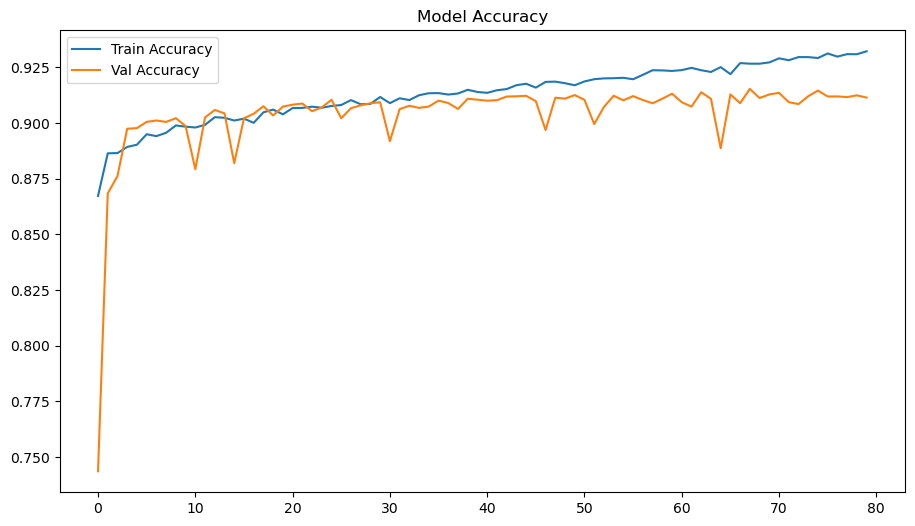

In [23]:
# Plot training results
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

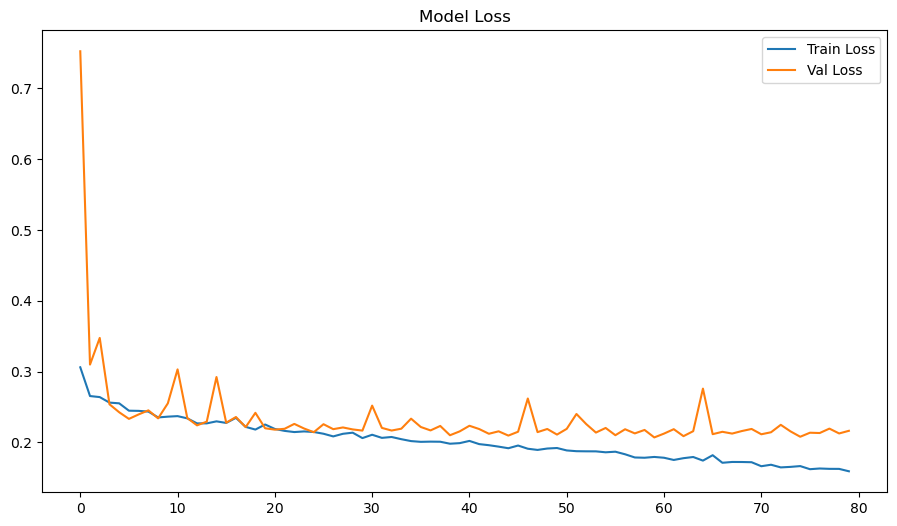

In [24]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [25]:
#Predict on the test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

2025-09-02 16:23:25.137636: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6120603648 exceeds 10% of free system memory.
2025-09-02 16:23:38.920365: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.70GiB (rounded to 6120603648)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-09-02 16:23:38.920477: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-09-02 16:23:38.920500: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 301, Chunks in use: 297. 75.2KiB allocated for chunks. 74.2KiB in use in bin. 33.5KiB client-requested in use in bin.
2025-09-02 16:23:38.920520: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 16, Chunks in use: 15.

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [26]:
# Convert y_test to argmax for comparison
y_test_argmax = np.argmax(y_test, axis=3)

In [27]:
# Select a random test image for prediction visualization
test_image_number = random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

1/1 [==============================] - 0s 44ms/step


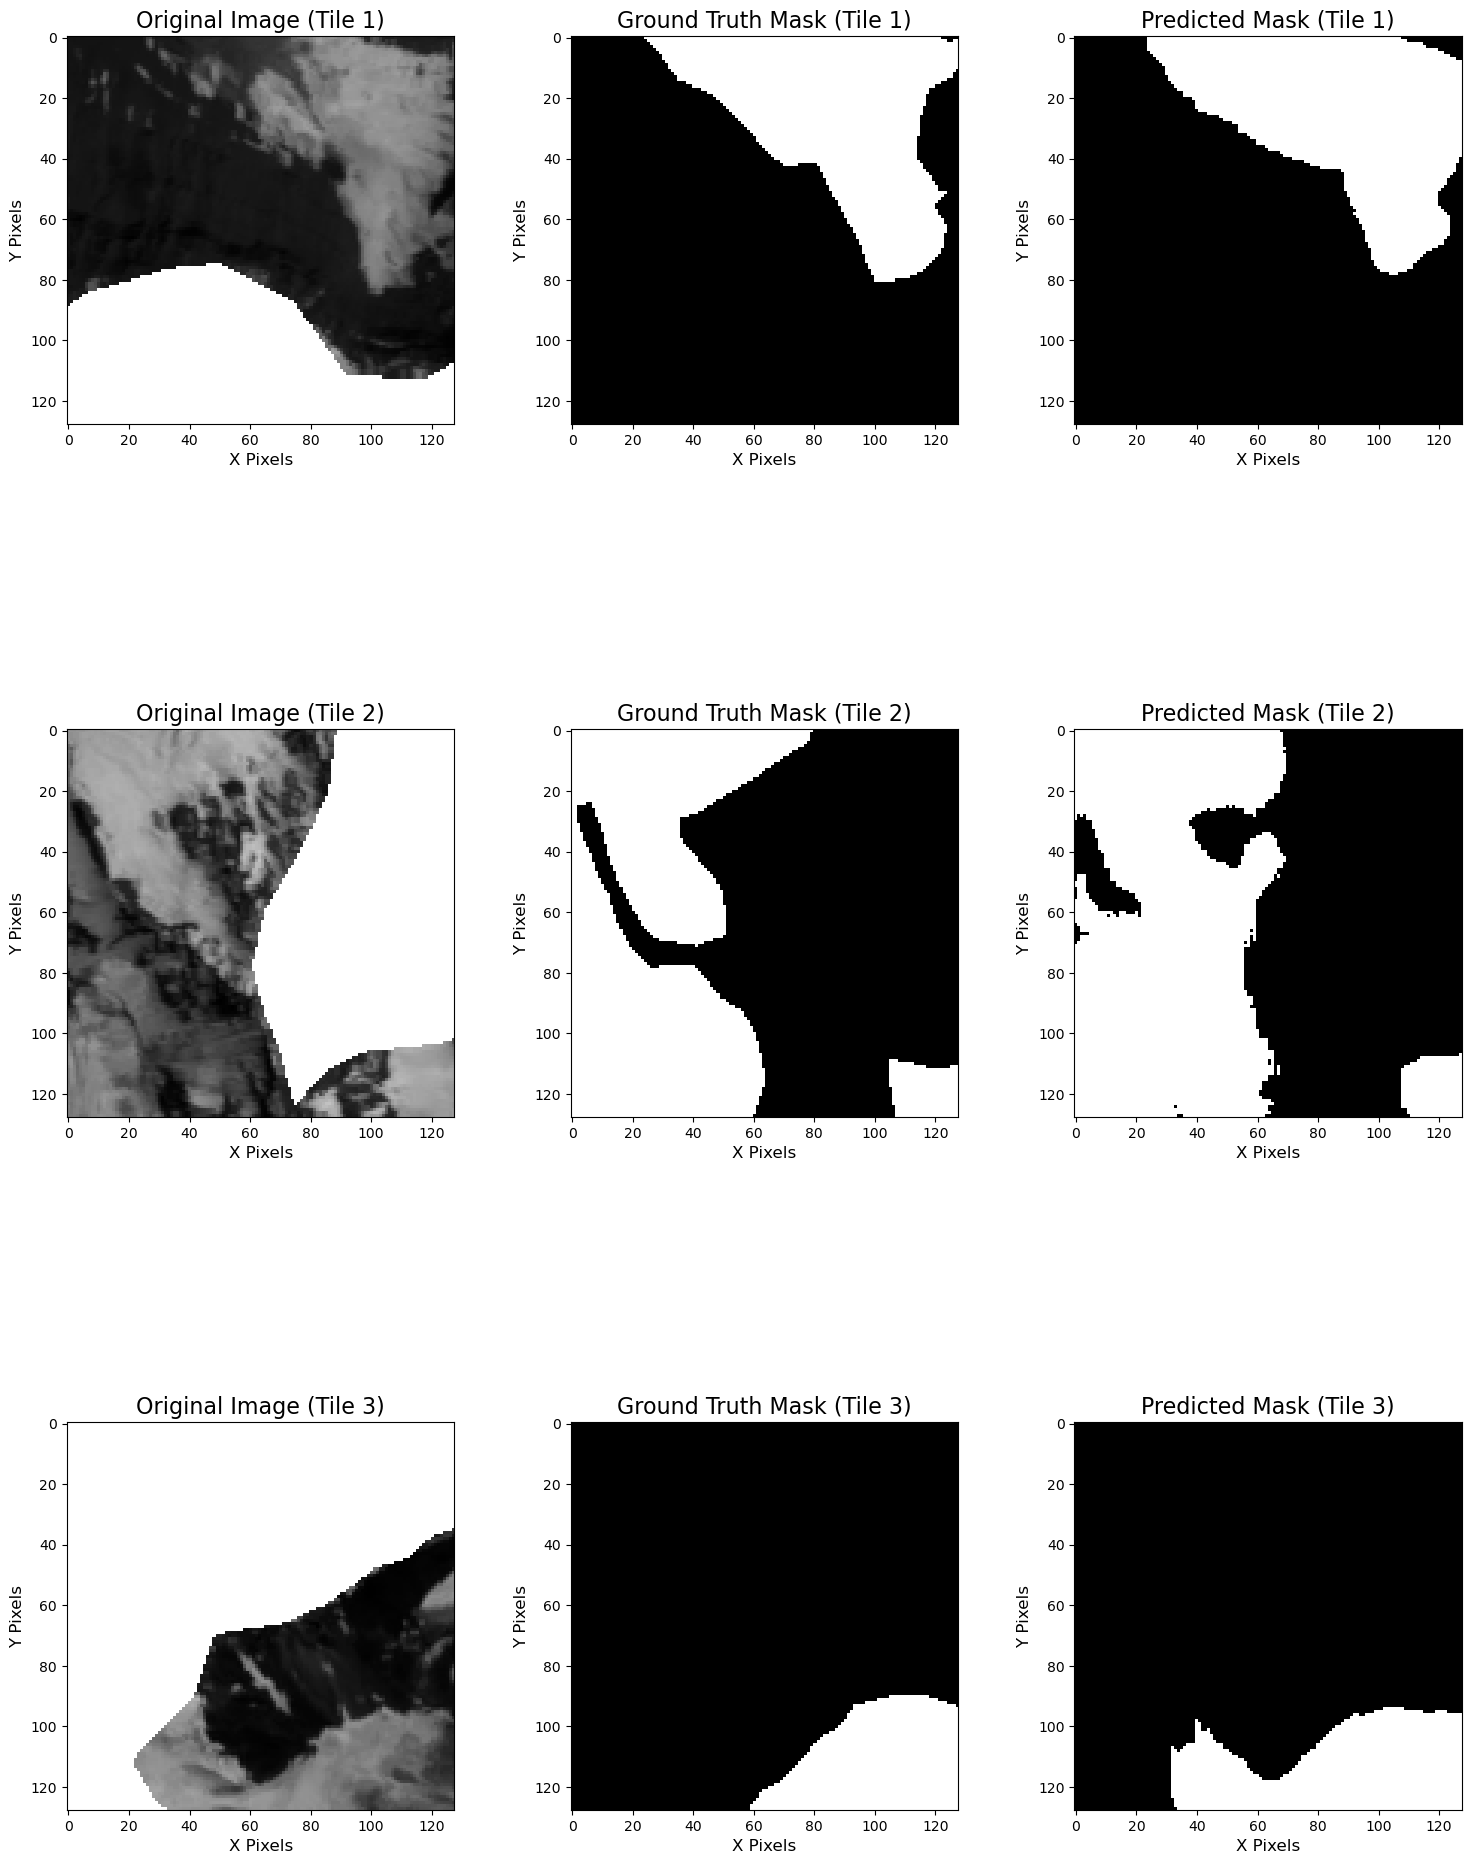

In [28]:
# Define the figure size and the spacing between subplots
plt.figure(figsize=(18, 24))  # Adjusted size for three rows
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Increased spacing between plots and rows

# Loop through the first three tiles in the test set
for i in range(3):
    test_image = X_test[i]
    ground_truth_image = np.argmax(y_test[i], axis=-1)  # Decategorize the mask
    predicted_mask = model.predict(np.expand_dims(test_image, axis=0))
    predicted_image = np.argmax(predicted_mask[0], axis=-1)  # Decategorize predicted mask

    # Original Image
    plt.subplot(3, 3, i * 3 + 1)
    plt.title(f"Original Image (Tile {i+1})", fontsize=16)
    plt.imshow(test_image[..., 0], cmap='gray')  # Show first channel only
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Ground Truth Mask
    plt.subplot(3, 3, i * 3 + 2)
    plt.title(f"Ground Truth Mask (Tile {i+1})", fontsize=16)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Predicted Mask
    plt.subplot(3, 3, i * 3 + 3)
    plt.title(f"Predicted Mask (Tile {i+1})", fontsize=16)
    plt.imshow(predicted_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

# Show the plot
plt.show()

In [29]:
from tensorflow.keras.models import load_model

# Path to your trained model
model_path = 'sarvesh/mlandsnet_sato_new/model_18/m_landsnet_newsato_all_area.h5'

# Load the model (no custom objects used)
model = load_model(model_path, compile=False)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 18)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         2608      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [30]:
import tensorflow as tf
from tensorflow import keras

# Define the custom loss functions
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = tf.exp(-bce)
    focal = alpha * (1 - bce_exp) ** gamma * bce
    return tf.keras.backend.mean(focal)

def dice_loss_plus_1focal_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

# Define the custom metric function
def jaccard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)  # Adding 1 for numerical stability

# Load the model with the custom loss and metric function
model_path = 'sarvesh/mlandsnet_sato_new/model_18/m_landsnet_newsato_all_area.h5'
model = keras.models.load_model(model_path, custom_objects={
    'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss,
    'jaccard_coef': jaccard_coef
})

print("Model loaded successfully!")

Model loaded successfully!


In [31]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import LossScaleOptimizer

# Define a new optimizer
learning_rate = 1e-3
optimizer = LossScaleOptimizer(Adam(learning_rate=learning_rate))

# Recompile the model
model.compile(optimizer=optimizer, loss=dice_loss_plus_1focal_loss, metrics=[jaccard_coef])

print("Model recompiled successfully!")

Model recompiled successfully!


In [34]:
import os
import numpy as np
import rasterio
from rasterio.features import shapes
import fiona
from shapely.geometry import shape, mapping
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define custom loss and metric functions
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = tf.exp(-bce)
    focal = alpha * (1 - bce_exp) ** gamma * bce
    return tf.keras.backend.mean(focal)

def dice_loss_plus_1focal_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

# Load trained model
model_path = 'sarvesh/mlandsnet_sato_new/model_18/m_landsnet_newsato_all_area.h5'
model = tf.keras.models.load_model(model_path, custom_objects={
    'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss,
    'jaccard_coef': jaccard_coef
}, compile=False)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss_plus_1focal_loss, metrics=[jaccard_coef])

print("Model loaded successfully!")

# File paths
raster_files = [
    'sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif',
    'sarvesh/DATASETS_NORMALIZED/cb_vali_normalized_128.tif',
    'sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif',
    'sarvesh/DATASETS_NORMALIZED/sikkim_chaudhary_255_final.tif',
    'sarvesh/DATASETS_NORMALIZED/KASHMIR_NORMALIZED_255_final.tif'
    
]
output_dir = 'sarvesh/mlandsnet_sato_new/sf_18'
os.makedirs(output_dir, exist_ok=True)

# Settings
patch_size = 128
overlap = 64
stride = patch_size - overlap

# Process each raster
for raster_file in raster_files:
    base_name = os.path.splitext(os.path.basename(raster_file))[0]
    print(f"Processing: {base_name}")

    with rasterio.open(raster_file) as src:
        raster_data = src.read()
        raster_profile = src.profile
        transform = src.transform
        crs = src.crs

    height, width, channels = raster_data.shape[1], raster_data.shape[2], raster_data.shape[0]

    pad_h = (stride - height % stride) % stride
    pad_w = (stride - width % stride) % stride
    raster_data_padded = np.pad(raster_data, ((0, 0), (0, pad_h), (0, pad_w)), mode='reflect')

    blend_matrix = np.ones((patch_size, patch_size))
    for i in range(overlap):
        weight = (i + 1) / overlap
        blend_matrix[i, :] *= weight
        blend_matrix[-(i + 1), :] *= weight
        blend_matrix[:, i] *= weight
        blend_matrix[:, -(i + 1)] *= weight

    predicted_raster = np.zeros((raster_data_padded.shape[1], raster_data_padded.shape[2]), dtype=np.float32)
    weight_sum = np.zeros_like(predicted_raster)

    for i in range(0, raster_data_padded.shape[1] - patch_size + 1, stride):
        for j in range(0, raster_data_padded.shape[2] - patch_size + 1, stride):
            patch = raster_data_padded[:, i:i + patch_size, j:j + patch_size].transpose(1, 2, 0)
            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch, verbose=0)
            predicted_patch = np.argmax(prediction, axis=-1).squeeze()
            predicted_raster[i:i + patch_size, j:j + patch_size] += predicted_patch * blend_matrix
            weight_sum[i:i + patch_size, j:j + patch_size] += blend_matrix

    non_zero_mask = weight_sum > 0
    predicted_raster[non_zero_mask] = predicted_raster[non_zero_mask] / weight_sum[non_zero_mask]
    predicted_raster = np.nan_to_num(predicted_raster, nan=0).astype(np.uint8)
    predicted_raster = predicted_raster[:height, :width]

    output_raster_path = os.path.join(output_dir, f'{base_name}_predicted_raster.tif')
    raster_profile.update({'count': 1, 'dtype': 'uint8', 'compress': 'lzw', 'nodata': 0})

    with rasterio.open(output_raster_path, 'w', **raster_profile) as dst:
        dst.write(predicted_raster, 1)

    print(f"Saved raster: {output_raster_path}")

    # Save shapefile
    shapefile_path = os.path.join(output_dir, f'{base_name}_mask.shp')
    shapes_gen = shapes(predicted_raster, mask=predicted_raster > 0, transform=transform)

    schema = {
        'geometry': 'Polygon',
        'properties': {'value': 'int'}
    }

    with fiona.open(shapefile_path, 'w', driver='ESRI Shapefile', crs=crs, schema=schema) as shp:
        for geom, value in shapes_gen:
            shp.write({
                'geometry': mapping(shape(geom)),
                'properties': {'value': int(value)}
            })

    print(f"Saved shapefile: {shapefile_path}")

print("All rasters processed successfully!")

Model loaded successfully!
Processing: raster_cb__normalized
Saved raster: sarvesh/mlandsnet_sato_new/sf_18/raster_cb__normalized_predicted_raster.tif
Saved shapefile: sarvesh/mlandsnet_sato_new/sf_18/raster_cb__normalized_mask.shp
Processing: cb_vali_normalized_128
Saved raster: sarvesh/mlandsnet_sato_new/sf_18/cb_vali_normalized_128_predicted_raster.tif
Saved shapefile: sarvesh/mlandsnet_sato_new/sf_18/cb_vali_normalized_128_mask.shp
Processing: NEW_UK_TIF_fixedB10
Saved raster: sarvesh/mlandsnet_sato_new/sf_18/NEW_UK_TIF_fixedB10_predicted_raster.tif
Saved shapefile: sarvesh/mlandsnet_sato_new/sf_18/NEW_UK_TIF_fixedB10_mask.shp
Processing: sikkim_chaudhary_255_final
Saved raster: sarvesh/mlandsnet_sato_new/sf_18/sikkim_chaudhary_255_final_predicted_raster.tif
Saved shapefile: sarvesh/mlandsnet_sato_new/sf_18/sikkim_chaudhary_255_final_mask.shp
Processing: KASHMIR_NORMALIZED_255_final
Saved raster: sarvesh/mlandsnet_sato_new/sf_18/KASHMIR_NORMALIZED_255_final_predicted_raster.tif
Sav


=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[94378674   977551]
 [ 1926304 10068301]]
Overall Accuracy: 0.9729
Mean IoU: 0.8731
F1 Score: 0.9294
Recall: 0.9146
Precision: 0.9457
Cohen's Kappa: 0.8588

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20181102   214436]
 [  956324  1579802]]
Overall Accuracy: 0.9489
Mean IoU: 0.7598
F1 Score: 0.8507
Recall: 0.8062
Precision: 0.9176
Cohen's Kappa: 0.7024

=== Processing uk ===
Confusion Matrix:
[[13279767   433945]
 [  652173  4374850]]
Overall Accuracy: 0.9420
Mean IoU: 0.8628
F1 Score: 0.9251
Recall: 0.9193
Precision: 0.9315
Cohen's Kappa: 0.8503

=== Processing KASHMIR ===
Confusion Matrix:
[[23194187    69390]
 [  110571   505812]]
Overall Accuracy: 0.9925
Mean IoU: 0.8649
F1 Score: 0.9226
Recall: 0.9088
Precision: 0.9373
Cohen's Kappa: 0.8451

=== Processing SIKKIM ===
Confusion Matrix:
[[18708825    71226]
 [  132377   371584]]
Overall Accuracy: 0.9894
Mean IoU: 0.8176
F1 Score: 0.8898
Recall: 0.8668
Precision: 0.

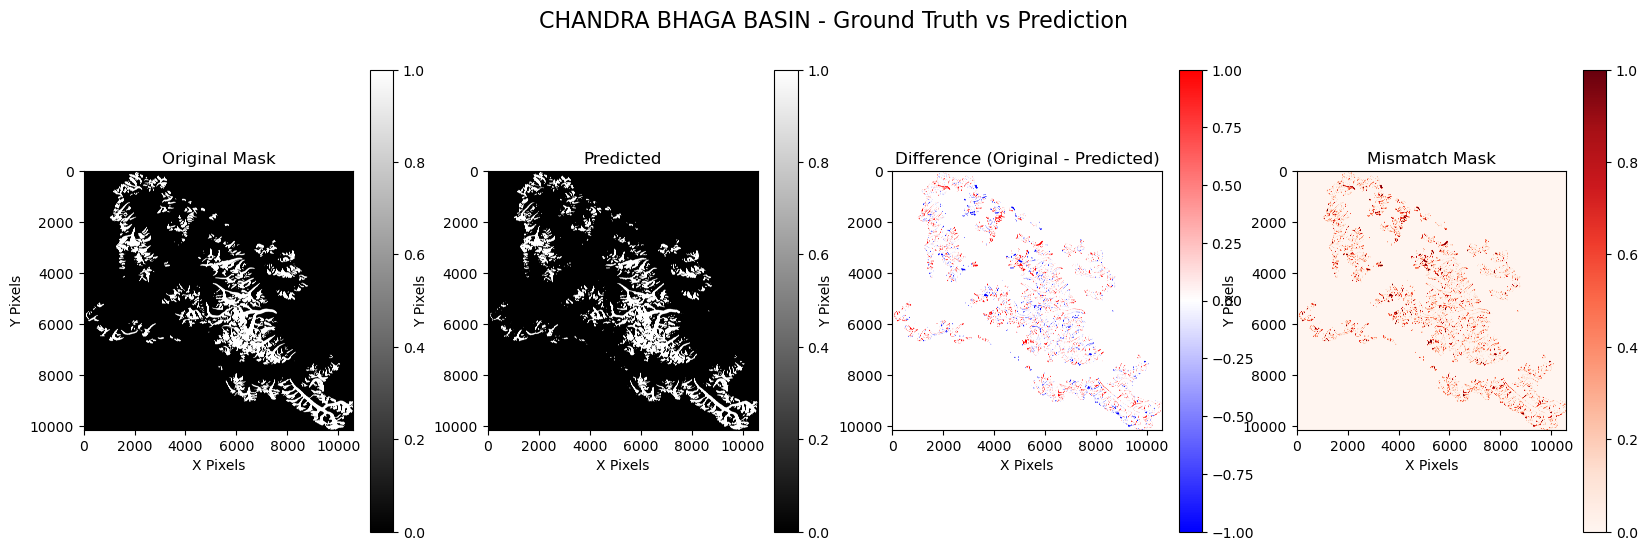

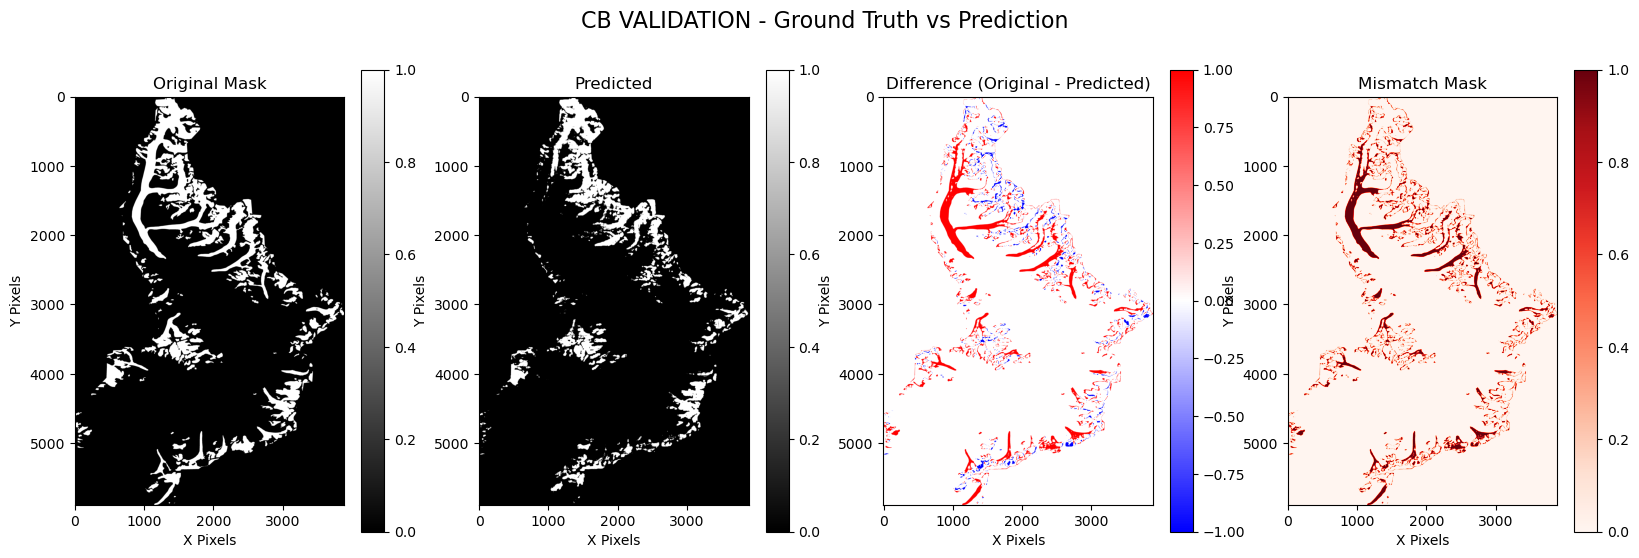

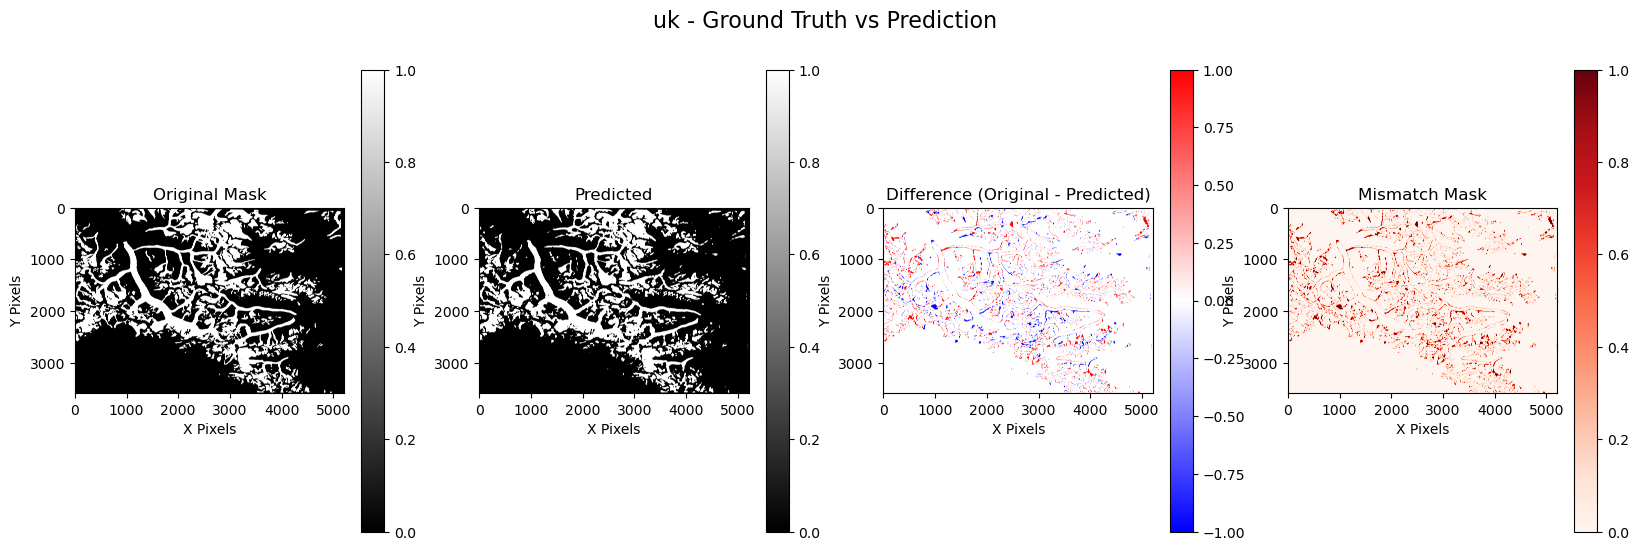

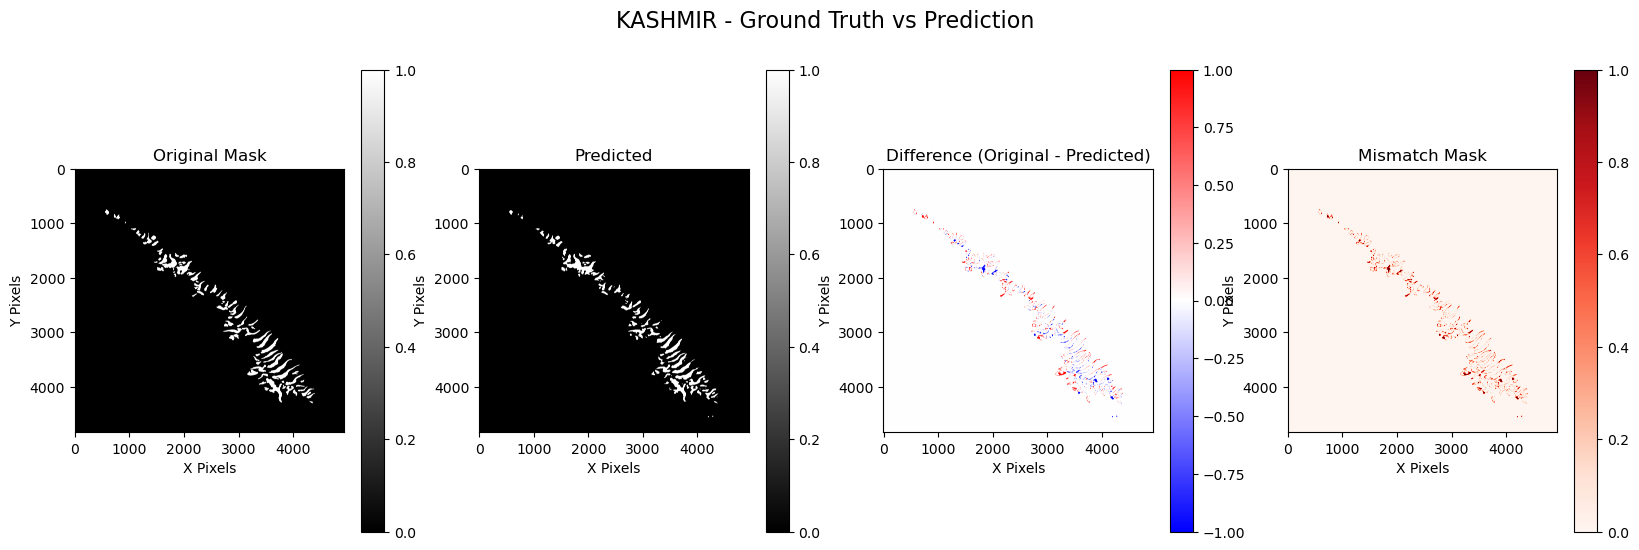

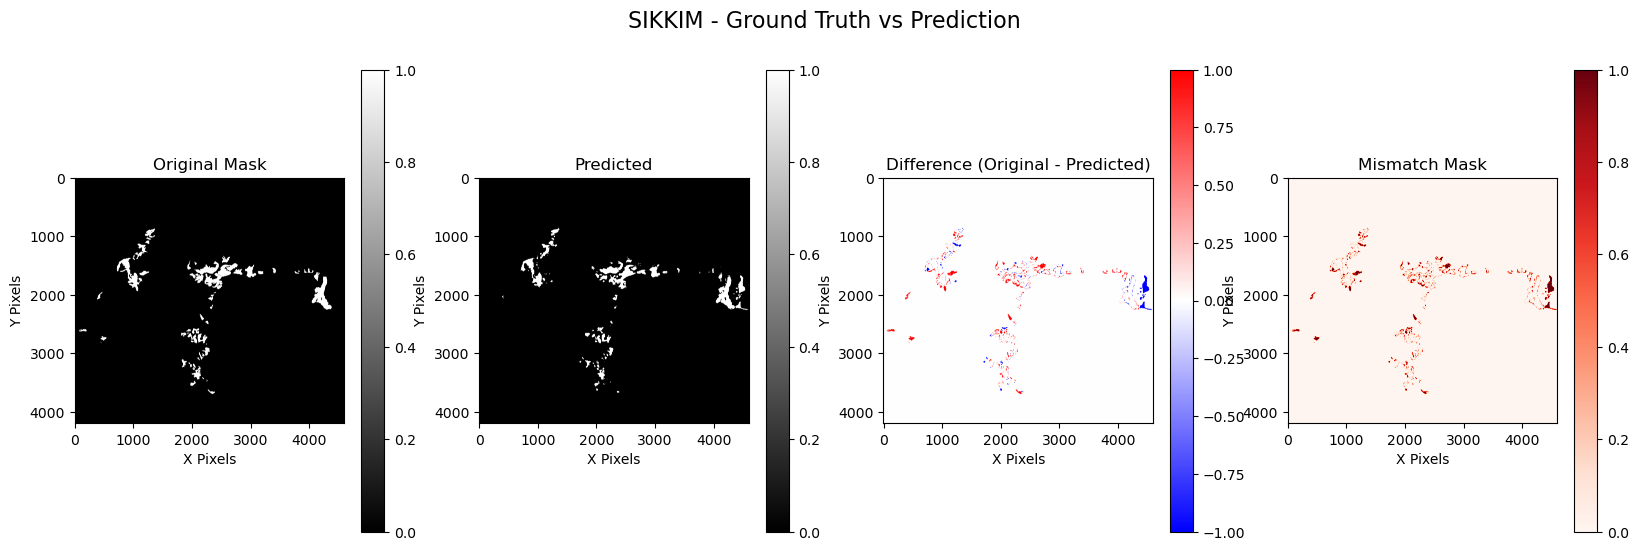

In [40]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling
import os

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/raster_cb__normalized_predicted_raster.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/cb_vali_normalized_128_predicted_raster.tif',
        'label': 'CB VALIDATION'
    },
    {
        'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/NEW_UK_TIF_fixedB10_predicted_raster.tif',
        'label': 'uk'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/KASHMIR_NORMALIZED_255_final_predicted_raster.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/sikkim_chaudhary_255_final_predicted_raster.tif',
        'label': 'SIKKIM'
    },
]


# Loop over each pair
for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted raster to match original mask dimensions
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    resampled_predicted_valid = resampled_predicted[valid_mask]

    # Compute metrics
    conf_matrix = confusion_matrix(original_mask_valid, resampled_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, resampled_predicted_valid)
    iou = jaccard_score(original_mask_valid, resampled_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, resampled_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, resampled_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, resampled_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, resampled_predicted_valid)

    # Print metrics
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Visualize - create new figure for each dataset
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Ground Truth vs Prediction", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])
    
    # Predicted
    im1 = axes[1].imshow(resampled_predicted, cmap='gray')
    axes[1].set_title("Predicted")
    plt.colorbar(im1, ax=axes[1])
    
    # Difference
    diff = original_mask.astype(int) - resampled_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Original - Predicted)")
    plt.colorbar(im2, ax=axes[2])
    
    # Difference Mask
    diff_mask = (original_mask != resampled_predicted).astype(int)
    im3 = axes[3].imshow(diff_mask, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

# Show all plots at once
plt.show()

Input image shape: (1, 128, 128, 18)
Predictions shape: (1, 128, 128, 2)
Class index: 1


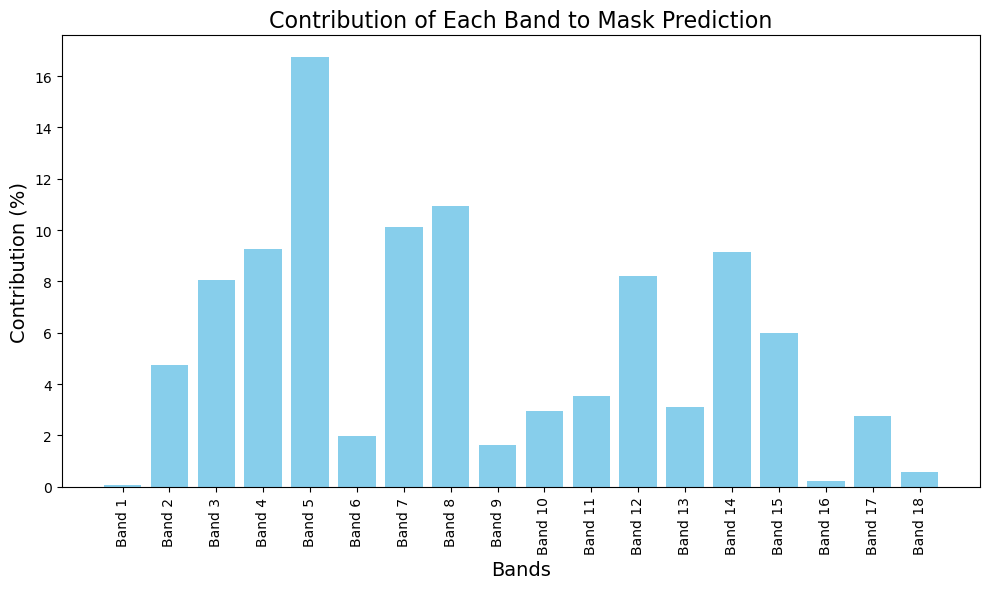

Band 1: 0.07% contribution
Band 2: 4.74% contribution
Band 3: 8.06% contribution
Band 4: 9.24% contribution
Band 5: 16.75% contribution
Band 6: 1.98% contribution
Band 7: 10.12% contribution
Band 8: 10.94% contribution
Band 9: 1.64% contribution
Band 10: 2.95% contribution
Band 11: 3.53% contribution
Band 12: 8.21% contribution
Band 13: 3.10% contribution
Band 14: 9.16% contribution
Band 15: 5.98% contribution
Band 16: 0.21% contribution
Band 17: 2.74% contribution
Band 18: 0.59% contribution


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# Select a random test image
test_image_number = random.randint(0, len(X_test) - 1)
test_image = X_test[test_image_number]

# Ensure the input image has the correct shape
input_image = tf.convert_to_tensor(np.expand_dims(test_image, axis=0), dtype=tf.float32)
print(f"Input image shape: {input_image.shape}")  # Should print (1, 64, 64, 18)

# Get model predictions
predictions = model(input_image)
print(f"Predictions shape: {predictions.shape}")  # Should print (1, 64, 64, num_classes)

# Choose the class index (0 or 1) to analyze the gradients for
class_index = 1  # For example, class 1 (you can change to 0 to analyze the other class)
print(f"Class index: {class_index}")

# Initialize a GradientTape to compute gradients
with tf.GradientTape() as tape:
    tape.watch(input_image)  # Watch the input image for gradients
    predictions = model(input_image)
    class_predictions = predictions[0, :, :, class_index]  # Select the predicted class map

# Compute the gradients of the predicted class with respect to each input band (channel)
grads = tape.gradient(class_predictions, input_image)

# Calculate the mean gradient for each band (across height and width)
mean_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

# Normalize the gradients to calculate contributions as percentages
total_grad = np.sum(np.abs(mean_grads))
contributions = (np.abs(mean_grads) / total_grad) * 100  # Percentage contribution of each band

# Plot the contributions of each band
plt.figure(figsize=(10, 6))
bands = [f'Band {i+1}' for i in range(18)]
plt.bar(bands, contributions, color='skyblue')
plt.title('Contribution of Each Band to Mask Prediction', fontsize=16)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Contribution (%)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the percentage contribution of each band
for i, contribution in enumerate(contributions):
    print(f"Band {i+1}: {contribution:.2f}% contribution")

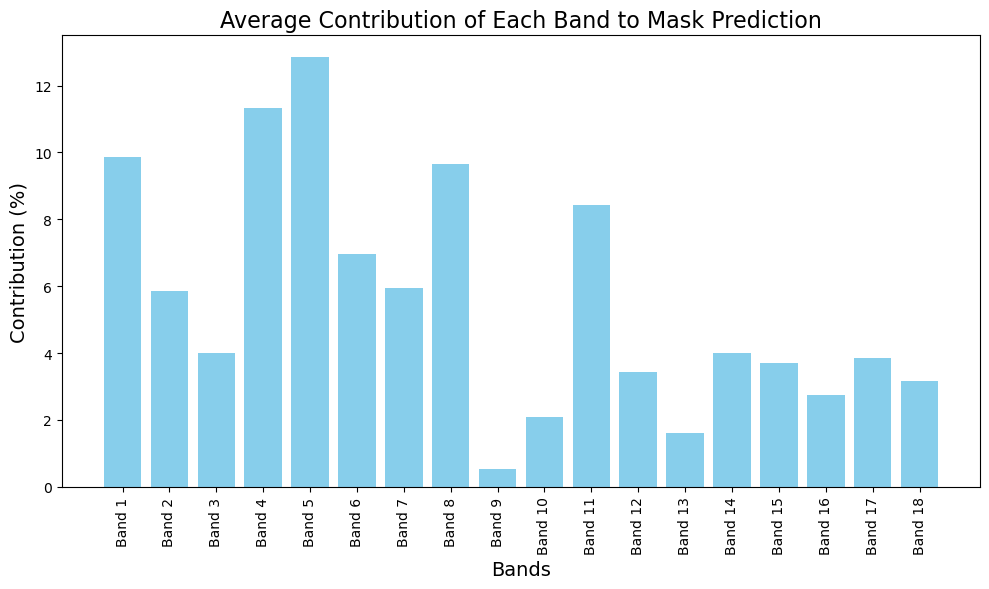

Band 1: 9.87% contribution
Band 2: 5.87% contribution
Band 3: 4.00% contribution
Band 4: 11.33% contribution
Band 5: 12.86% contribution
Band 6: 6.96% contribution
Band 7: 5.95% contribution
Band 8: 9.66% contribution
Band 9: 0.53% contribution
Band 10: 2.08% contribution
Band 11: 8.42% contribution
Band 12: 3.43% contribution
Band 13: 1.60% contribution
Band 14: 4.00% contribution
Band 15: 3.69% contribution
Band 16: 2.74% contribution
Band 17: 3.85% contribution
Band 18: 3.16% contribution


In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

all_contributions = []

for test_image in X_test:
    input_image = tf.convert_to_tensor(np.expand_dims(test_image, axis=0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        class_predictions = predictions[0, :, :, class_index]  

    grads = tape.gradient(class_predictions, input_image)
    mean_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
    
    total_grad = np.sum(np.abs(mean_grads))

    if total_grad == 0:
        contributions = np.zeros_like(mean_grads)  # Handle zero division safely
    else:
        contributions = (np.abs(mean_grads) / total_grad) * 100  

    all_contributions.append(contributions)

# Compute average contribution across all patches
avg_contributions = np.mean(all_contributions, axis=0)

# Plot
plt.figure(figsize=(10, 6))
bands = [f'Band {i+1}' for i in range(len(avg_contributions))]
plt.bar(bands, avg_contributions, color='skyblue')
plt.title('Average Contribution of Each Band to Mask Prediction', fontsize=16)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Contribution (%)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the percentage contribution of each band
for i, contribution in enumerate(avg_contributions):
    print(f"Band {i+1}: {contribution:.2f}% contribution")


In [10]:
import rasterio
import numpy as np
import os

# Input raster file paths
raster_files = [
    "sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif",
    "sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif",
    "sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif",
    "sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif",
    "sarvesh/DATASETS_NORMALIZED/cb_vali_normalized_128.tif",
]

# Output directory for filtered rasters
output_dir = "sarvesh/mlandsnet_sato_new/top_6/"
os.makedirs(output_dir, exist_ok=True)

# Updated Top 6 contributing bands (1-based indices)
top_6_bands = [5, 4, 1, 8, 11, 6]

# Process each raster file
for raster_path in raster_files:
    with rasterio.open(raster_path) as src:
        num_bands = src.count
        selected_bands = [b for b in top_6_bands if b <= num_bands]

        # Read and stack the selected bands
        selected_data = np.stack([src.read(b) for b in selected_bands])

        # Output file name
        output_filename = os.path.join(
            output_dir,
            os.path.basename(raster_path).replace(".tif", "_6band.tif")
        )

        # Write filtered raster
        with rasterio.open(
            output_filename, 'w', driver='GTiff',
            height=src.height, width=src.width,
            count=len(selected_bands), dtype=src.dtypes[0],
            crs=src.crs, transform=src.transform
        ) as dst:
            dst.write(selected_data)

        print(f"Processed: {raster_path} → Saved: {output_filename}")

print("Top 6 band filtering complete!")


Processed: sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif → Saved: sarvesh/mlandsnet_sato_new/top_6/raster_cb__normalized_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif → Saved: sarvesh/mlandsnet_sato_new/top_6/KASMIR_255_CLIP_6band.tif
Processed: sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif → Saved: sarvesh/mlandsnet_sato_new/top_6/NEW_UK_TIF_fixedB10_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif → Saved: sarvesh/mlandsnet_sato_new/top_6/sikkim_255_clip_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/cb_vali_normalized_128.tif → Saved: sarvesh/mlandsnet_sato_new/top_6/cb_vali_normalized_128_6band.tif
Top 6 band filtering complete!


In [11]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine
from concurrent.futures import ThreadPoolExecutor

# ============================
# INPUT
# ============================
raster_mask_pairs = [
    ("sarvesh/mlandsnet_sato_new/top_6/NEW_UK_TIF_fixedB10_6band.tif", "sarvesh/sato_new/glacier_mask_binary.tif"),
    ("sarvesh/mlandsnet_sato_new/top_6/KASMIR_255_CLIP_6band.tif", "sarvesh/DATASETS_NORMALIZED/vectors/KASHMIR_CLIP.tif"),
    ("sarvesh/mlandsnet_sato_new/top_6/sikkim_255_clip_6band.tif", "sarvesh/DATASETS_NORMALIZED/vectors/sikkim_clip_mask.tif"),
    ("sarvesh/mlandsnet_sato_new/top_6/raster_cb__normalized_6band.tif", "sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/masks_reprojected/raster_cb__normalized_6band_mask_reprojected.tif"),
]

output_raster_dir = "sarvesh/mlandsnet_sato_new/top_6/rasterlayer"
output_mask_dir = "sarvesh/mlandsnet_sato_new/top_6/masklayer"
patch_size = 128

# ============================
# Directory Preparation
# ============================
def clear_and_create_dir(path):
    if os.path.exists(path):
        for f in os.listdir(path):
            os.remove(os.path.join(path, f))
    else:
        os.makedirs(path)

clear_and_create_dir(output_raster_dir)
clear_and_create_dir(output_mask_dir)

# ============================
# Augmentations
# ============================
def horizontal_flip(p): return np.flip(p, axis=2)
def vertical_flip(p): return np.flip(p, axis=1)
def rotate_90(p): return np.rot90(p, k=1, axes=(1, 2))
def rotate_180(p): return np.rot90(p, k=2, axes=(1, 2))
def rotate_270(p): return np.rot90(p, k=3, axes=(1, 2))

def apply_augmentations(data, mask_data):
    augments = [("original", data, mask_data)]
    for name, func in [("hflip", horizontal_flip), ("vflip", vertical_flip),
                       ("rot90", rotate_90), ("rot180", rotate_180), ("rot270", rotate_270)]:
        augments.append((name, func(data), func(mask_data)))
    return augments

# ============================
# Patch Check + Save
# ============================
def is_empty_patch(mask_patch):
    return np.all(mask_patch == 0)

def get_patch_transform(transform, i, j, patch_size):
    return Affine.translation(transform.c + j * transform.a,
                               transform.f + i * transform.e) * Affine.scale(transform.a, transform.e)

def save_patch(data, output_dir, prefix, i, j, transform, crs, aug_name):
    filename = os.path.join(output_dir, f"{prefix}_patch_{i}_{j}_{aug_name}.tif")
    height, width = data.shape[1], data.shape[2]
    count = data.shape[0]
    patch_transform = get_patch_transform(transform, i, j, patch_size)

    with rasterio.open(filename, 'w', driver='GTiff',
                       height=height, width=width,
                       count=count, dtype=data.dtype,
                       crs=crs, transform=patch_transform) as dst:
        dst.write(data)

# ============================
# Main Processing
# ============================
def process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size):
    with rasterio.open(raster_path) as raster_src, rasterio.open(mask_path) as mask_src:
        raster = raster_src.read()  # shape: (bands, h, w)
        mask = mask_src.read()      # shape: (1, h, w) or (bands, h, w)
        crs = raster_src.crs
        transform = raster_src.transform

        # If mask is single band, keep shape as (1, h, w)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=0)

        h, w = raster.shape[1], raster.shape[2]
        jobs = []

        for i in range(0, h - patch_size + 1, patch_size):
            for j in range(0, w - patch_size + 1, patch_size):
                r_patch = raster[:, i:i+patch_size, j:j+patch_size]
                m_patch = mask[:, i:i+patch_size, j:j+patch_size]

                if r_patch.shape[1:] != (patch_size, patch_size) or m_patch.shape[1:] != (patch_size, patch_size):
                    continue
                if is_empty_patch(m_patch):
                    continue

                for aug_name, aug_r, aug_m in apply_augmentations(r_patch, m_patch):
                    jobs.append((aug_r, output_raster_dir, 'raster', i, j, transform, crs, aug_name))
                    jobs.append((aug_m, output_mask_dir, 'mask', i, j, transform, crs, aug_name))

        # Save all patches
        with ThreadPoolExecutor() as executor:
            for job in jobs:
                executor.submit(save_patch, *job)

# ============================
# Run All
# ============================
for raster_path, mask_path in raster_mask_pairs:
    print(f"Processing: {raster_path}")
    process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size)

# Summary
patch_count = len([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
print(f"Total 64x64 patches generated (with augmentations): {patch_count}")


Processing: sarvesh/mlandsnet_sato_new/top_6/NEW_UK_TIF_fixedB10_6band.tif
Processing: sarvesh/mlandsnet_sato_new/top_6/KASMIR_255_CLIP_6band.tif
Processing: sarvesh/mlandsnet_sato_new/top_6/sikkim_255_clip_6band.tif
Processing: sarvesh/mlandsnet_sato_new/top_6/raster_cb__normalized_6band.tif
Total 64x64 patches generated (with augmentations): 13836


Number of bands in raster: 6


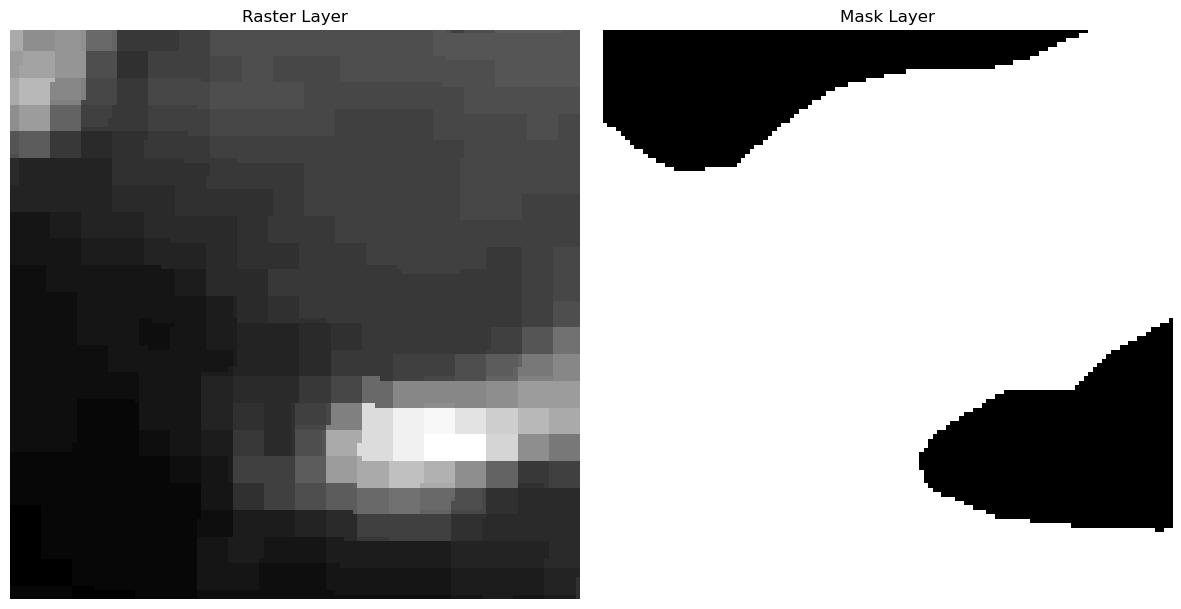

Number of bands in raster: 6


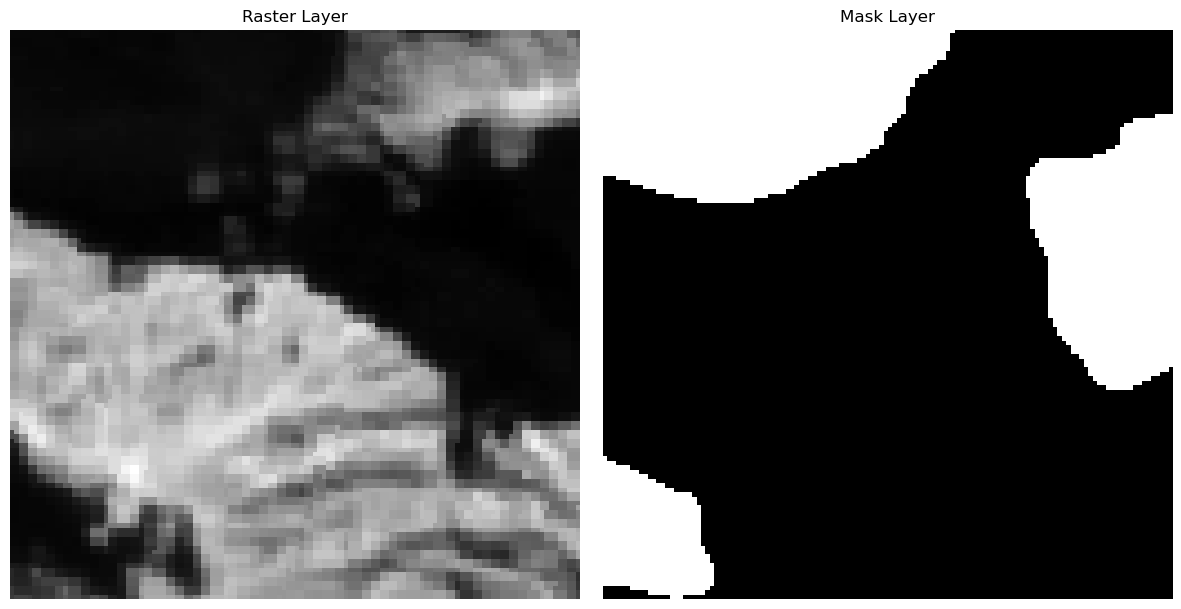

Number of bands in raster: 6


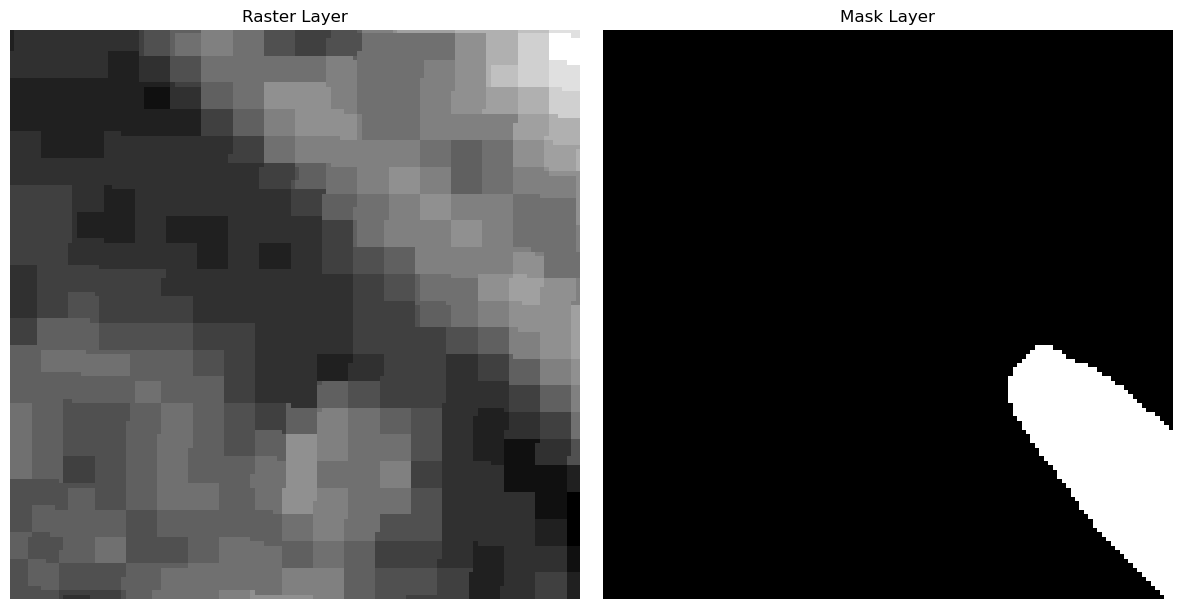

Number of bands in raster: 6


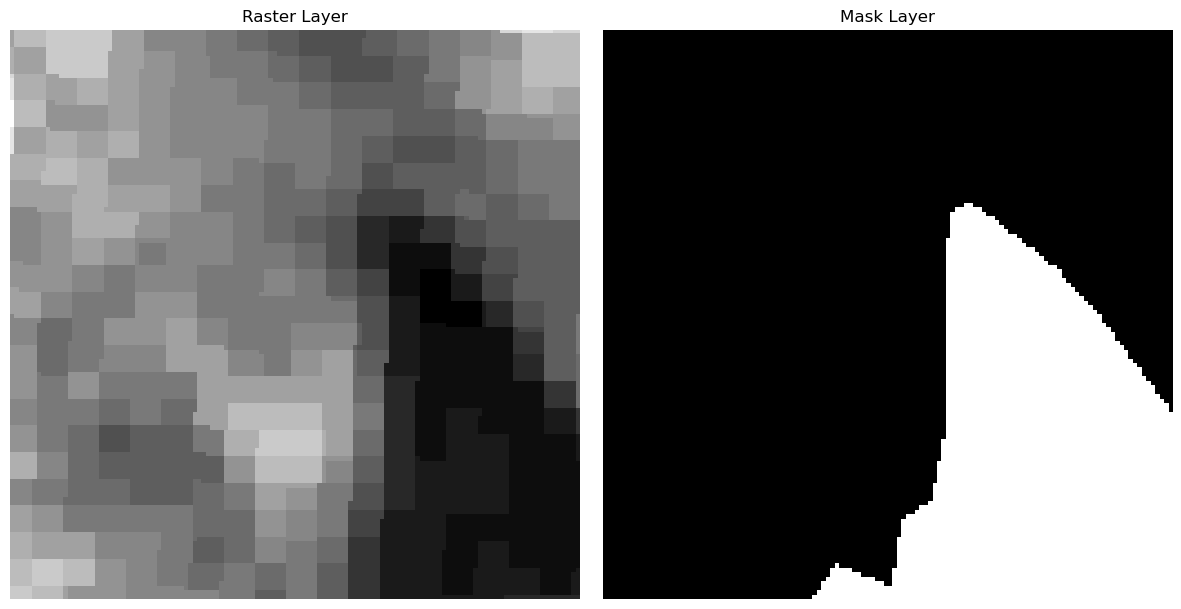

In [12]:
import os
import random
import rasterio
import matplotlib.pyplot as plt

# Output directories
output_raster_dir = "sarvesh/mlandsnet_sato_new/top_6/rasterlayer"
output_mask_dir = "sarvesh/mlandsnet_sato_new/top_6/masklayer"
patch_size = 128

# Get a list of patch files
raster_files = sorted([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(output_mask_dir) if f.endswith('.tif')])

# Randomly select 4 unique indices
if len(raster_files) >= 4 and len(mask_files) >= 4:
    random_indices = random.sample(range(len(raster_files)), 4)
else:
    print("Not enough raster or mask files available.")
    random_indices = []

# Visualization function for raster and mask
def visualize_layers(raster_file, mask_file):
    with rasterio.open(raster_file) as src_raster:
        # Check the number of bands in the raster
        num_bands = src_raster.count
        print(f"Number of bands in raster: {num_bands}")  # Debugging line

        # Select the first band (ensure it's the correct band)
        raster_data = src_raster.read(1)  # Change this if you want a different band

    with rasterio.open(mask_file) as src_mask:
        mask_data = src_mask.read(1)  # Read the first band (or layer)

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot raster
    ax[0].imshow(raster_data, cmap='gray')
    ax[0].set_title('Raster Layer')
    ax[0].axis('off')  # Hide axis

    # Plot mask
    ax[1].imshow(mask_data, cmap='gray')
    ax[1].set_title('Mask Layer')
    ax[1].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Visualize the selected random patches
for index in random_indices:
    visualize_layers(os.path.join(output_raster_dir, raster_files[index]),
                     os.path.join(output_mask_dir, mask_files[index]))

In [13]:
import os
import rasterio
import numpy as np

output_raster_dir = "sarvesh/mlandsnet_sato_new/top_6/rasterlayer"
output_mask_dir = "sarvesh/mlandsnet_sato_new/top_6/masklayer"

# Function to check if a file is a valid raster
def is_valid_raster(file_path):
    try:
        with rasterio.open(file_path) as src:
            return True
    except:
        return False

# Function to load patches and calculate metrics
def load_and_calculate_metrics(raster_dir, mask_dir):
    raster_files = sorted([f for f in os.listdir(raster_dir) if is_valid_raster(os.path.join(raster_dir, f))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if is_valid_raster(os.path.join(mask_dir, f))])

    if not raster_files or not mask_files:
        print("No valid raster or mask files found.")
        return

    # Load first raster file to extract dimensions
    with rasterio.open(os.path.join(raster_dir, raster_files[0])) as src:
        raster_height = src.height
        raster_width = src.width
        raster_channels = src.count

    # Count the number of patches
    raster_length = len(raster_files)
    mask_length = len(mask_files)

    # Check for the total classes in the mask
    mask_classes = set()

    for mask_file in mask_files:
        with rasterio.open(os.path.join(mask_dir, mask_file)) as mask_src:
            mask_data = mask_src.read(1)  # Read the first band
            mask_classes.update(np.unique(mask_data))

    # Print the calculated metrics
    print("Length of raster dataset:", raster_length)
    print("Length of mask dataset:", mask_length)
    print("Raster height:", raster_height)
    print("Raster width:", raster_width)
    print("Raster channels:", raster_channels)
    print("Total classes of mask (1 for glacier, 0 for non-glacier):", sorted(mask_classes))

# Call the function to load datasets and calculate metrics
load_and_calculate_metrics(output_raster_dir, output_mask_dir)

Length of raster dataset: 13836
Length of mask dataset: 13836
Raster height: 128
Raster width: 128
Raster channels: 6
Total classes of mask (1 for glacier, 0 for non-glacier): [0, 1]


In [14]:
import os
import numpy as np
import rasterio

# Define paths
output_raster_dir = "sarvesh/mlandsnet_sato_new/top_6/rasterlayer"
output_mask_dir = "sarvesh/mlandsnet_sato_new/top_6/masklayer"

# Function to load raster dataset with shape check and remove mismatched files
def load_and_clean_raster_dataset(raster_dir, mask_dir):
    raster_files = sorted([f for f in os.listdir(raster_dir) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])

    image_list, mask_list = [], []

    ref_shape = None
    for r_file, m_file in zip(raster_files, mask_files):
        r_path = os.path.join(raster_dir, r_file)
        m_path = os.path.join(mask_dir, m_file)

        with rasterio.open(r_path) as r_src, rasterio.open(m_path) as m_src:
            r_data = r_src.read()
            m_data = m_src.read(1)

            # Initialize reference shape
            if ref_shape is None:
                ref_shape = (r_data.shape, m_data.shape)

            # Check shape match
            if r_data.shape == ref_shape[0] and m_data.shape == ref_shape[1]:
                image_list.append(r_data)
                mask_list.append(m_data)
            else:
                # Removing mismatched files
                print(f"Skipping and removing mismatched: {r_file} | {r_data.shape} vs {m_data.shape}")
                os.remove(r_path)
                os.remove(m_path)

    return (
        np.stack(image_list, axis=0) if image_list else np.array([]),
        np.array(mask_list) if mask_list else np.array([])
    )

# Load consistent raster and mask data and clean mismatched files
image_dataset, mask_dataset = load_and_clean_raster_dataset(output_raster_dir, output_mask_dir)
print("Loaded image dataset shape:", image_dataset.shape)
print("Loaded mask dataset shape:", mask_dataset.shape)

# Transpose image data to (n_samples, height, width, channels)
if image_dataset.ndim == 4:
    image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))  # NCHW → NHWC
    print("Transposed image dataset shape:", image_dataset.shape)
else:
    print("Warning: Unexpected image dataset shape.")

# Extract image properties
if image_dataset.size > 0:
    image_height, image_width, image_channels = image_dataset.shape[1:]
    print(f"Image HxW: {image_height}x{image_width}, Channels: {image_channels}")
else:
    print("Empty image dataset!")

# Unique classes in mask
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
print("Unique labels in masks:", unique_labels)

# One-hot encode the mask
from keras.utils import to_categorical
labels_categorical_dataset = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
from sklearn.model_selection import train_test_split
if image_dataset.shape[0] == labels_categorical_dataset.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(
        image_dataset, labels_categorical_dataset, test_size=0.1, random_state=100
    )
    print("Train-test split done.")
    print("Train shapes:", X_train.shape, y_train.shape)
    print("Test shapes:", X_test.shape, y_test.shape)
else:
    print("Mismatch in number of images and masks!")


Loaded image dataset shape: (13836, 6, 128, 128)
Loaded mask dataset shape: (13836, 128, 128)
Transposed image dataset shape: (13836, 128, 128, 6)
Image HxW: 128x128, Channels: 6
Unique labels in masks: [0. 1.]
Train-test split done.
Train shapes: (12452, 128, 128, 6) (12452, 128, 128, 2)
Test shapes: (1384, 128, 128, 6) (1384, 128, 128, 2)


In [15]:
output_raster_dir = "sarvesh/mlandsnet_sato_new/top_6/rasterlayer"
output_mask_dir = "sarvesh/mlandsnet_sato_new/top_6/masklayer"
patch_size = 128  # Ensure your patches match your input shape

# Function to load raster dataset
def load_raster_dataset(directory):
    image_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                image_data = src.read()
                image_list.append(image_data)
    return np.stack(image_list, axis=0) if image_list else np.array([])

In [17]:
# Function to load mask dataset
def load_mask_dataset(directory):
    mask_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                mask_data = src.read(1)
                mask_list.append(mask_data)
    return np.stack(mask_list, axis=0) if mask_list else np.array([])

# Load datasets
image_dataset = load_raster_dataset(output_raster_dir)
mask_dataset = load_mask_dataset(output_mask_dir)

# Transpose image dataset to have channels last
image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))

# Normalize image data
#image_dataset = image_dataset.astype('float32') / 255.0

# Convert mask to categorical
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
mask_dataset_cat = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, mask_dataset_cat, test_size=0.1, random_state=100
)

In [18]:
# Define Jaccard Coefficient for metric
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

# Define residual block (ResBlock)
def res_block(x, filters, kernel_size=3, strides=1, dilation_rate=1):
    res = Conv2D(filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate)(x)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)
    res = Conv2D(filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate)(res)
    res = BatchNormalization()(res)

    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    res = Add()([res, shortcut])
    res = Activation('relu')(res)
    return res

# Define attention gate
def attention_gate(x, g, filters):
    theta_x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(filters, kernel_size=1, strides=1, padding='same')(g)
    concat = Add()([theta_x, phi_g])
    act = Activation('relu')(concat)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(act)
    sigmoid = Activation('sigmoid')(psi)
    attention = Multiply()([x, sigmoid])
    return attention

# Define M-LandsNet model
def m_landsnet(n_classes=1, image_height=128, image_width=128, image_channels=1):
    inputs = Input((image_height, image_width, image_channels))

    # Step 1: Contracting path with ResBlocks
    c1 = res_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = res_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = res_block(p2, 64)
    p3 = MaxPooling2D((2, 2))(c3)

    # Step 2: Multiscale fusion with dilated convolutions
    m1 = Conv2D(128, (3, 3), padding='same', dilation_rate=1)(p3)
    m2 = Conv2D(128, (3, 3), padding='same', dilation_rate=2)(p3)
    m3 = Conv2D(128, (3, 3), padding='same', dilation_rate=3)(p3)

    fused = Add()([m1, m2])
    fused = Conv2D(128, (1, 1), padding='same')(fused)
    fused = Add()([fused, m3])
    fused = Conv2D(128, (1, 1), padding='same')(fused)

    # Step 3: Expansive path with upsampling, concatenation, and ResBlocks
    u6 = UpSampling2D((2, 2))(fused)
    a6 = attention_gate(c3, u6, 64)
    u6 = concatenate([u6, a6])
    c6 = res_block(u6, 64)

    u7 = UpSampling2D((2, 2))(c6)
    a7 = attention_gate(c2, u7, 32)
    u7 = concatenate([u7, a7])
    c7 = res_block(u7, 32)

    u8 = UpSampling2D((2, 2))(c7)
    a8 = attention_gate(c1, u8, 16)
    u8 = concatenate([u8, a8])
    c8 = res_block(u8, 16)

    # Step 4: Final convolution and softmax activation
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [19]:
# Compile model
model = m_landsnet(n_classes=total_classes,
                       image_height=X_train.shape[1],
                       image_width=X_train.shape[2],
                       image_channels=X_train.shape[3])

dice_loss = sm.losses.DiceLoss(class_weights=[0.3, 0.7])
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(optimizer=Adam(), loss=total_loss, metrics=["accuracy", jaccard_coef])

2025-09-02 19:14:12.275713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13505 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:a1:00.0, compute capability: 8.6


In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Enable mixed precision for faster GPU computation
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Path to save the model
model_save_path = 'sarvesh/mlandsnet_sato_new/top_6/model/newdsatoall_6layer_m_landsnet.h5'

#Increased Learning Rate for Faster Training
learning_rate = 1e-3  

#Use Adam Optimizer with New Learning Rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A4000, compute capability 8.6


In [21]:
# Model checkpoint callback (save the best model)
model_checkpoint = ModelCheckpoint(
    model_save_path, 
    save_best_only=True,  
    monitor='val_loss',   
    mode='min',           
    verbose=1            
)

# Increase batch size to fully utilize GPU
batch_size = 16

# Train the model with mixed precision and improved performance
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=1000,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/1000


2025-09-02 19:14:27.604067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-09-02 19:14:27.730766: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-09-02 19:14:28.018830: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-09-02 19:14:29.416374: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x799d88cf8e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-02 19:14:29.416427: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-09-02 19:14:29.422579: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-02 19:14:29.590649: I ./tensorflow/compiler/jit/device_compiler.h:

779/779 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.8699
Epoch 1: val_loss improved from inf to 0.30604, saving model to sarvesh/mlandsnet_sato_new/top_6/model/newdsatoall_6layer_m_landsnet.h5
779/779 [==============================] - 55s 44ms/step - loss: 0.3060 - accuracy: 0.8699 - val_loss: 0.3060 - val_accuracy: 0.8756
Epoch 2/1000
  1/779 [..............................] - ETA: 28s - loss: 0.3540 - accuracy: 0.8361

/home/sarvesh/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


779/779 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.8868
Epoch 2: val_loss improved from 0.30604 to 0.25704, saving model to sarvesh/mlandsnet_sato_new/top_6/model/newdsatoall_6layer_m_landsnet.h5
779/779 [==============================] - 30s 39ms/step - loss: 0.2675 - accuracy: 0.8868 - val_loss: 0.2570 - val_accuracy: 0.8914
Epoch 3/1000
778/779 [============================>.] - ETA: 0s - loss: 0.2540 - accuracy: 0.8922
Epoch 3: val_loss did not improve from 0.25704
779/779 [==============================] - 31s 40ms/step - loss: 0.2539 - accuracy: 0.8922 - val_loss: 0.4854 - val_accuracy: 0.7842
Epoch 4/1000
779/779 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.8963
Epoch 4: val_loss improved from 0.25704 to 0.25099, saving model to sarvesh/mlandsnet_sato_new/top_6/model/newdsatoall_6layer_m_landsnet.h5
779/779 [==============================] - 32s 41ms/step - loss: 0.2460 - accuracy: 0.8963 - val_loss: 0.2510 - val_accuracy: 

In [22]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output.shape)

X_train shape: (12452, 128, 128, 6)
y_train shape: (12452, 128, 128, 2)
Model output shape: (None, 128, 128, 2)


In [23]:
# Check model output shape at different stages
print("Model output shape:", model.output.shape)

# Check the shape of y_train
print("Training labels shape:", y_train.shape)

Model output shape: (None, 128, 128, 2)
Training labels shape: (12452, 128, 128, 2)


Text(0.5, 1.0, 'Model Accuracy')

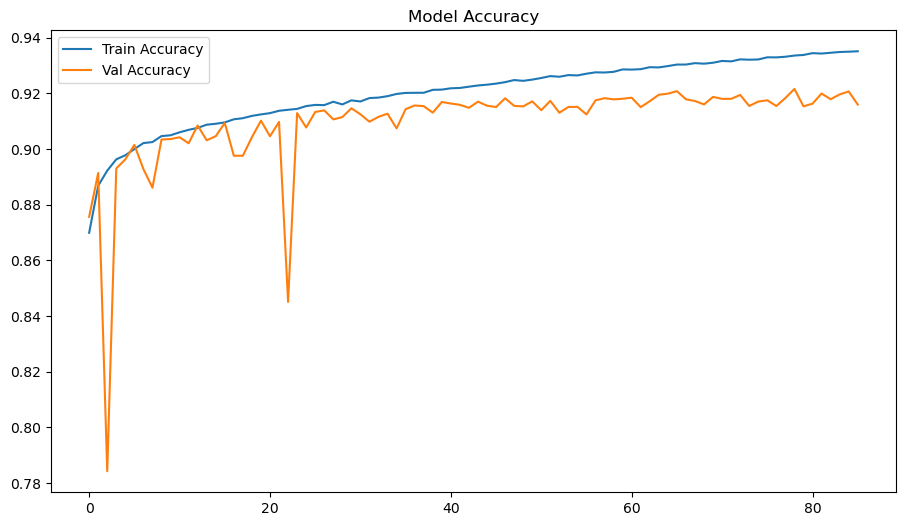

In [24]:
# Plot training results
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

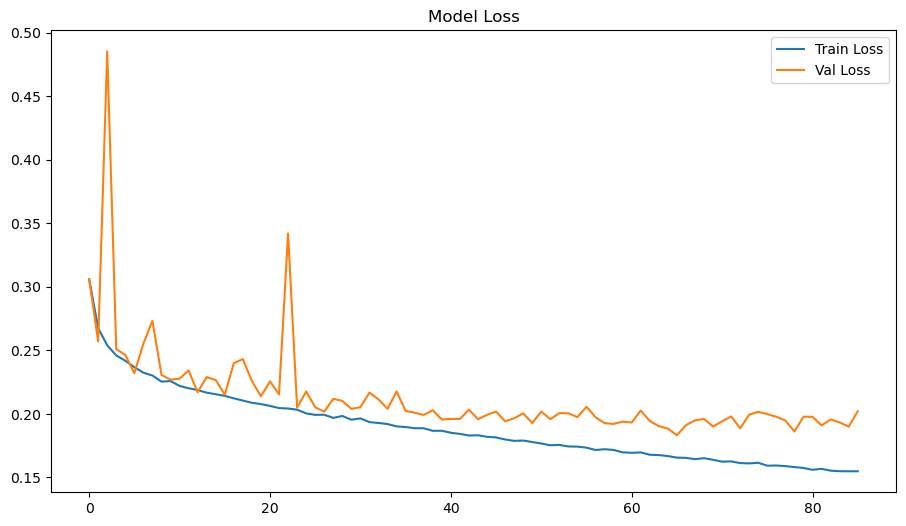

In [25]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [26]:
#Predict on the test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

44/44 [==============================] - 2s 18ms/step


In [27]:
# Convert y_test to argmax for comparison
y_test_argmax = np.argmax(y_test, axis=3)

In [27]:
# Select a random test image for prediction visualization
test_image_number = random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

NameError: name 'y_test_argmax' is not defined

1/1 [==============================] - 0s 51ms/step


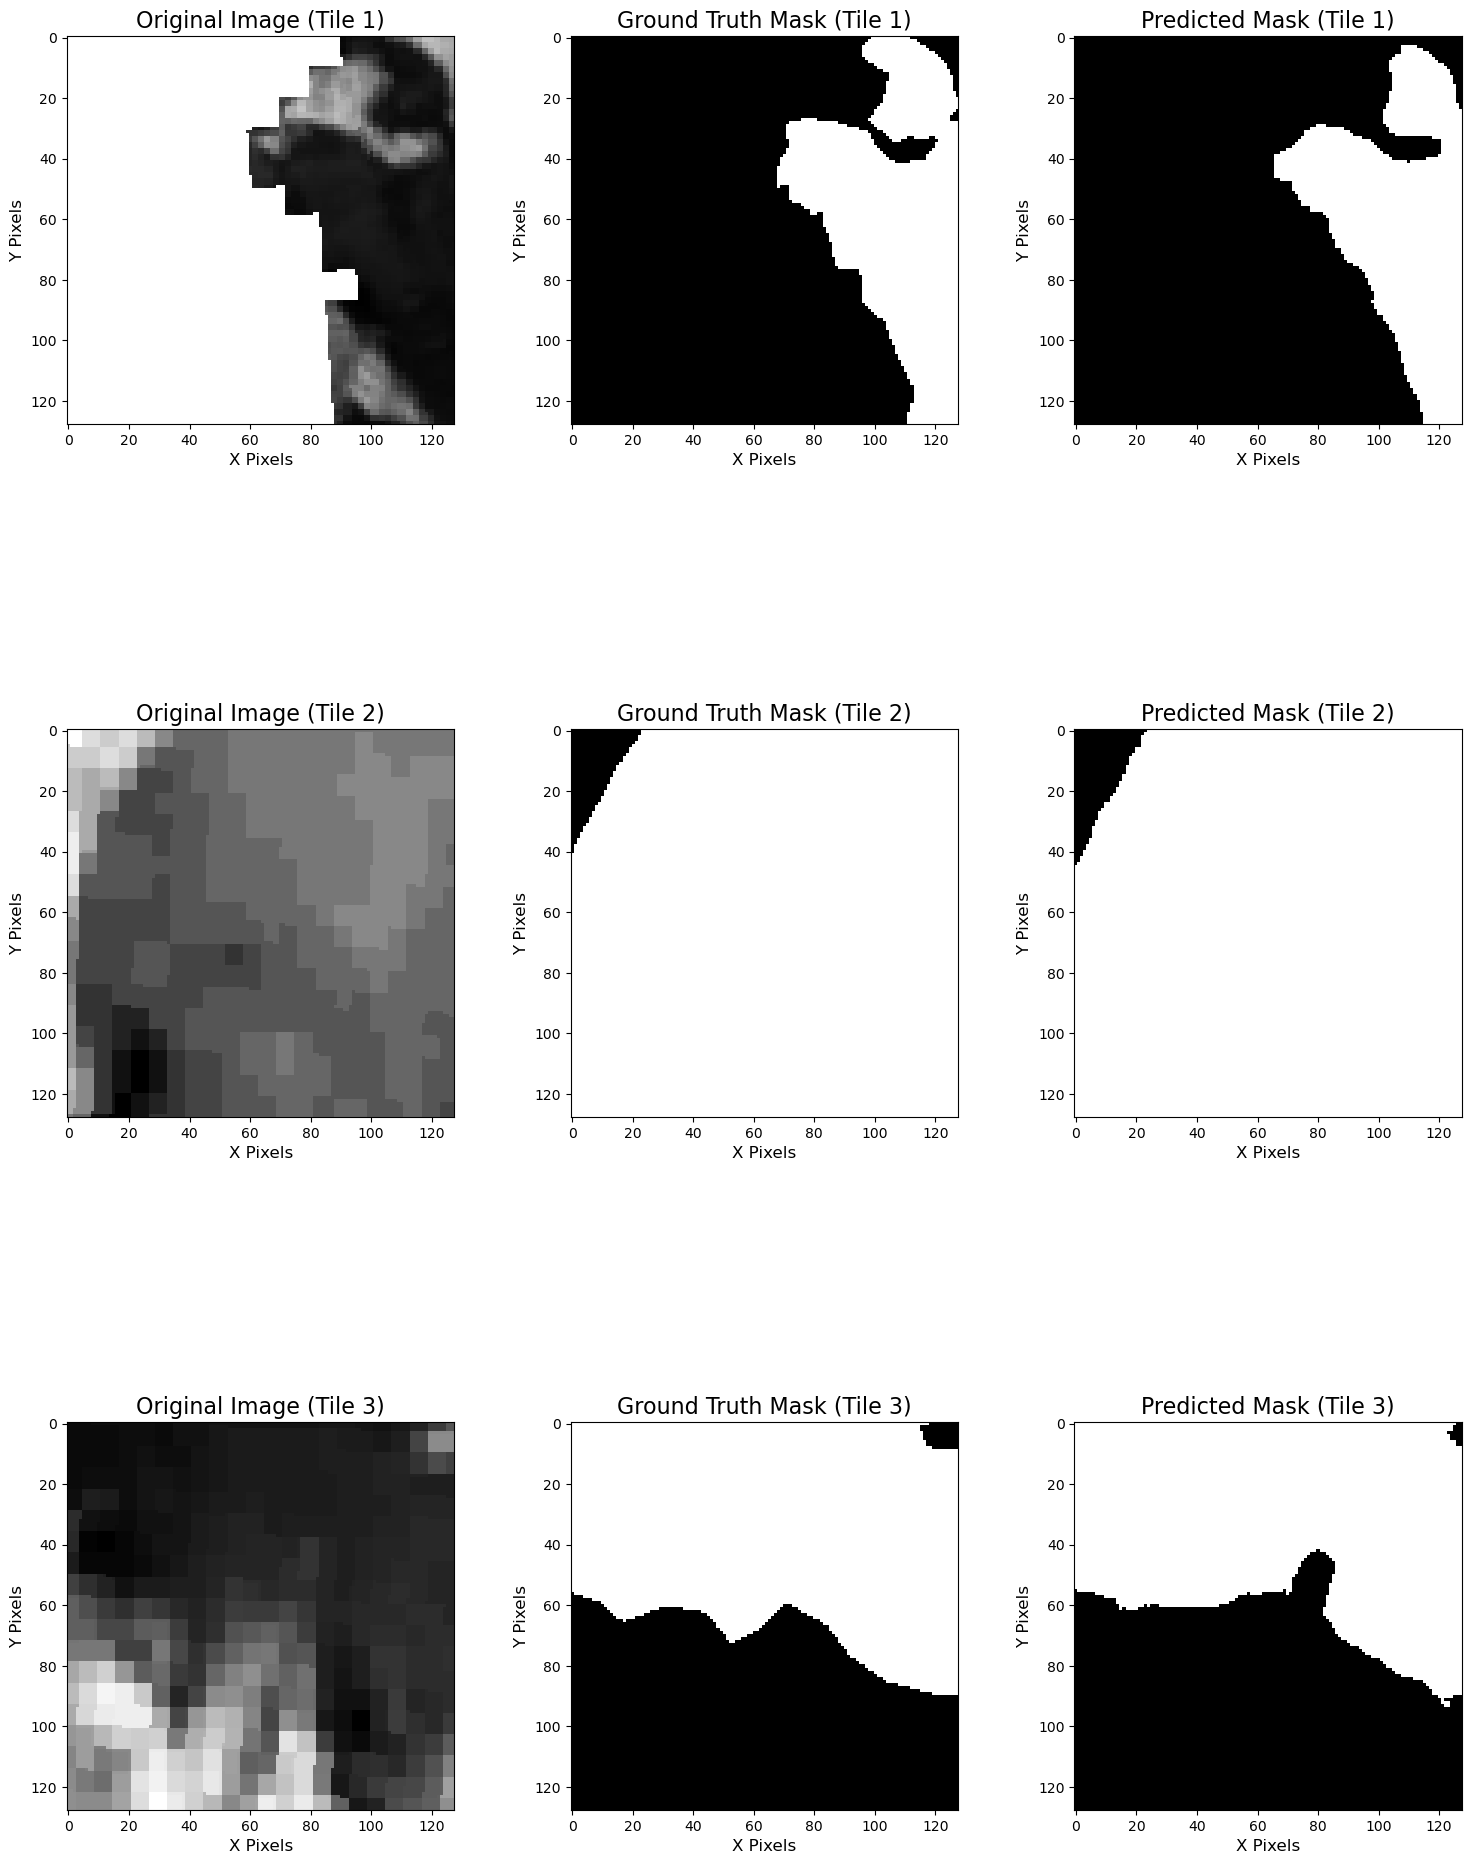

In [28]:
# Define the figure size and the spacing between subplots
plt.figure(figsize=(18, 24))  # Adjusted size for three rows
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Increased spacing between plots and rows

# Loop through the first three tiles in the test set
for i in range(3):
    test_image = X_test[i]
    ground_truth_image = np.argmax(y_test[i], axis=-1)  # Decategorize the mask
    predicted_mask = model.predict(np.expand_dims(test_image, axis=0))
    predicted_image = np.argmax(predicted_mask[0], axis=-1)  # Decategorize predicted mask

    # Original Image
    plt.subplot(3, 3, i * 3 + 1)
    plt.title(f"Original Image (Tile {i+1})", fontsize=16)
    plt.imshow(test_image[..., 0], cmap='gray')  # Show first channel only
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Ground Truth Mask
    plt.subplot(3, 3, i * 3 + 2)
    plt.title(f"Ground Truth Mask (Tile {i+1})", fontsize=16)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Predicted Mask
    plt.subplot(3, 3, i * 3 + 3)
    plt.title(f"Predicted Mask (Tile {i+1})", fontsize=16)
    plt.imshow(predicted_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

# Show the plot
plt.show()

In [29]:
from tensorflow.keras.models import load_model

# Path to your trained model
model_path = 'sarvesh/mlandsnet_sato_new/top_6/model/newdsatoall_6layer_m_landsnet.h5'

# Load the model (no custom objects used)
model = load_model(model_path, compile=False)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 6)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         880       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [30]:
import tensorflow as tf
from tensorflow import keras

# Define the custom loss functions
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = tf.exp(-bce)
    focal = alpha * (1 - bce_exp) ** gamma * bce
    return tf.keras.backend.mean(focal)

def dice_loss_plus_1focal_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

# Define the custom metric function
def jaccard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)  # Adding 1 for numerical stability

# Load the model with the custom loss and metric function
model_path = 'sarvesh/mlandsnet_sato_new/top_6/model/newdsatoall_6layer_m_landsnet.h5'
model = keras.models.load_model(model_path, custom_objects={
    'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss,
    'jaccard_coef': jaccard_coef
})

print("Model loaded successfully!")

Model loaded successfully!


In [31]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import LossScaleOptimizer

# Define a new optimizer
learning_rate = 1e-3
optimizer = LossScaleOptimizer(Adam(learning_rate=learning_rate))

# Recompile the model
model.compile(optimizer=optimizer, loss=dice_loss_plus_1focal_loss, metrics=[jaccard_coef])

print("Model recompiled successfully!")

Model recompiled successfully!


In [32]:
import rasterio
import numpy as np
import os

# Input raster file paths
raster_files = [
    "sarvesh/DATASETS_NORMALIZED/KASHMIR_NORMALIZED_255_final.tif",
    "sarvesh/DATASETS_NORMALIZED/sikkim_chaudhary_255_final.tif"
]

# Output directory for filtered rasters
output_dir = "sarvesh/mlandsnet_sato_new/top_6"
os.makedirs(output_dir, exist_ok=True)

# Top 6 contributing bands (1-based indices)
top_6_bands = [5, 4, 1, 8, 11, 6]

# Process each raster file
for raster_path in raster_files:
    with rasterio.open(raster_path) as src:
        num_bands = src.count
        selected_bands = [b for b in top_6_bands if b <= num_bands]

        # Read and stack the selected bands
        selected_data = np.stack([src.read(b) for b in selected_bands])

        # Output file name
        output_filename = os.path.join(
            output_dir,
            os.path.basename(raster_path).replace(".tif", "_6band.tif")
        )

        # Write filtered raster
        with rasterio.open(
            output_filename, 'w', driver='GTiff',
            height=src.height, width=src.width,
            count=len(selected_bands), dtype=src.dtypes[0],
            crs=src.crs, transform=src.transform
        ) as dst:
            dst.write(selected_data)

        print(f"Processed: {raster_path} → Saved: {output_filename}")

print("Top 6 band filtering complete!")

Processed: sarvesh/DATASETS_NORMALIZED/KASHMIR_NORMALIZED_255_final.tif → Saved: sarvesh/mlandsnet_sato_new/top_6/KASHMIR_NORMALIZED_255_final_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/sikkim_chaudhary_255_final.tif → Saved: sarvesh/mlandsnet_sato_new/top_6/sikkim_chaudhary_255_final_6band.tif
Top 6 band filtering complete!


In [33]:
import os
import numpy as np
import rasterio
from rasterio.features import shapes
import fiona
from shapely.geometry import shape, mapping
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define custom loss and metric functions
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = tf.exp(-bce)
    focal = alpha * (1 - bce_exp) ** gamma * bce
    return tf.keras.backend.mean(focal)

def dice_loss_plus_1focal_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

# Load trained model
model_path = 'sarvesh/mlandsnet_sato_new/top_6/model/newdsatoall_6layer_m_landsnet.h5'
model = tf.keras.models.load_model(model_path, custom_objects={
    'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss,
    'jaccard_coef': jaccard_coef
}, compile=False)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss_plus_1focal_loss, metrics=[jaccard_coef])

print("Model loaded successfully!")

# File paths
raster_files = [
    'sarvesh/mlandsnet_sato_new/top_6/NEW_UK_TIF_fixedB10_6band.tif',
    'sarvesh/mlandsnet_sato_new/top_6/sikkim_chaudhary_255_final_6band.tif',
    'sarvesh/mlandsnet_sato_new/top_6/KASHMIR_NORMALIZED_255_final_6band.tif',
    'sarvesh/mlandsnet_sato_new/top_6/raster_cb__normalized_6band.tif',
    'sarvesh/mlandsnet_sato_new/top_6/cb_vali_normalized_128_6band.tif'
]
output_dir = 'sarvesh/mlandsnet_sato_new/top_6/sf'
os.makedirs(output_dir, exist_ok=True)

# Settings
patch_size = 128
overlap = 64
stride = patch_size - overlap

# Process each raster
for raster_file in raster_files:
    base_name = os.path.splitext(os.path.basename(raster_file))[0]
    print(f"Processing: {base_name}")

    with rasterio.open(raster_file) as src:
        raster_data = src.read()
        raster_profile = src.profile
        transform = src.transform
        crs = src.crs

    height, width, channels = raster_data.shape[1], raster_data.shape[2], raster_data.shape[0]

    pad_h = (stride - height % stride) % stride
    pad_w = (stride - width % stride) % stride
    raster_data_padded = np.pad(raster_data, ((0, 0), (0, pad_h), (0, pad_w)), mode='reflect')

    blend_matrix = np.ones((patch_size, patch_size))
    for i in range(overlap):
        weight = (i + 1) / overlap
        blend_matrix[i, :] *= weight
        blend_matrix[-(i + 1), :] *= weight
        blend_matrix[:, i] *= weight
        blend_matrix[:, -(i + 1)] *= weight

    predicted_raster = np.zeros((raster_data_padded.shape[1], raster_data_padded.shape[2]), dtype=np.float32)
    weight_sum = np.zeros_like(predicted_raster)

    for i in range(0, raster_data_padded.shape[1] - patch_size + 1, stride):
        for j in range(0, raster_data_padded.shape[2] - patch_size + 1, stride):
            patch = raster_data_padded[:, i:i + patch_size, j:j + patch_size].transpose(1, 2, 0)
            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch, verbose=0)
            predicted_patch = np.argmax(prediction, axis=-1).squeeze()
            predicted_raster[i:i + patch_size, j:j + patch_size] += predicted_patch * blend_matrix
            weight_sum[i:i + patch_size, j:j + patch_size] += blend_matrix

    non_zero_mask = weight_sum > 0
    predicted_raster[non_zero_mask] = predicted_raster[non_zero_mask] / weight_sum[non_zero_mask]
    predicted_raster = np.nan_to_num(predicted_raster, nan=0).astype(np.uint8)
    predicted_raster = predicted_raster[:height, :width]

    output_raster_path = os.path.join(output_dir, f'{base_name}_predicted_raster.tif')
    raster_profile.update({'count': 1, 'dtype': 'uint8', 'compress': 'lzw', 'nodata': 0})

    with rasterio.open(output_raster_path, 'w', **raster_profile) as dst:
        dst.write(predicted_raster, 1)

    print(f"Saved raster: {output_raster_path}")

    # Save shapefile
    shapefile_path = os.path.join(output_dir, f'{base_name}_mask.shp')
    shapes_gen = shapes(predicted_raster, mask=predicted_raster > 0, transform=transform)

    schema = {
        'geometry': 'Polygon',
        'properties': {'value': 'int'}
    }

    with fiona.open(shapefile_path, 'w', driver='ESRI Shapefile', crs=crs, schema=schema) as shp:
        for geom, value in shapes_gen:
            shp.write({
                'geometry': mapping(shape(geom)),
                'properties': {'value': int(value)}
            })

    print(f"Saved shapefile: {shapefile_path}")

print("All rasters processed successfully!")

Model loaded successfully!
Processing: NEW_UK_TIF_fixedB10_6band
Saved raster: sarvesh/mlandsnet_sato_new/top_6/sf/NEW_UK_TIF_fixedB10_6band_predicted_raster.tif
Saved shapefile: sarvesh/mlandsnet_sato_new/top_6/sf/NEW_UK_TIF_fixedB10_6band_mask.shp
Processing: sikkim_chaudhary_255_final_6band
Saved raster: sarvesh/mlandsnet_sato_new/top_6/sf/sikkim_chaudhary_255_final_6band_predicted_raster.tif
Saved shapefile: sarvesh/mlandsnet_sato_new/top_6/sf/sikkim_chaudhary_255_final_6band_mask.shp
Processing: KASHMIR_NORMALIZED_255_final_6band
Saved raster: sarvesh/mlandsnet_sato_new/top_6/sf/KASHMIR_NORMALIZED_255_final_6band_predicted_raster.tif
Saved shapefile: sarvesh/mlandsnet_sato_new/top_6/sf/KASHMIR_NORMALIZED_255_final_6band_mask.shp
Processing: raster_cb__normalized_6band
Saved raster: sarvesh/mlandsnet_sato_new/top_6/sf/raster_cb__normalized_6band_predicted_raster.tif
Saved shapefile: sarvesh/mlandsnet_sato_new/top_6/sf/raster_cb__normalized_6band_mask.shp
Processing: cb_vali_normali


=== Processing Chandra Bhaga basin ===
Confusion Matrix:
[[94743746   612479]
 [ 1713431 10281174]]
Overall Accuracy: 0.9783
Mean IoU: 0.8958
F1 Score: 0.9431
Recall: 0.9254
Precision: 0.9630
Cohen's Kappa: 0.8863

=== Processing Miyer Valley region ===
Confusion Matrix:
[[20046253   349285]
 [  908565  1627561]]
Overall Accuracy: 0.9451
Mean IoU: 0.7525
F1 Score: 0.8454
Recall: 0.8123
Precision: 0.8900
Cohen's Kappa: 0.6914

=== Processing Alaknanda and Bhagirathi basin ===
Confusion Matrix:
[[13368745   344967]
 [  753090  4273933]]
Overall Accuracy: 0.9414
Mean IoU: 0.8598
F1 Score: 0.9234
Recall: 0.9125
Precision: 0.9360
Cohen's Kappa: 0.8468

=== Processing Pangong Region ===
Confusion Matrix:
[[22799666   463911]
 [   79058   537325]]
Overall Accuracy: 0.9773
Mean IoU: 0.7371
F1 Score: 0.8263
Recall: 0.9259
Precision: 0.7666
Cohen's Kappa: 0.6533

=== Processing Chhombo Chhu Watershed ===
Confusion Matrix:
[[18707706    72345]
 [  131523   372438]]
Overall Accuracy: 0.9894
Mean 

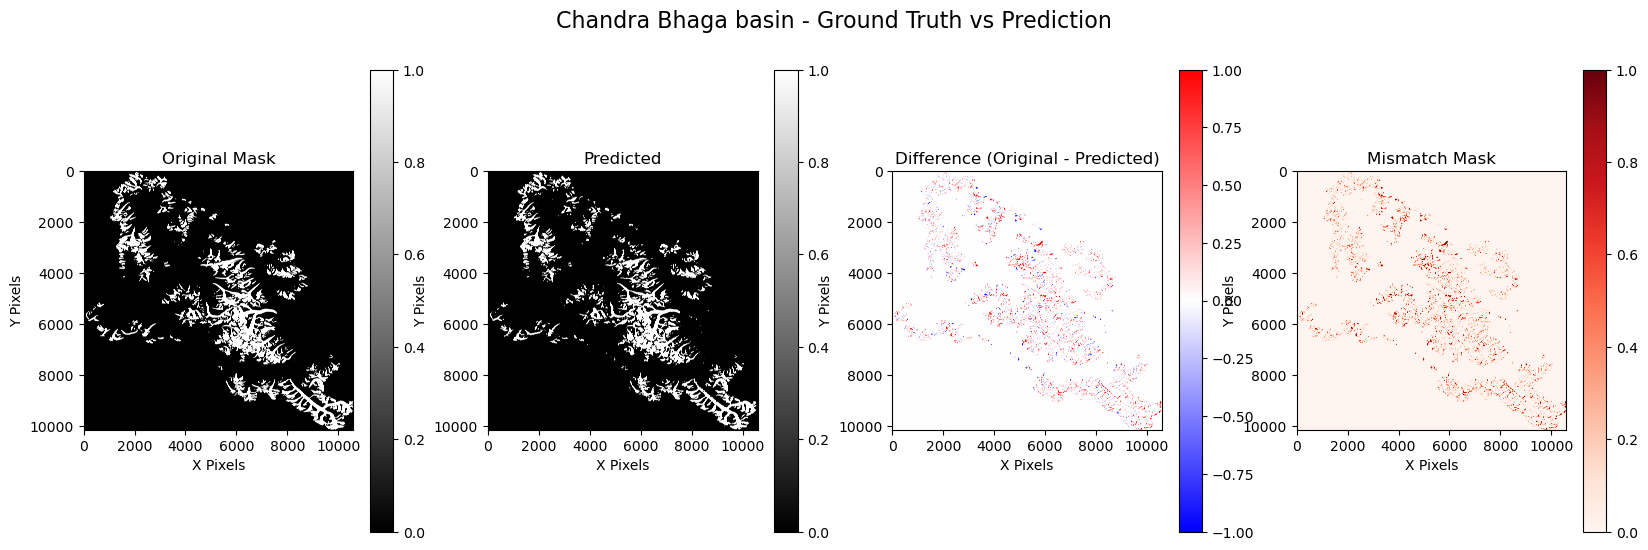

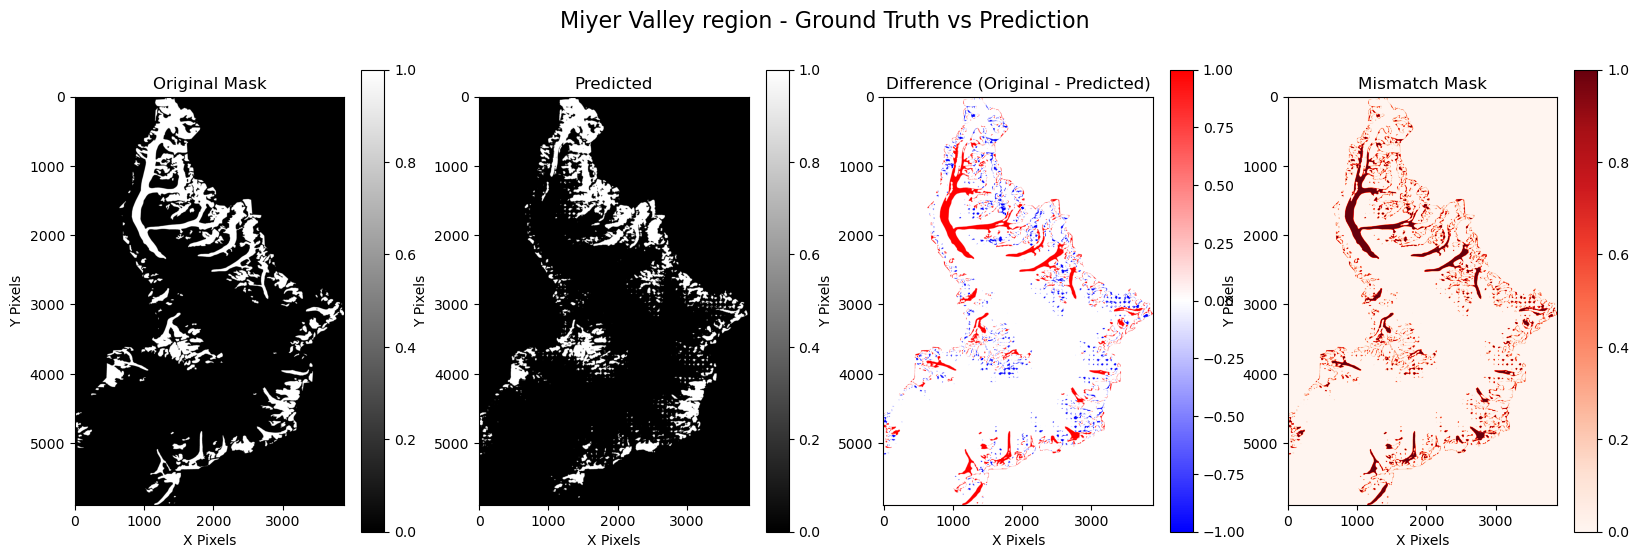

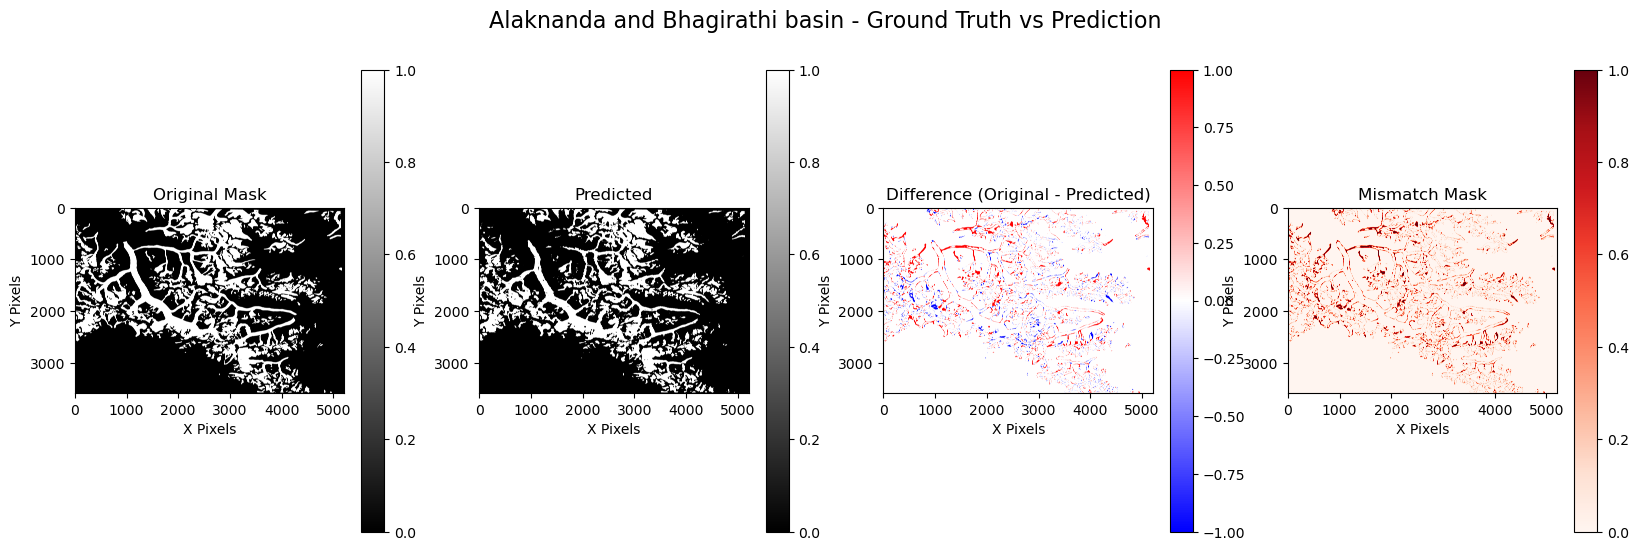

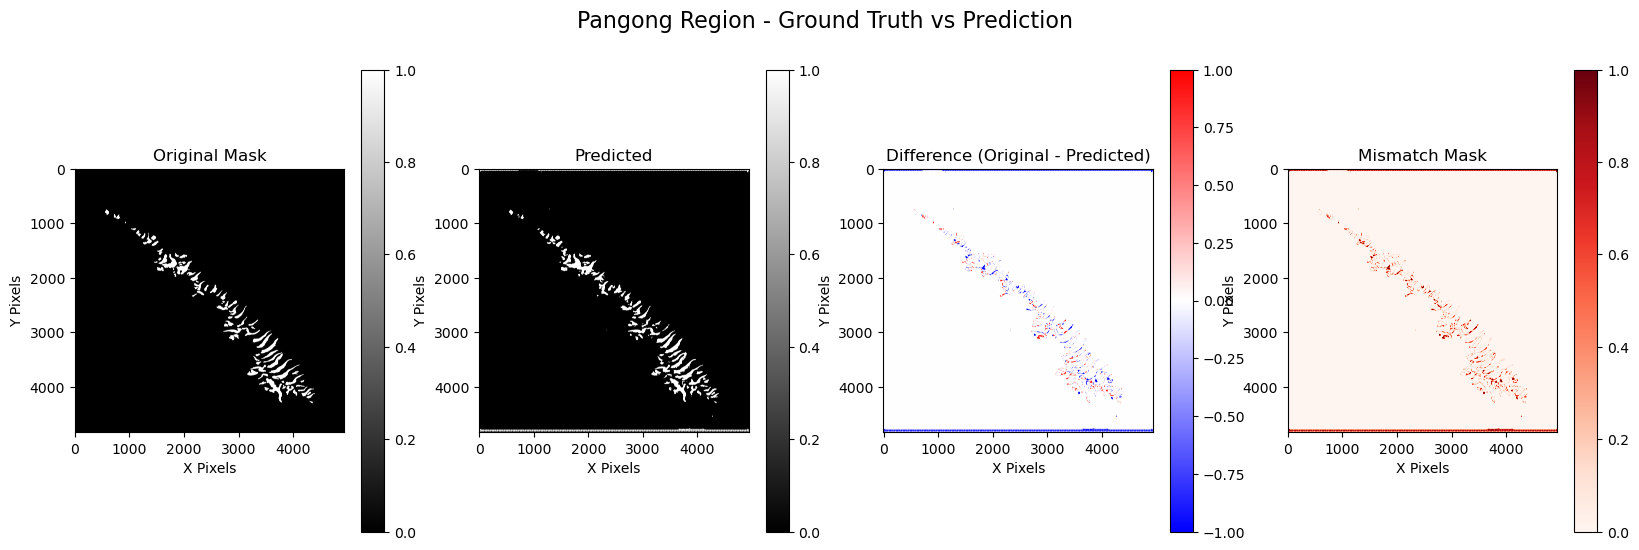

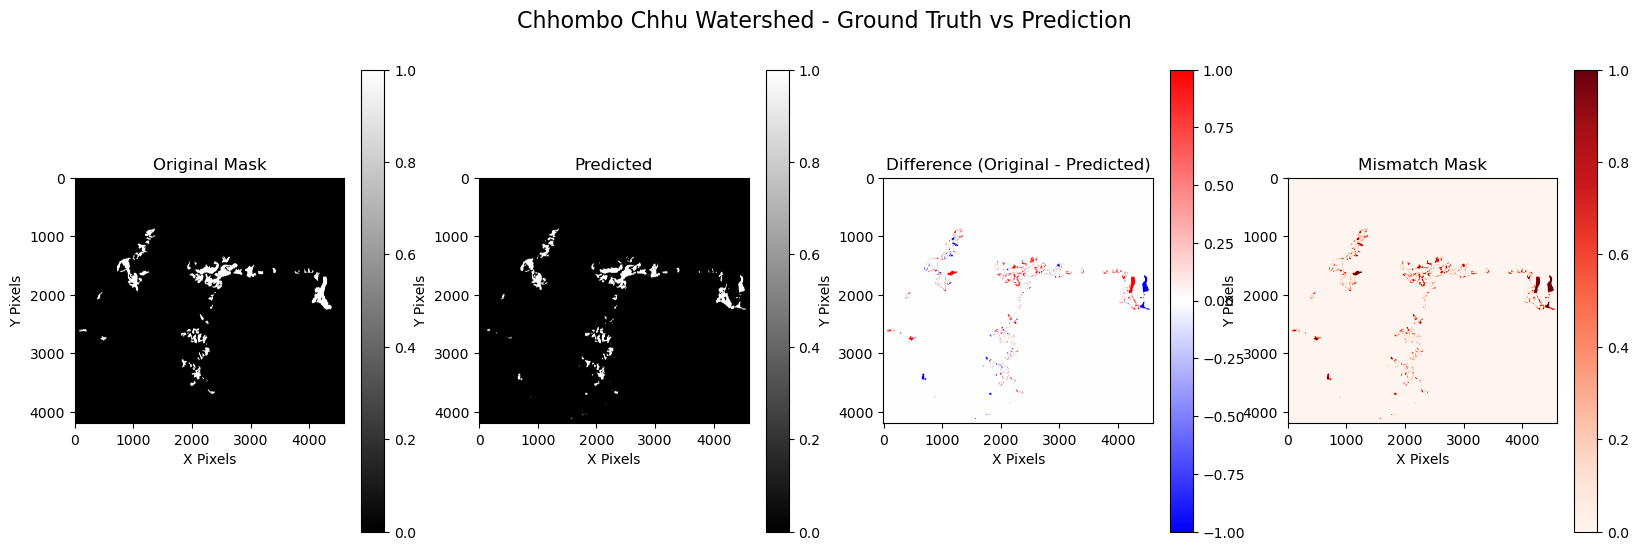

In [34]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling
import os

data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/raster_cb__normalized_6band_predicted_raster.tif',
        'label': 'Chandra Bhaga basin'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/cb_vali_normalized_128_6band_predicted_raster.tif',
        'label': 'Miyer Valley region'
    },
    {
        'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/NEW_UK_TIF_fixedB10_6band_predicted_raster.tif',
        'label': 'Alaknanda and Bhagirathi basin'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/KASHMIR_NORMALIZED_255_final_6band_predicted_raster.tif',
        'label': 'Pangong Region'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/sikkim_chaudhary_255_final_6band_predicted_raster.tif',
         'label': 'Chhombo Chhu Watershed'
    },
]


# Loop over each pair
for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted raster to match original mask dimensions
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    resampled_predicted_valid = resampled_predicted[valid_mask]

    # Compute metrics
    conf_matrix = confusion_matrix(original_mask_valid, resampled_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, resampled_predicted_valid)
    iou = jaccard_score(original_mask_valid, resampled_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, resampled_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, resampled_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, resampled_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, resampled_predicted_valid)

    # Print metrics
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Visualize - create new figure for each dataset
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Ground Truth vs Prediction", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])
    
    # Predicted
    im1 = axes[1].imshow(resampled_predicted, cmap='gray')
    axes[1].set_title("Predicted")
    plt.colorbar(im1, ax=axes[1])
    
    # Difference
    diff = original_mask.astype(int) - resampled_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Original - Predicted)")
    plt.colorbar(im2, ax=axes[2])
    
    # Difference Mask
    diff_mask = (original_mask != resampled_predicted).astype(int)
    im3 = axes[3].imshow(diff_mask, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

# Show all plots at once
plt.show()

In [35]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score,
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling
from scipy.ndimage import binary_fill_holes, binary_opening, binary_closing
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# -------------------
# CONFIG
# -------------------
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/raster_cb__normalized_6band_predicted_raster.tif',
        'label': 'Chandra Bhaga basin'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/cb_vali_normalized_128_6band_predicted_raster.tif',
        'label': 'Miyer Valley region'
    },
    {
        'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/NEW_UK_TIF_fixedB10_6band_predicted_raster.tif',
        'label': 'Alaknanda and Bhagirathi basin'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/KASHMIR_NORMALIZED_255_final_6band_predicted_raster.tif',
        'label': 'Pangong Region'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/sikkim_chaudhary_255_final_6band_predicted_raster.tif',
         'label': 'Chhombo Chhu Watershed'
    },
]

# -------------------
# FUNCTIONS
# -------------------
def clean_pred_mask(pred, ref_mask):
    """
    Clean predicted mask:
    - Fill voids
    - Remove small speckles
    - Align with reference mask (clip extent)
    """
    # Fill voids (holes inside glaciers)
    pred_filled = binary_fill_holes(pred > 0).astype(np.uint8)

    # Morphological smoothing (remove tiny polygons, close gaps)
    pred_clean = binary_opening(pred_filled, structure=np.ones((3, 3))).astype(np.uint8)
    pred_clean = binary_closing(pred_clean, structure=np.ones((3, 3))).astype(np.uint8)

    # Clip to reference mask extent (so no overflow)
    pred_clean = np.where(ref_mask > 0, pred_clean, 0)

    return pred_clean

def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    acc = accuracy_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    precision = precision_score(y_true, y_pred, average="binary")
    kappa = cohen_kappa_score(y_true, y_pred)
    return cm, acc, iou, f1, recall, precision, kappa

def make_diff_map(gt, pred):
    """
    TP = 1 (green), TN = 0 (white), FP = 2 (red), FN = 3 (blue)
    """
    diff = np.zeros_like(gt, dtype=np.uint8)
    diff[(gt == 1) & (pred == 1)] = 1  # TP
    diff[(gt == 0) & (pred == 0)] = 0  # TN
    diff[(gt == 0) & (pred == 1)] = 2  # FP
    diff[(gt == 1) & (pred == 0)] = 3  # FN
    return diff

# Colormap for difference
diff_cmap = ListedColormap(["white", "green", "red", "blue"])
legend_elements = [
    Patch(facecolor="white", edgecolor="black", label="TN"),
    Patch(facecolor="green", edgecolor="black", label="TP"),
    Patch(facecolor="red", edgecolor="black", label="FP"),
    Patch(facecolor="blue", edgecolor="black", label="FN"),
]

# -------------------
# PROCESSING LOOP
# -------------------
results = []
originals = []
predicteds = []
diffmaps = []

for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1).astype(np.uint8)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1).astype(np.uint8)

    # Resample predicted raster to match original mask
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Clean predicted mask (fill voids + merge)
    cleaned_pred = clean_pred_mask(resampled_predicted, original_mask)

    # Flatten for metrics
    y_true = original_mask.flatten()
    y_pred = cleaned_pred.flatten()

    # Compute metrics
    cm, acc, iou, f1, recall, precision, kappa = compute_metrics(y_true, y_pred)
    results.append((pair['label'], acc, iou, f1, recall, precision, kappa))
    print(f"Confusion Matrix:\n{cm}")
    print(f"Acc={acc:.4f}, IoU={iou:.4f}, F1={f1:.4f}, Recall={recall:.4f}, Precision={precision:.4f}, Kappa={kappa:.4f}")

    # Save arrays for plotting
    originals.append(original_mask)
    predicteds.append(cleaned_pred)
    diffmaps.append(make_diff_map(original_mask, cleaned_pred))

# STACKED MULTI-PANEL PLOT
# -------------------
n_basins = len(data_pairs)
fig, axes = plt.subplots(n_basins, 3, figsize=(15, 4*n_basins))

for i, (pair, orig, pred, diff, metrics) in enumerate(zip(data_pairs, originals, predicteds, diffmaps, results)):
    label, acc, iou, f1, recall, precision, kappa = metrics

    # Original
    axes[i, 0].imshow(orig, cmap="gray")
    axes[i, 0].set_title(f"{pair['label']} - Original")
    axes[i, 0].axis("off")

    # Predicted
    axes[i, 1].imshow(pred, cmap="gray")
    axes[i, 1].set_title("Predicted (Cleaned)")
    axes[i, 1].axis("off")

    # Difference
    axes[i, 2].imshow(diff, cmap=diff_cmap, vmin=0, vmax=3)
    axes[i, 2].set_title("Difference (TP/TN/FP/FN)")
    axes[i, 2].axis("off")

    # Metrics text
    metrics_text = (f"Acc={acc:.3f}\nIoU={iou:.3f}\nF1={f1:.3f}\n"
                    f"Rec={recall:.3f}\nKappa={kappa:.3f}")
    axes[i, 2].text(1.02, 0.5, metrics_text, transform=axes[i, 2].transAxes,
                    fontsize=10, va="center", ha="left",
                    bbox=dict(facecolor="white", alpha=0.7))

# Add legend once (bottom of figure)
fig.legend(handles=legend_elements, loc="lower center", ncol=4, fontsize=12, frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
out_path = "sarvesh/mlandsnet_sato_new/figures_tp_tf/mlandsnet_6_FIG.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.close(fig)

print(f"\n✅ Combined stacked figure saved at {out_path}")


=== Processing Chandra Bhaga basin ===
Confusion Matrix:
[[95356225        0]
 [ 1624054 10370551]]
Acc=0.9849, IoU=0.8646, F1=0.9274, Recall=0.8646, Precision=1.0000, Kappa=0.9190

=== Processing Miyer Valley region ===
Confusion Matrix:
[[20395538        0]
 [  901597  1634529]]
Acc=0.9607, IoU=0.6445, F1=0.7838, Recall=0.6445, Precision=1.0000, Kappa=0.7633

=== Processing Alaknanda and Bhagirathi basin ===
Confusion Matrix:
[[13713712        0]
 [  685177  4341846]]
Acc=0.9634, IoU=0.8637, F1=0.9269, Recall=0.8637, Precision=1.0000, Kappa=0.9027

=== Processing Pangong Region ===
Confusion Matrix:
[[23263577        0]
 [   79047   537336]]
Acc=0.9967, IoU=0.8718, F1=0.9315, Recall=0.8718, Precision=1.0000, Kappa=0.9298

=== Processing Chhombo Chhu Watershed ===
Confusion Matrix:
[[18780051        0]
 [  129122   374839]]
Acc=0.9933, IoU=0.7438, F1=0.8531, Recall=0.7438, Precision=1.0000, Kappa=0.8497

✅ Combined stacked figure saved at sarvesh/mlandsnet_sato_new/figures_tp_tf/mlan

In [36]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score,
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling
from scipy.ndimage import binary_fill_holes, binary_opening, binary_closing
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# -------------------
# CONFIG
# -------------------
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/raster_cb__normalized_6band_predicted_raster.tif',
        'label': 'Chandra Bhaga basin'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/cb_vali_normalized_128_6band_predicted_raster.tif',
        'label': 'Miyer Valley region'
    },
    {
        'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/NEW_UK_TIF_fixedB10_6band_predicted_raster.tif',
        'label': 'Alaknanda and Bhagirathi basin'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/KASHMIR_NORMALIZED_255_final_6band_predicted_raster.tif',
        'label': 'Pangong Region'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/sikkim_chaudhary_255_final_6band_predicted_raster.tif',
        'label': 'Chhombo Chhu Watershed'
    },
]

# -------------------
# FUNCTIONS
# -------------------
def clean_pred_mask(pred, ref_mask):
    """Fill voids, smooth, and clip prediction."""
    pred_filled = binary_fill_holes(pred > 0).astype(np.uint8)
    pred_clean = binary_opening(pred_filled, structure=np.ones((3, 3))).astype(np.uint8)
    pred_clean = binary_closing(pred_clean, structure=np.ones((3, 3))).astype(np.uint8)
    pred_clean = np.where(ref_mask > 0, pred_clean, 0)
    return pred_clean

def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    acc = accuracy_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    precision = precision_score(y_true, y_pred, average="binary")
    kappa = cohen_kappa_score(y_true, y_pred)
    return cm, acc, iou, f1, recall, precision, kappa

def make_diff_map(gt, pred):
    """TP=1(green), TN=0(white), FP=2(red), FN=3(blue)."""
    diff = np.zeros_like(gt, dtype=np.uint8)
    diff[(gt == 1) & (pred == 1)] = 1  # TP
    diff[(gt == 0) & (pred == 0)] = 0  # TN
    diff[(gt == 0) & (pred == 1)] = 2  # FP
    diff[(gt == 1) & (pred == 0)] = 3  # FN
    return diff

# Colormap + legend
diff_cmap = ListedColormap(["white", "green", "red", "blue"])
legend_elements = [
    Patch(facecolor="white", edgecolor="black", label="TN"),
    Patch(facecolor="green", edgecolor="black", label="TP"),
    Patch(facecolor="red", edgecolor="black", label="FP"),
    Patch(facecolor="blue", edgecolor="black", label="FN"),
]

# -------------------
# PROCESSING LOOP
# -------------------
results, originals, predicteds, diffmaps = [], [], [], []

for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1).astype(np.uint8)
        original_profile = src.profile

    # Load and resample predicted
    with rasterio.open(pair['predicted']) as src_pred:
        predicted_raster = src_pred.read(1).astype(np.uint8)
        resampled_predicted = np.empty_like(original_mask)
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Clean predictions
    cleaned_pred = clean_pred_mask(resampled_predicted, original_mask)

    # Metrics
    y_true, y_pred = original_mask.flatten(), cleaned_pred.flatten()
    cm, acc, iou, f1, recall, precision, kappa = compute_metrics(y_true, y_pred)
    results.append((pair['label'], acc, iou, f1, recall, precision, kappa))
    print(f"Confusion Matrix:\n{cm}")
    print(f"Acc={acc:.4f}, IoU={iou:.4f}, F1={f1:.4f}, "
          f"Recall={recall:.4f}, Precision={precision:.4f}, Kappa={kappa:.4f}")

    originals.append(original_mask)
    predicteds.append(cleaned_pred)
    diffmaps.append(make_diff_map(original_mask, cleaned_pred))

# -------------------
# MULTI-PANEL FIGURE
# -------------------
n_basins = len(data_pairs)
fig, axes = plt.subplots(n_basins, 3, figsize=(15, 4*n_basins))

for i, (pair, orig, pred, diff, metrics) in enumerate(zip(data_pairs, originals, predicteds, diffmaps, results)):
    label, acc, iou, f1, recall, precision, kappa = metrics

    # Original
    axes[i, 0].imshow(orig, cmap="gray")
    axes[i, 0].set_title(f"{pair['label']} - Original")
    axes[i, 0].axis("off")

    # Predicted + overlay FP (red)
    axes[i, 1].imshow(pred, cmap="gray")
    fp_mask = (diff == 2)
    axes[i, 1].imshow(np.ma.masked_where(~fp_mask, fp_mask),
                      cmap=ListedColormap(["red"]), alpha=0.6)
    axes[i, 1].set_title("Predicted (Cleaned + FP overlay)")
    axes[i, 1].axis("off")

    # Difference full map
    axes[i, 2].imshow(diff, cmap=diff_cmap, vmin=0, vmax=3)
    axes[i, 2].set_title("Difference (TP/TN/FP/FN)")
    axes[i, 2].axis("off")

    # Metrics text on difference map
    metrics_text = (f"Acc={acc:.3f}\nIoU={iou:.3f}\nF1={f1:.3f}\n"
                    f"Rec={recall:.3f}\nKappa={kappa:.3f}")
    axes[i, 2].text(1.02, 0.5, metrics_text, transform=axes[i, 2].transAxes,
                    fontsize=10, va="center", ha="left",
                    bbox=dict(facecolor="white", alpha=0.7))

# Legend
fig.legend(handles=legend_elements, loc="lower center", ncol=4, fontsize=12, frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
out_path = "sarvesh/mlandsnet_sato_new/figures_tp_tf/mlandsnet_6_FIG_with_FPoverlay.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.close(fig)

print(f"\n✅ Combined stacked figure with FP overlay saved at {out_path}")



=== Processing Chandra Bhaga basin ===
Confusion Matrix:
[[95356225        0]
 [ 1624054 10370551]]
Acc=0.9849, IoU=0.8646, F1=0.9274, Recall=0.8646, Precision=1.0000, Kappa=0.9190

=== Processing Miyer Valley region ===
Confusion Matrix:
[[20395538        0]
 [  901597  1634529]]
Acc=0.9607, IoU=0.6445, F1=0.7838, Recall=0.6445, Precision=1.0000, Kappa=0.7633

=== Processing Alaknanda and Bhagirathi basin ===
Confusion Matrix:
[[13713712        0]
 [  685177  4341846]]
Acc=0.9634, IoU=0.8637, F1=0.9269, Recall=0.8637, Precision=1.0000, Kappa=0.9027

=== Processing Pangong Region ===
Confusion Matrix:
[[23263577        0]
 [   79047   537336]]
Acc=0.9967, IoU=0.8718, F1=0.9315, Recall=0.8718, Precision=1.0000, Kappa=0.9298

=== Processing Chhombo Chhu Watershed ===
Confusion Matrix:
[[18780051        0]
 [  129122   374839]]
Acc=0.9933, IoU=0.7438, F1=0.8531, Recall=0.7438, Precision=1.0000, Kappa=0.8497

✅ Combined stacked figure with FP overlay saved at sarvesh/mlandsnet_sato_new/fi

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
from scipy.ndimage import binary_fill_holes, binary_opening, binary_closing
from sklearn.metrics import jaccard_score, accuracy_score
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import textwrap

# -------------------
# DATA CONFIG
# -------------------
data_pairs_18 = [
    {'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/raster_cb__normalized_predicted_raster.tif',
     'label': 'Chandra Bhaga basin'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/cb_vali_normalized_128_predicted_raster.tif',
     'label': 'Miyer Valley region'},
    {'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/NEW_UK_TIF_fixedB10_predicted_raster.tif',
     'label': 'Alaknanda and Bhagirathi basin'},
    {'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/KASHMIR_NORMALIZED_255_final_predicted_raster.tif',
     'label': 'Pangong Region'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/sikkim_chaudhary_255_final_predicted_raster.tif',
     'label': 'Chhombo Chhu Watershed'},
]

data_pairs_6 = [
    {'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/raster_cb__normalized_6band_predicted_raster.tif',
     'label': 'Chandra Bhaga basin'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/cb_vali_normalized_128_6band_predicted_raster.tif',
     'label': 'Miyer Valley region'},
    {'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/NEW_UK_TIF_fixedB10_6band_predicted_raster.tif',
     'label': 'Alaknanda and Bhagirathi basin'},
    {'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/KASHMIR_NORMALIZED_255_final_6band_predicted_raster.tif',
     'label': 'Pangong Region'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/sikkim_chaudhary_255_final_6band_predicted_raster.tif',
     'label': 'Chhombo Chhu Watershed'},
]

desired_order = [
    'Chandra Bhaga basin',
    'Pangong Region',
    'Chhombo Chhu Watershed',
    'Miyer Valley region',
    'Alaknanda and Bhagirathi basin',
]

# -------------------
# FUNCTIONS
# -------------------
def clean_pred_mask(pred, ref_mask):
    pred_filled = binary_fill_holes(pred > 0).astype(np.uint8)
    pred_clean = binary_opening(pred_filled, structure=np.ones((3, 3))).astype(np.uint8)
    pred_clean = binary_closing(pred_clean, structure=np.ones((3, 3))).astype(np.uint8)
    return np.where(ref_mask > 0, pred_clean, 0).astype(np.uint8)

def load_and_resample(mask_path, pred_path):
    with rasterio.open(mask_path) as src:
        mask = src.read(1).astype(np.uint8)
        profile = src.profile
        transform = src.transform
        crs = src.crs
    with rasterio.open(pred_path) as src_pred:
        resampled_pred = np.empty_like(mask, dtype=np.uint8)
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_pred,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=profile['transform'],
            dst_crs=profile['crs'],
            resampling=Resampling.nearest
        )
    return mask, clean_pred_mask(resampled_pred, mask), transform, crs

def make_diff_map_no_fp(gt, pred):
    diff = np.zeros_like(gt, dtype=np.uint8)
    diff[(gt == 1) & (pred == 1)] = 1  # TP
    diff[(gt == 1) & (pred == 0)] = 3  # FN
    return diff

def compute_metrics(y_true, y_pred):
    return accuracy_score(y_true, y_pred), jaccard_score(y_true, y_pred, average="binary")

def extent_from_transform(transform, width, height, make_square=False):
    left, top = transform * (0, 0)
    right, bottom = transform * (width, height)
    if not make_square:
        return [left, right, bottom, top]
    px_w, px_h = transform.a, abs(transform.e)
    max_side = max(width * px_w, height * px_h)
    return [left, left + max_side, top - max_side, top]

# -------------------
# PLOT CONFIG
# -------------------
diff_cmap = ListedColormap(["white", "green", "white", "blue"])
legend_elements = [
    Patch(facecolor="green", edgecolor="black", label="Matched (TP)"),
    Patch(facecolor="blue", edgecolor="black", label="Mismatched (FN)")
]
col_titles = ["Original Mask", "Visualization (18)", "Visualization (6)"]

# -------------------
# PROCESS DATA
# -------------------
pairs18_by_label = {p['label']: p for p in data_pairs_18}
pairs6_by_label = {p['label']: p for p in data_pairs_6}
ordered_labels = [lab for lab in desired_order if lab in pairs18_by_label and lab in pairs6_by_label]

originals, diffs_18, diffs_6, metrics_18, metrics_6, transforms = [], [], [], [], [], []

for label in ordered_labels:
    mask, pred18, transform, _ = load_and_resample(pairs18_by_label[label]['mask'], pairs18_by_label[label]['predicted'])
    _, pred6, _, _ = load_and_resample(pairs6_by_label[label]['mask'], pairs6_by_label[label]['predicted'])
    originals.append(mask)
    transforms.append(transform)
    diffs_18.append(make_diff_map_no_fp(mask, pred18))
    diffs_6.append(make_diff_map_no_fp(mask, pred6))
    metrics_18.append(compute_metrics(mask.flatten(), pred18.flatten()))
    metrics_6.append(compute_metrics(mask.flatten(), pred6.flatten()))

# -------------------
# PLOT FIGURE
# -------------------
n_basins = len(ordered_labels)
fig, axes = plt.subplots(n_basins, 3, figsize=(14, 3.5 * n_basins), subplot_kw={'aspect': 'equal'})

plt.tight_layout(rect=[0, 0.06, 1, 0.95])

# Column headings above first row
for j, title in enumerate(col_titles):
    ax_pos = axes[0, j].get_position()
    heading_y = ax_pos.y1 + 0.01
    fig.text(ax_pos.x0 + ax_pos.width / 2, heading_y,
             title,
             ha="center", va="bottom",
             fontsize=12, weight="bold",
             bbox=dict(facecolor="white", edgecolor="black"))

# Plot subplots
for i, (label, orig, d18, d6, tr, m18, m6) in enumerate(zip(
        ordered_labels, originals, diffs_18, diffs_6, transforms, metrics_18, metrics_6)):

    acc18, iou18 = m18
    acc6, iou6 = m6
    h, w = orig.shape
    extent = extent_from_transform(tr, w, h, make_square=("Miyer Valley region" in label))

    lon_ticks = np.round(np.linspace(extent[0], extent[1], 3), 2)
    lat_ticks = np.round(np.linspace(extent[2], extent[3], 3), 2)

    # Col 1
    axes[i, 0].imshow(orig, cmap="gray", extent=extent)
    axes[i, 0].set_xticks(lon_ticks)
    axes[i, 0].set_yticks(lat_ticks)
    axes[i, 0].set_xlabel("Longitude")
    axes[i, 0].set_ylabel("Latitude")

    # Col 2
    axes[i, 1].imshow(d18, cmap=diff_cmap, vmin=0, vmax=3, extent=extent)
    axes[i, 1].set_xticks(lon_ticks)
    axes[i, 1].set_yticks(lat_ticks)
    for spine in axes[i, 1].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    axes[i, 1].text(0.98, 0.98, f"Acc={acc18:.3f}\nIoU={iou18:.3f}",
                    transform=axes[i, 1].transAxes, fontsize=12,
                    va="top", ha="right",
                    bbox=dict(facecolor="white", alpha=0.8, edgecolor='black'))

    # Col 3
    axes[i, 2].imshow(d6, cmap=diff_cmap, vmin=0, vmax=3, extent=extent)
    axes[i, 2].set_xticks(lon_ticks)
    axes[i, 2].set_yticks(lat_ticks)
    for spine in axes[i, 2].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    axes[i, 2].text(0.98, 0.98, f"Acc={acc6:.3f}\nIoU={iou6:.3f}",
                    transform=axes[i, 2].transAxes, fontsize=12,
                    va="top", ha="right",
                    bbox=dict(facecolor="white", alpha=0.8, edgecolor='black'))

# Legend just below last row
last_row_pos = axes[-1, 0].get_position()
legend_y = last_row_pos.y0 - 0.05
fig.legend(handles=legend_elements,
           loc="lower center",
           bbox_to_anchor=(0.5, legend_y),
           ncol=2, fontsize=12, frameon=True)

out_path = "sarvesh/mlandsnet_sato_new/figures_tp_tf/m_landsnet_compare.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.close(fig)

print(f"\n✅ Saved figure at {out_path}")



✅ Saved figure at sarvesh/mlandsnet_sato_new/figures_tp_tf/m_landsnet_compare.png


In [51]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
from scipy.ndimage import binary_fill_holes, binary_opening, binary_closing
from sklearn.metrics import jaccard_score, accuracy_score
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import textwrap

# -------------------
# DATA CONFIG
# -------------------
data_pairs_18 = [
    {'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/raster_cb__normalized_predicted_raster.tif',
     'label': 'Chandra Bhaga basin'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/cb_vali_normalized_128_predicted_raster.tif',
     'label': 'Miyer Valley region'},
    {'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/NEW_UK_TIF_fixedB10_predicted_raster.tif',
     'label': 'Alaknanda and Bhagirathi basin'},
    {'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/KASHMIR_NORMALIZED_255_final_predicted_raster.tif',
     'label': 'Pangong Region'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/sikkim_chaudhary_255_final_predicted_raster.tif',
     'label': 'Chhombo Chhu Watershed'},
]

data_pairs_6 = [
    {'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/raster_cb__normalized_6band_predicted_raster.tif',
     'label': 'Chandra Bhaga basin'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/cb_vali_normalized_128_6band_predicted_raster.tif',
     'label': 'Miyer Valley region'},
    {'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/NEW_UK_TIF_fixedB10_6band_predicted_raster.tif',
     'label': 'Alaknanda and Bhagirathi basin'},
    {'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/KASHMIR_NORMALIZED_255_final_6band_predicted_raster.tif',
     'label': 'Pangong Region'},
    {'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
     'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/sikkim_chaudhary_255_final_6band_predicted_raster.tif',
     'label': 'Chhombo Chhu Watershed'},
]

desired_order = [
    'Chandra Bhaga basin',
    'Pangong Region',
    'Chhombo Chhu Watershed',
    'Miyer Valley region',
    'Alaknanda and Bhagirathi basin',
]

# -------------------
# FUNCTIONS
# -------------------
def clean_pred_mask(pred, ref_mask):
    pred_filled = binary_fill_holes(pred > 0).astype(np.uint8)
    pred_clean = binary_opening(pred_filled, structure=np.ones((3, 3))).astype(np.uint8)
    pred_clean = binary_closing(pred_clean, structure=np.ones((3, 3))).astype(np.uint8)
    return np.where(ref_mask > 0, pred_clean, 0).astype(np.uint8)

def load_and_resample(mask_path, pred_path):
    with rasterio.open(mask_path) as src:
        mask = src.read(1).astype(np.uint8)
        profile = src.profile
        transform = src.transform
        crs = src.crs
    with rasterio.open(pred_path) as src_pred:
        resampled_pred = np.empty_like(mask, dtype=np.uint8)
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_pred,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=profile['transform'],
            dst_crs=profile['crs'],
            resampling=Resampling.nearest
        )
    return mask, clean_pred_mask(resampled_pred, mask), transform, crs

def make_diff_map_no_fp(gt, pred):
    diff = np.zeros_like(gt, dtype=np.uint8)
    diff[(gt == 1) & (pred == 1)] = 1  # TP
    diff[(gt == 1) & (pred == 0)] = 3  # FN
    return diff

def compute_metrics(y_true, y_pred):
    return accuracy_score(y_true, y_pred), jaccard_score(y_true, y_pred, average="binary")

def extent_from_transform(transform, width, height, make_square=False):
    left, top = transform * (0, 0)
    right, bottom = transform * (width, height)
    if not make_square:
        return [left, right, bottom, top]
    px_w, px_h = transform.a, abs(transform.e)
    max_side = max(width * px_w, height * px_h)
    return [left, left + max_side, top - max_side, top]

def wrap_label(label, width=25):
    return "\n".join(textwrap.wrap(label, width=width))

# -------------------
# PLOT CONFIG
# -------------------
diff_cmap = ListedColormap(["white", "green", "white", "blue"])
legend_elements = [
    Patch(facecolor="green", edgecolor="black", label="Matched (TP)"),
    Patch(facecolor="blue", edgecolor="black", label="Mismatched (FN)")
]
col_titles = ["Original Mask", "Visualization (18)", "Visualization (6)"]

# -------------------
# PROCESS DATA
# -------------------
pairs18_by_label = {p['label']: p for p in data_pairs_18}
pairs6_by_label = {p['label']: p for p in data_pairs_6}
ordered_labels = [lab for lab in desired_order if lab in pairs18_by_label and lab in pairs6_by_label]

originals, diffs_18, diffs_6, metrics_18, metrics_6, transforms = [], [], [], [], [], []

for label in ordered_labels:
    mask, pred18, transform, _ = load_and_resample(pairs18_by_label[label]['mask'], pairs18_by_label[label]['predicted'])
    _, pred6, _, _ = load_and_resample(pairs6_by_label[label]['mask'], pairs6_by_label[label]['predicted'])
    originals.append(mask)
    transforms.append(transform)
    diffs_18.append(make_diff_map_no_fp(mask, pred18))
    diffs_6.append(make_diff_map_no_fp(mask, pred6))
    metrics_18.append(compute_metrics(mask.flatten(), pred18.flatten()))
    metrics_6.append(compute_metrics(mask.flatten(), pred6.flatten()))

# -------------------
# PLOT FIGURE
# -------------------
n_basins = len(ordered_labels)
fig, axes = plt.subplots(n_basins, 3, figsize=(14, 3.5 * n_basins), subplot_kw={'aspect': 'equal'})

plt.tight_layout(rect=[0, 0.06, 1, 0.95])  # adjust subplots first

# Column headings outside subplots, above first row
for j, title in enumerate(col_titles):
    ax_pos = axes[0, j].get_position()  # position of first-row subplot in figure coords
    heading_y = ax_pos.y1 + 0.01        # small offset above the axes
    fig.text(ax_pos.x0 + ax_pos.width / 2, heading_y,
             title,
             ha="center", va="bottom",
             fontsize=12, weight="bold",
             bbox=dict(facecolor="white", edgecolor="black"))


# Plot subplots and metrics
for i, (label, orig, d18, d6, tr, m18, m6) in enumerate(zip(
        ordered_labels, originals, diffs_18, diffs_6, transforms, metrics_18, metrics_6)):

    acc18, iou18 = m18
    acc6, iou6 = m6
    h, w = orig.shape
    extent = extent_from_transform(tr, w, h, make_square=("Miyer Valley region" in label))

    axes[i, 0].imshow(orig, cmap="gray", extent=extent)
    axes[i, 0].set_xlabel("Longitude", fontsize=10)
    axes[i, 0].set_ylabel("Latitude", fontsize=10)

    axes[i, 1].imshow(d18, cmap=diff_cmap, vmin=0, vmax=3, extent=extent)
    for spine in axes[i, 1].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    axes[i, 1].text(0.02, 0.98, f"Acc={acc18:.3f}\nIoU={iou18:.3f}",
                    transform=axes[i, 1].transAxes, fontsize=10,
                    va="top", ha="left",
                    bbox=dict(facecolor="white", alpha=0.8, edgecolor='black'))

    axes[i, 2].imshow(d6, cmap=diff_cmap, vmin=0, vmax=3, extent=extent)
    for spine in axes[i, 2].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    axes[i, 2].text(0.02, 0.98, f"Acc={acc6:.3f}\nIoU={iou6:.3f}",
                    transform=axes[i, 2].transAxes, fontsize=10,
                    va="top", ha="left",
                    bbox=dict(facecolor="white", alpha=0.8, edgecolor='black'))

# Legend in row 5
fig.legend(handles=legend_elements, loc="lower center", ncol=2, fontsize=10, frameon=True)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])
out_path = "sarvesh/mlandsnet_sato_new/figures_tp_tf/NEWcomparison_titles_row_legend.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.close(fig)

print(f"\n✅ Saved figure at {out_path}")



✅ Saved figure at sarvesh/mlandsnet_sato_new/figures_tp_tf/NEWcomparison_titles_row_legend.png



=== Processing KASHMIR ===
Confusion Matrix:
[[22952248   311329]
 [   70990   545393]]
Overall Accuracy: 0.9840
Mean IoU: 0.7858
F1 Score: 0.8661
Recall: 0.9357
Precision: 0.8168
Cohen's Kappa: 0.7324

=== Processing SIKKIM ===
Confusion Matrix:
[[18699609    80442]
 [  140514   363447]]
Overall Accuracy: 0.9885
Mean IoU: 0.8051
F1 Score: 0.8805
Recall: 0.8584
Precision: 0.9057
Cohen's Kappa: 0.7610

=== Processing UTTRAKHAND ===
Confusion Matrix:
[[6039233  182353]
 [ 402539 2413375]]
Overall Accuracy: 0.9353
Mean IoU: 0.8583
F1 Score: 0.9229
Recall: 0.9139
Precision: 0.9336
Cohen's Kappa: 0.8458

=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[94308825  1047400]
 [ 1702474 10292131]]
Overall Accuracy: 0.9744
Mean IoU: 0.8804
F1 Score: 0.9339
Recall: 0.9235
Precision: 0.9450
Cohen's Kappa: 0.8678

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20278885   116653]
 [ 1009791  1526335]]
Overall Accuracy: 0.9509
Mean IoU: 0.7614
F1 Score: 0.8517
Recall: 0.7981
Precision

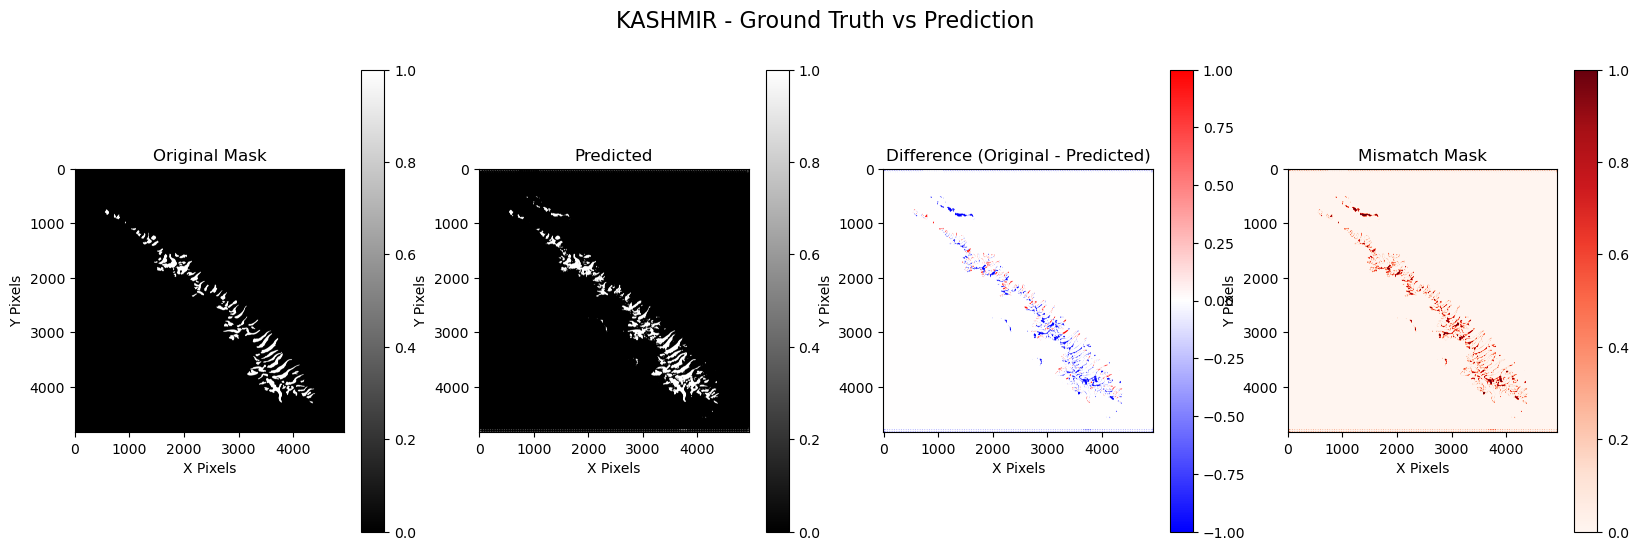

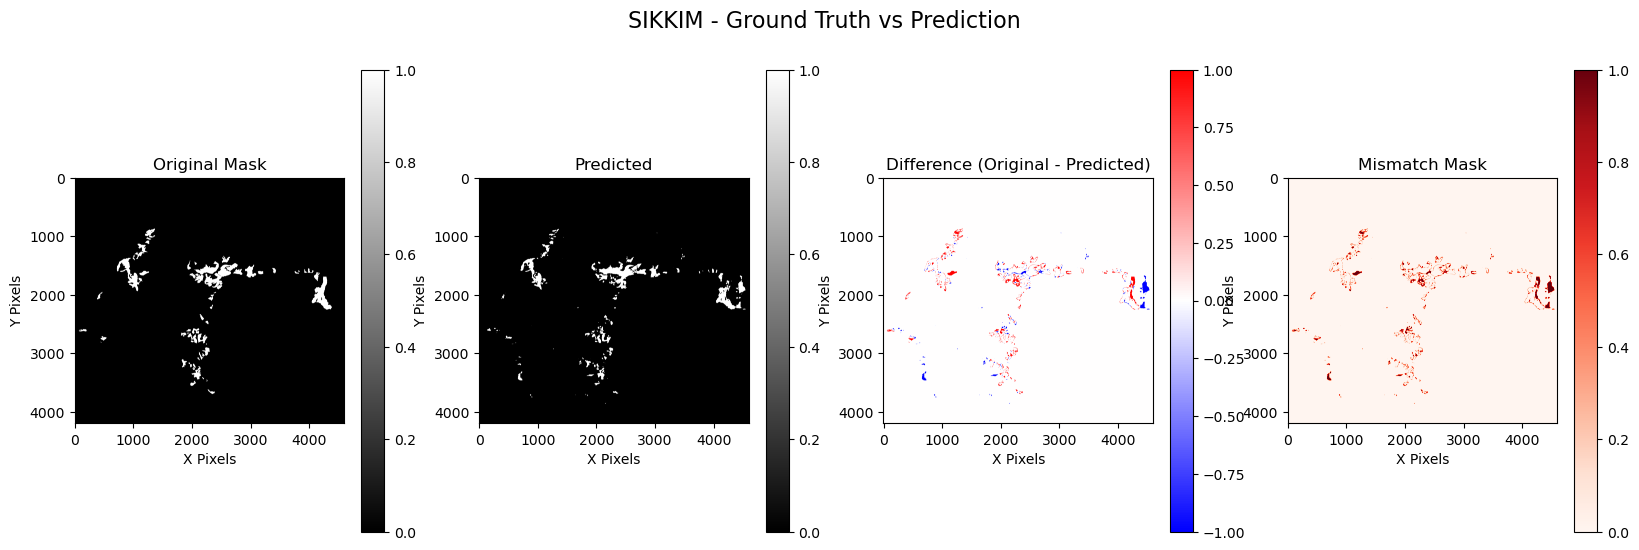

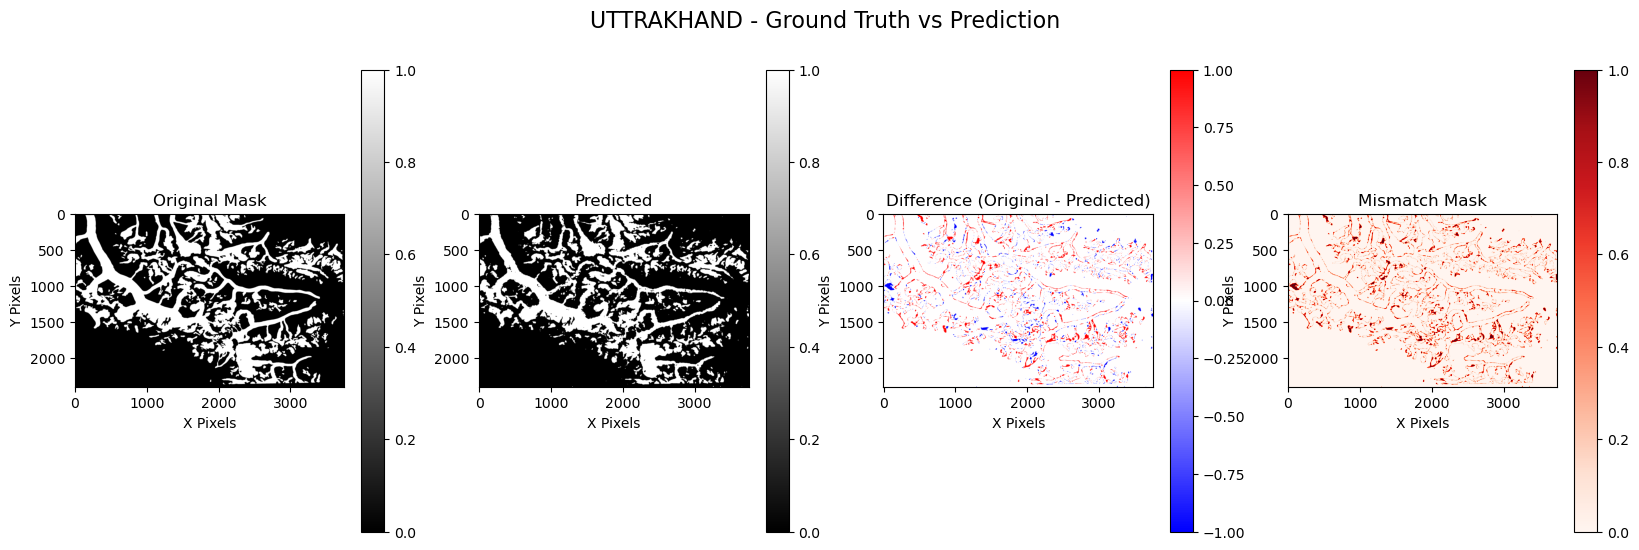

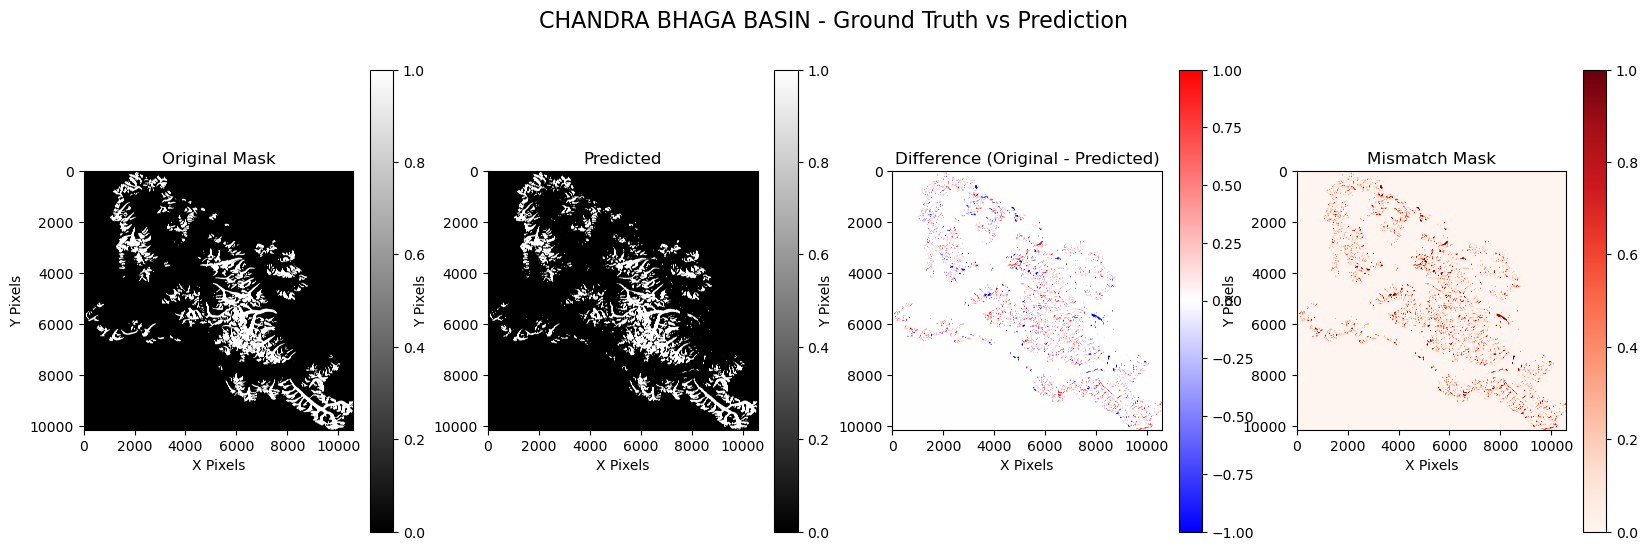

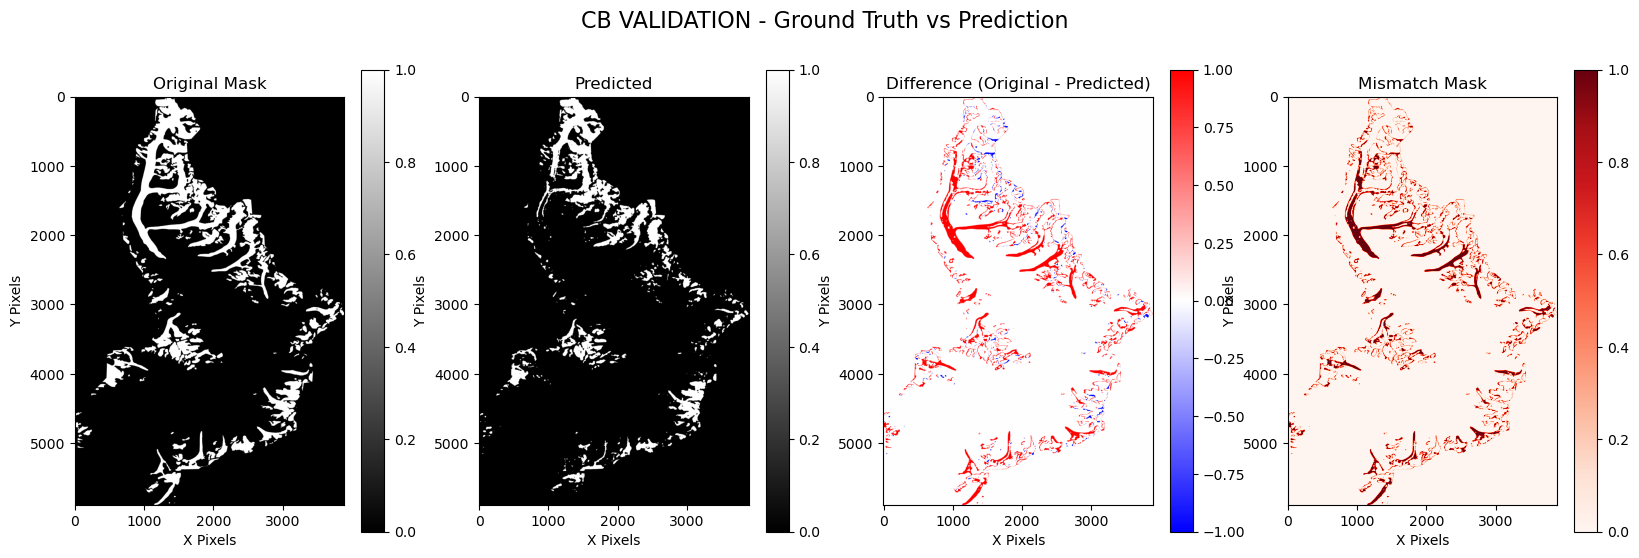

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling
import os

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/sf/KASHMIR_NORMALIZED_255_final_6band_predicted_raster.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/sf/sikkim_chaudhary_255_final_6band_predicted_raster.tif',
        'label': 'SIKKIM'
    },
    {
        'mask': 'sarvesh/chandrabasin/dataset/new/masklayersato.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/sf/raster_satopanth_normalized_6band_predicted_raster.tif',
        'label': 'UTTRAKHAND'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/sf/raster_cb__normalized_6band_predicted_raster.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/mlandsnet_all/top_6/top6rasters/sf/cb_vali_normalized_128_6band_predicted_raster.tif',
        'label': 'CB VALIDATION'
    },
]

# Loop over each pair
for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted raster to match original mask dimensions
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    resampled_predicted_valid = resampled_predicted[valid_mask]

    # Compute metrics
    conf_matrix = confusion_matrix(original_mask_valid, resampled_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, resampled_predicted_valid)
    iou = jaccard_score(original_mask_valid, resampled_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, resampled_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, resampled_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, resampled_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, resampled_predicted_valid)

    # Print metrics
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Visualize - create new figure for each dataset
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Ground Truth vs Prediction", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])
    
    # Predicted
    im1 = axes[1].imshow(resampled_predicted, cmap='gray')
    axes[1].set_title("Predicted")
    plt.colorbar(im1, ax=axes[1])
    
    # Difference
    diff = original_mask.astype(int) - resampled_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Original - Predicted)")
    plt.colorbar(im2, ax=axes[2])
    
    # Difference Mask
    diff_mask = (original_mask != resampled_predicted).astype(int)
    im3 = axes[3].imshow(diff_mask, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

# Show all plots at once
plt.show()


=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[95356225        0]
 [ 1926304 10068301]]
Overall Accuracy: 0.9821
Mean IoU: 0.9098
F1 Score: 0.9513
Recall: 0.9197
Precision: 0.9901
Cohen's Kappa: 0.9028

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20395538        0]
 [  956324  1579802]]
Overall Accuracy: 0.9583
Mean IoU: 0.7891
F1 Score: 0.8724
Recall: 0.8115
Precision: 0.9776
Cohen's Kappa: 0.7461

=== Processing uk ===
Confusion Matrix:
[[13713712        0]
 [  652173  4374850]]
Overall Accuracy: 0.9652
Mean IoU: 0.9124
F1 Score: 0.9537
Recall: 0.9351
Precision: 0.9773
Cohen's Kappa: 0.9076

=== Processing KASHMIR ===
Confusion Matrix:
[[23263577        0]
 [  110571   505812]]
Overall Accuracy: 0.9954
Mean IoU: 0.9079
F1 Score: 0.9495
Recall: 0.9103
Precision: 0.9976
Cohen's Kappa: 0.8991

=== Processing SIKKIM ===
Confusion Matrix:
[[18780051        0]
 [  132377   371584]]
Overall Accuracy: 0.9931
Mean IoU: 0.8652
F1 Score: 0.9226
Recall: 0.8687
Precision: 0.

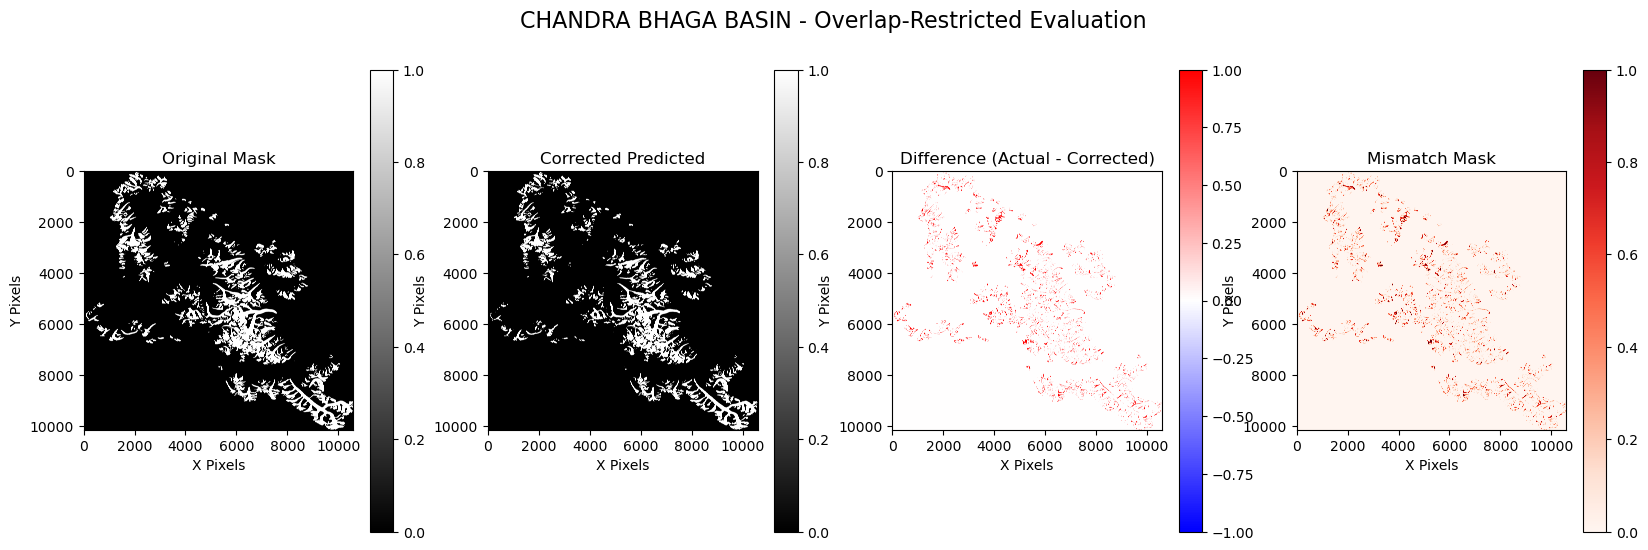

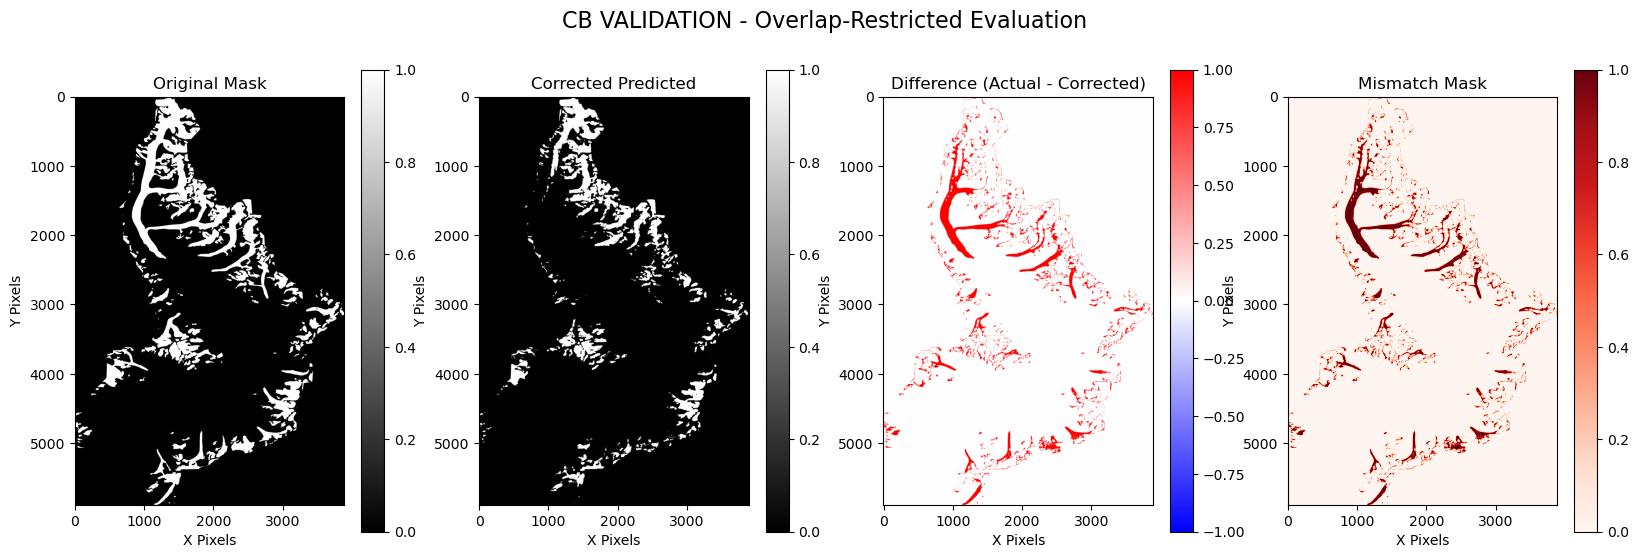

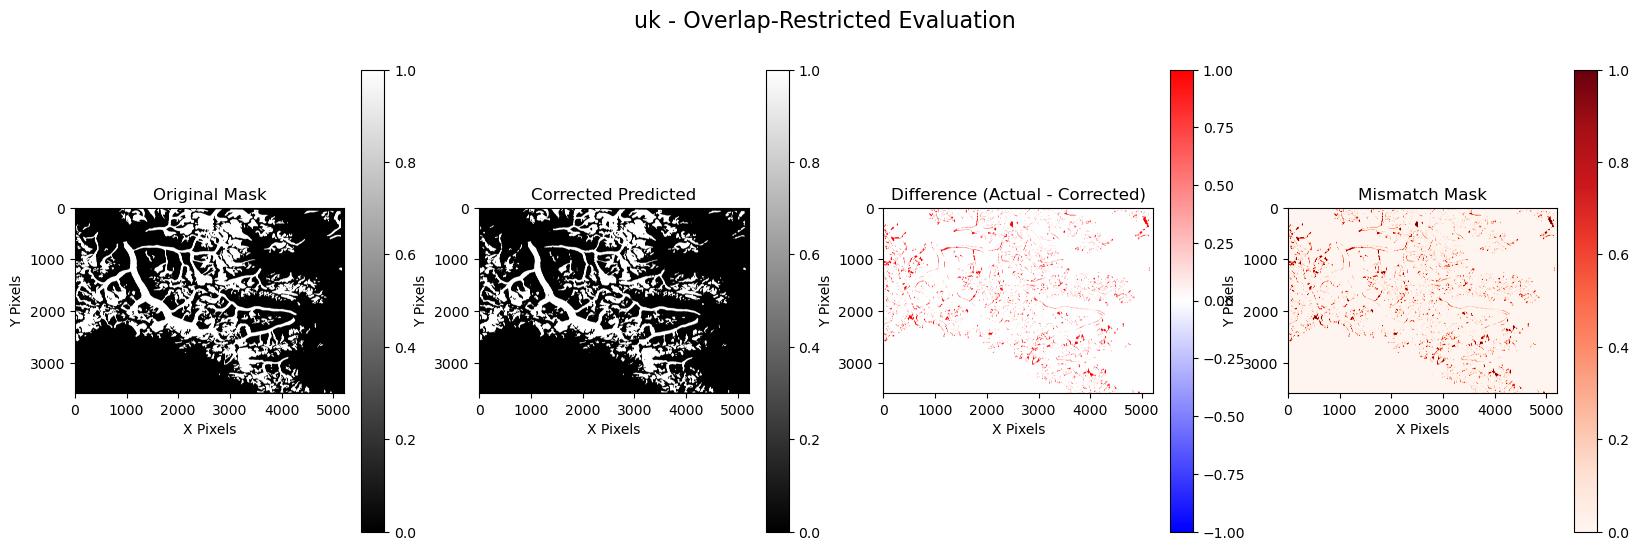

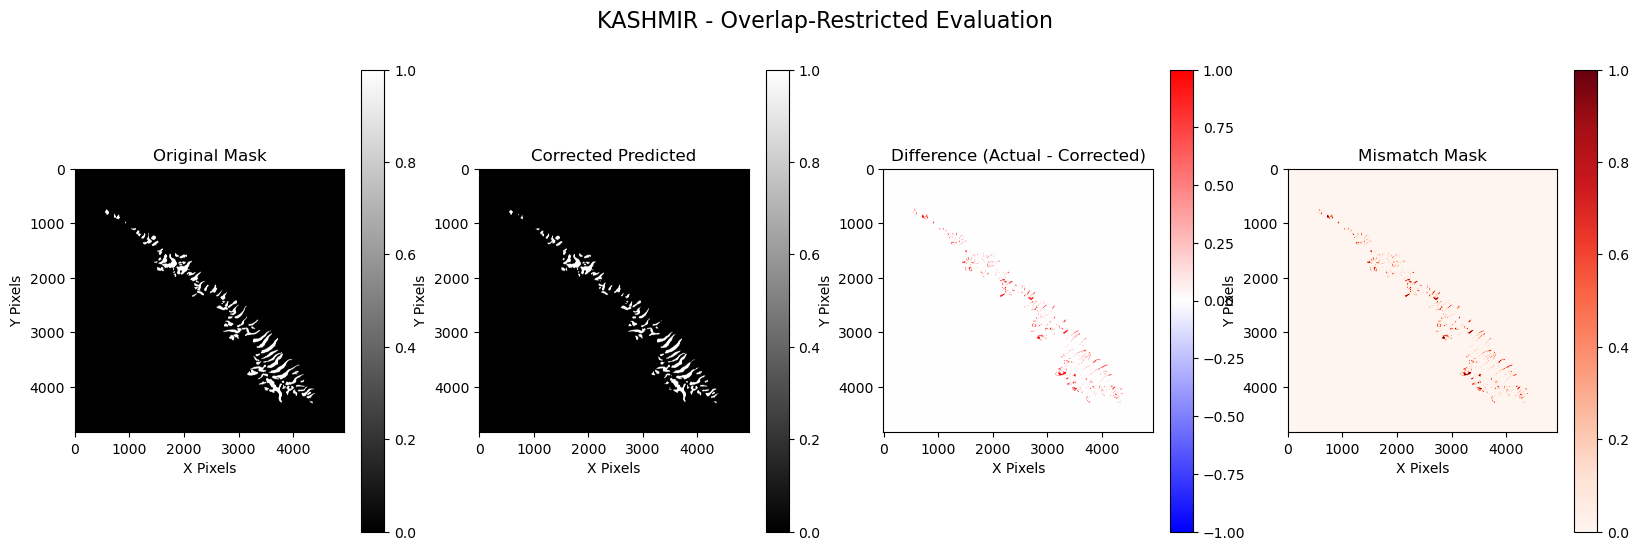

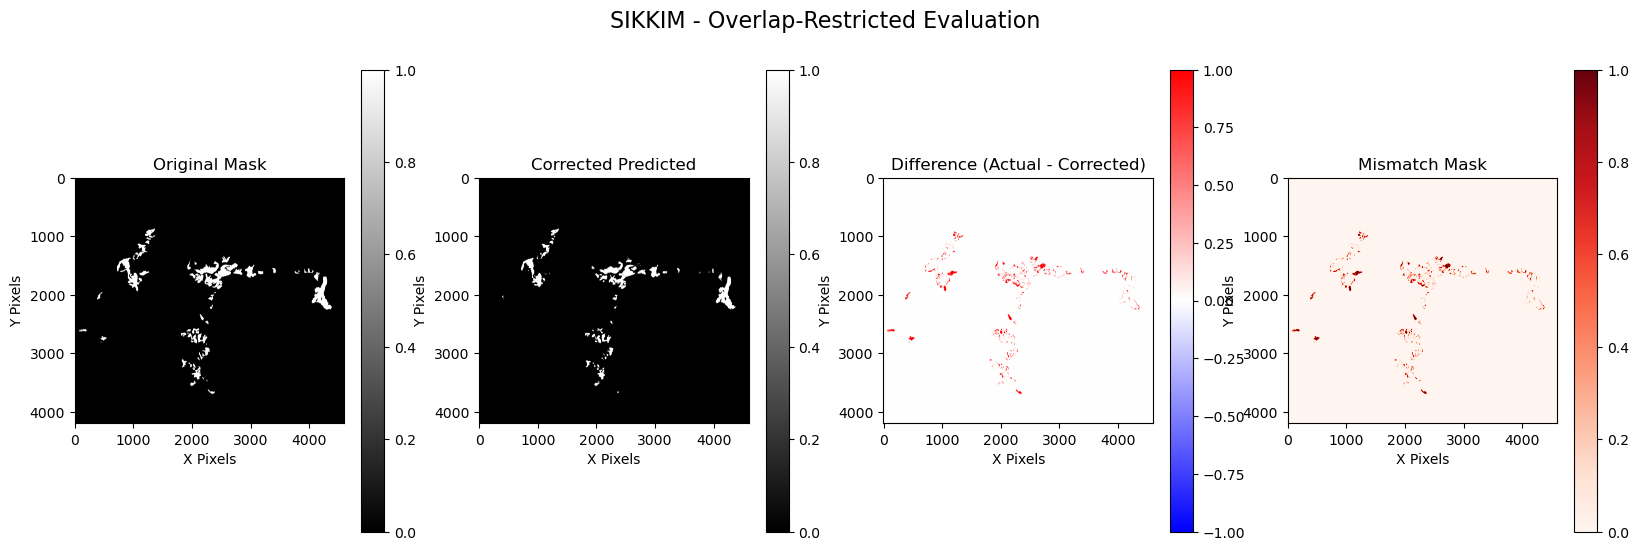

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/raster_cb__normalized_predicted_raster.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/cb_vali_normalized_128_predicted_raster.tif',
        'label': 'CB VALIDATION'
    },
    {
        'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/NEW_UK_TIF_fixedB10_predicted_raster.tif',
        'label': 'uk'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/KASHMIR_NORMALIZED_255_final_predicted_raster.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/sf_18/sikkim_chaudhary_255_final_predicted_raster.tif',
        'label': 'SIKKIM'
    },
]

for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load actual mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted to match ground truth mask
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # === Key step: Remove predictions outside actual mask ===
    # Wherever actual mask is 0, predicted should be set to 0
    corrected_predicted = resampled_predicted.copy()
    corrected_predicted[original_mask == 0] = 0

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    corrected_predicted_valid = corrected_predicted[valid_mask]

    # === Accuracy metrics ===
    conf_matrix = confusion_matrix(original_mask_valid, corrected_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, corrected_predicted_valid)
    iou = jaccard_score(original_mask_valid, corrected_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, corrected_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, corrected_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, corrected_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, corrected_predicted_valid)

    # Print results
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # === Visualization ===
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Overlap-Restricted Evaluation", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])

    # Corrected Prediction
    im1 = axes[1].imshow(corrected_predicted, cmap='gray')
    axes[1].set_title("Corrected Predicted")
    plt.colorbar(im1, ax=axes[1])

    # Difference
    diff = original_mask.astype(int) - corrected_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Actual - Corrected)")
    plt.colorbar(im2, ax=axes[2])

    # Mismatch
    mismatch = (original_mask != corrected_predicted).astype(int)
    im3 = axes[3].imshow(mismatch, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

plt.show()


=== Processing Chandra Bhaga basin ===
Confusion Matrix:
[[95356225        0]
 [ 1713431 10281174]]
Overall Accuracy: 0.9840
Mean IoU: 0.9197
F1 Score: 0.9571
Recall: 0.9286
Precision: 0.9912
Cohen's Kappa: 0.9142

=== Processing Miyer Valley region ===
Confusion Matrix:
[[20395538        0]
 [  908565  1627561]]
Overall Accuracy: 0.9604
Mean IoU: 0.7996
F1 Score: 0.8800
Recall: 0.8209
Precision: 0.9787
Cohen's Kappa: 0.7611

=== Processing Alaknanda and Bhagirathi basin ===
Confusion Matrix:
[[13713712        0]
 [  753090  4273933]]
Overall Accuracy: 0.9598
Mean IoU: 0.8991
F1 Score: 0.9462
Recall: 0.9251
Precision: 0.9740
Cohen's Kappa: 0.8925

=== Processing Pangong Region ===
Confusion Matrix:
[[23263577        0]
 [   79058   537325]]
Overall Accuracy: 0.9967
Mean IoU: 0.9342
F1 Score: 0.9649
Recall: 0.9359
Precision: 0.9983
Cohen's Kappa: 0.9298

=== Processing Chhombo Chhu Watershed ===
Confusion Matrix:
[[18780051        0]
 [  131523   372438]]
Overall Accuracy: 0.9932
Mean 

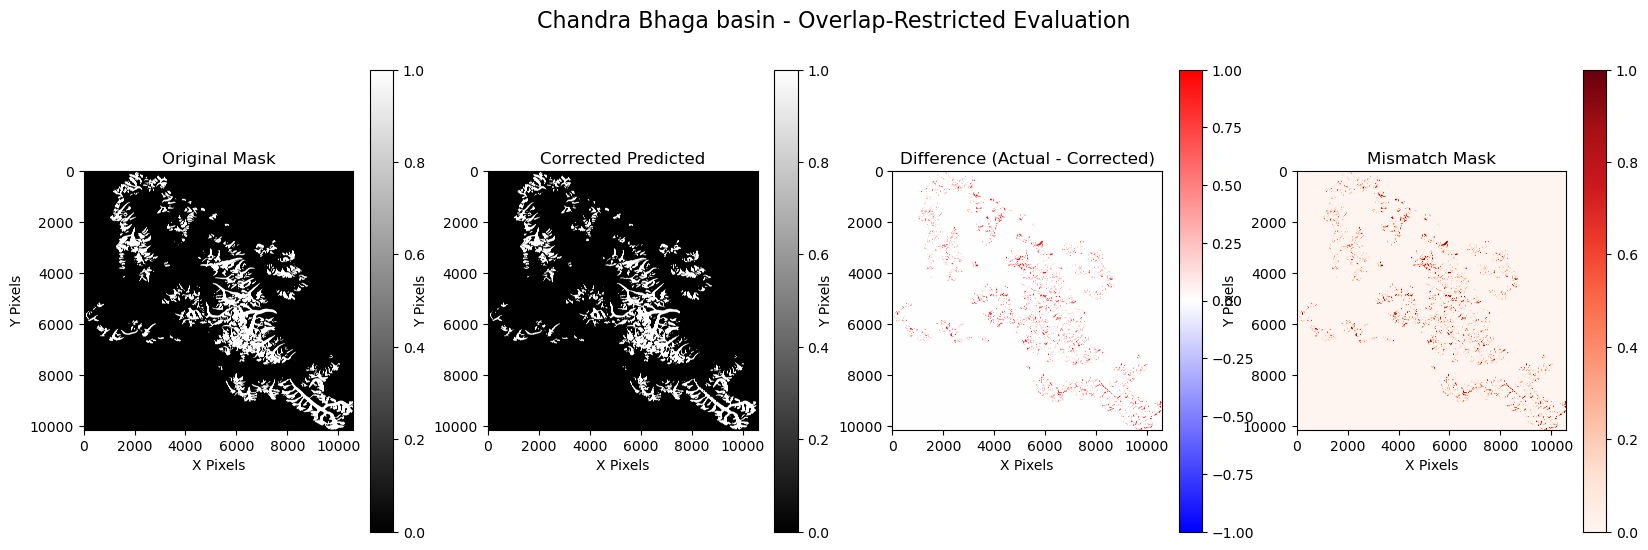

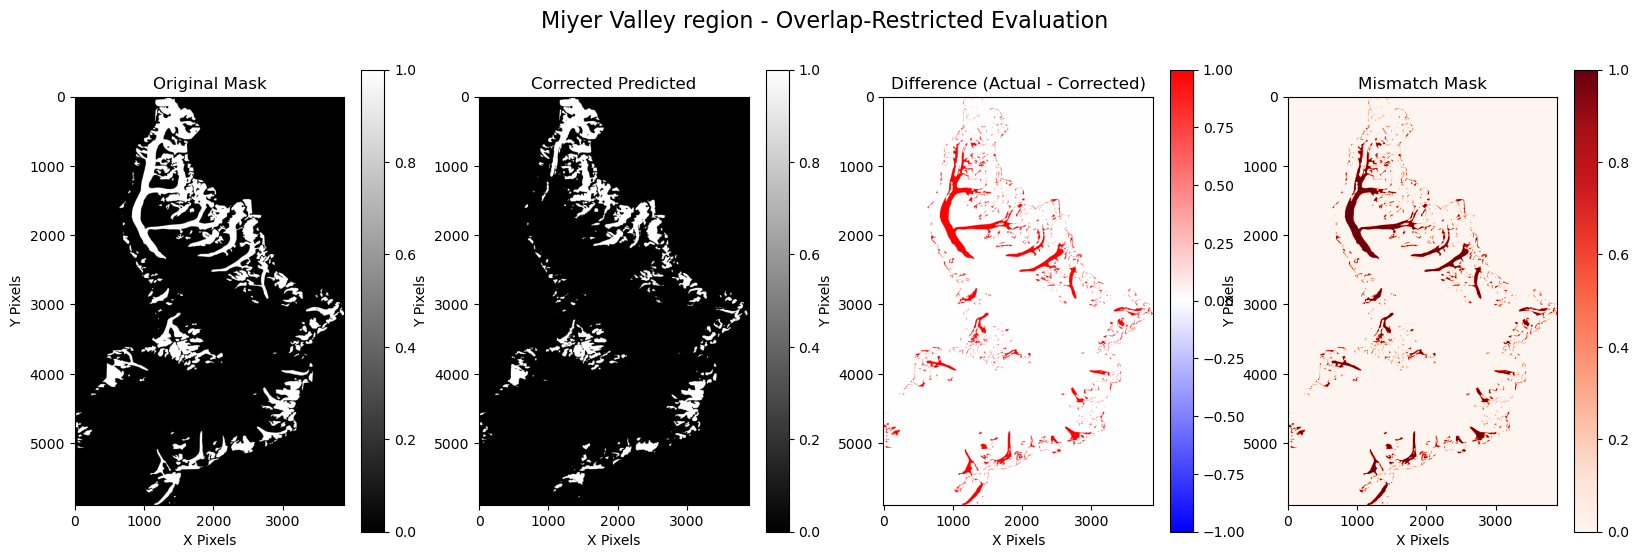

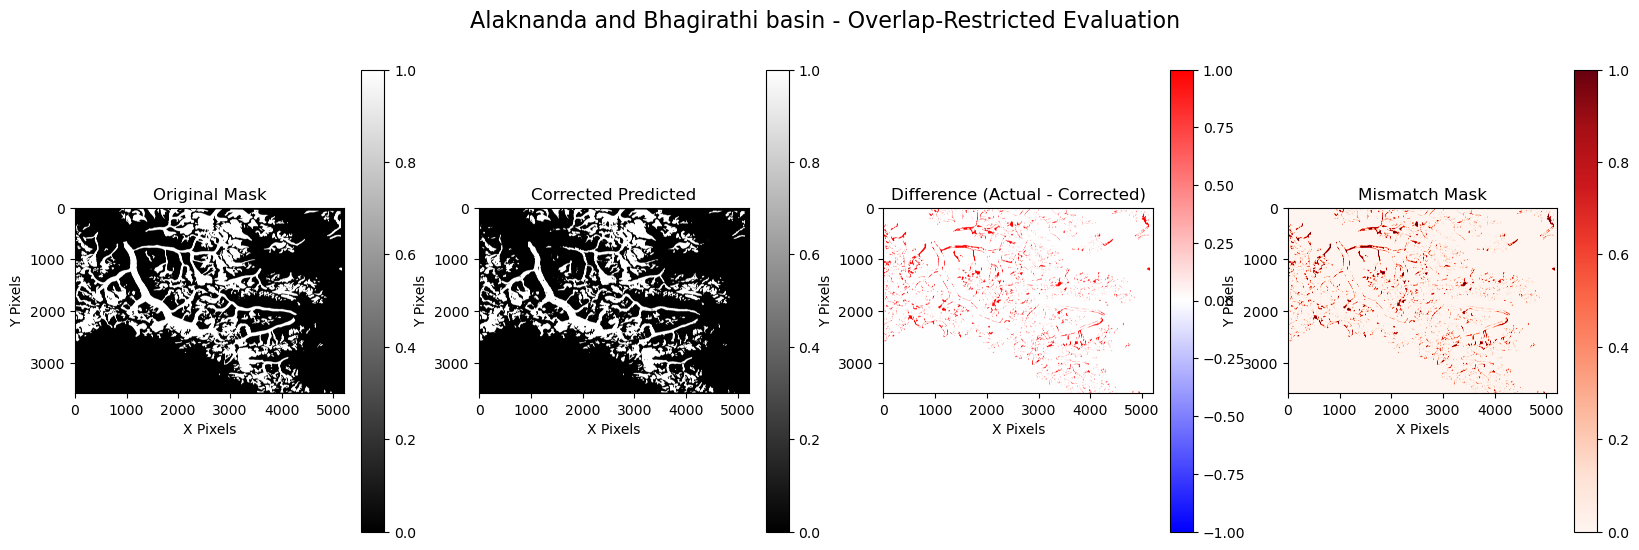

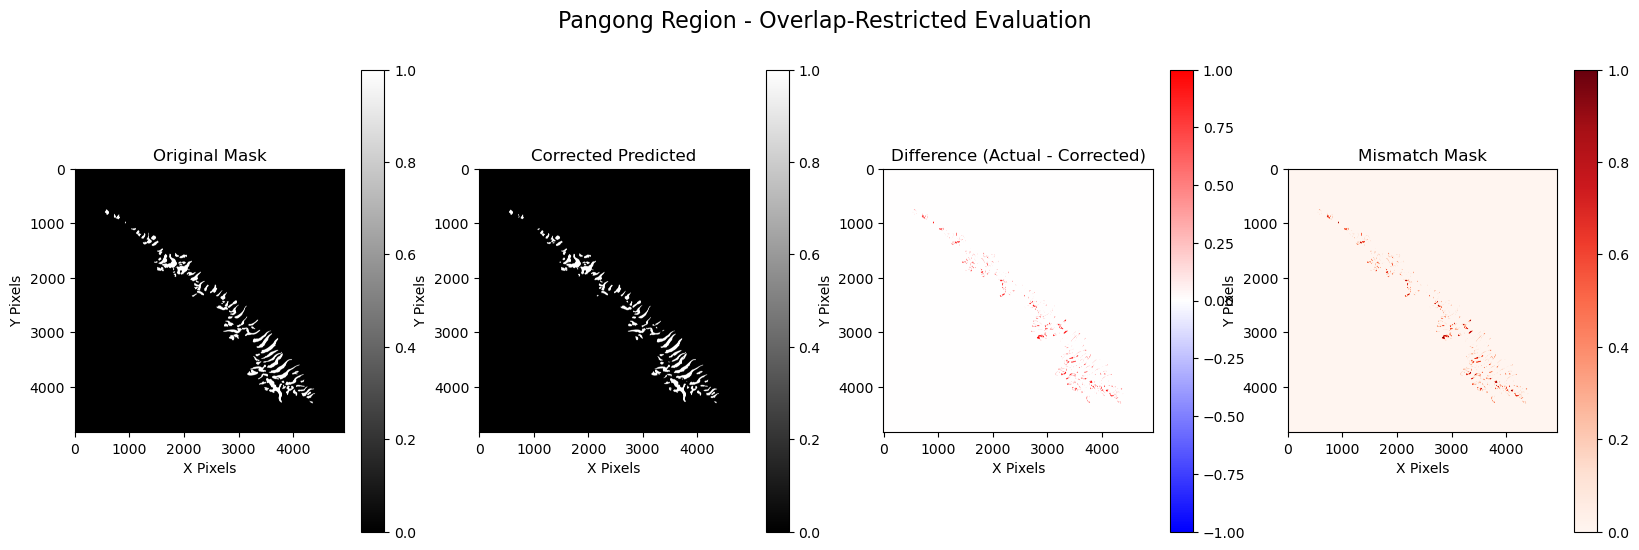

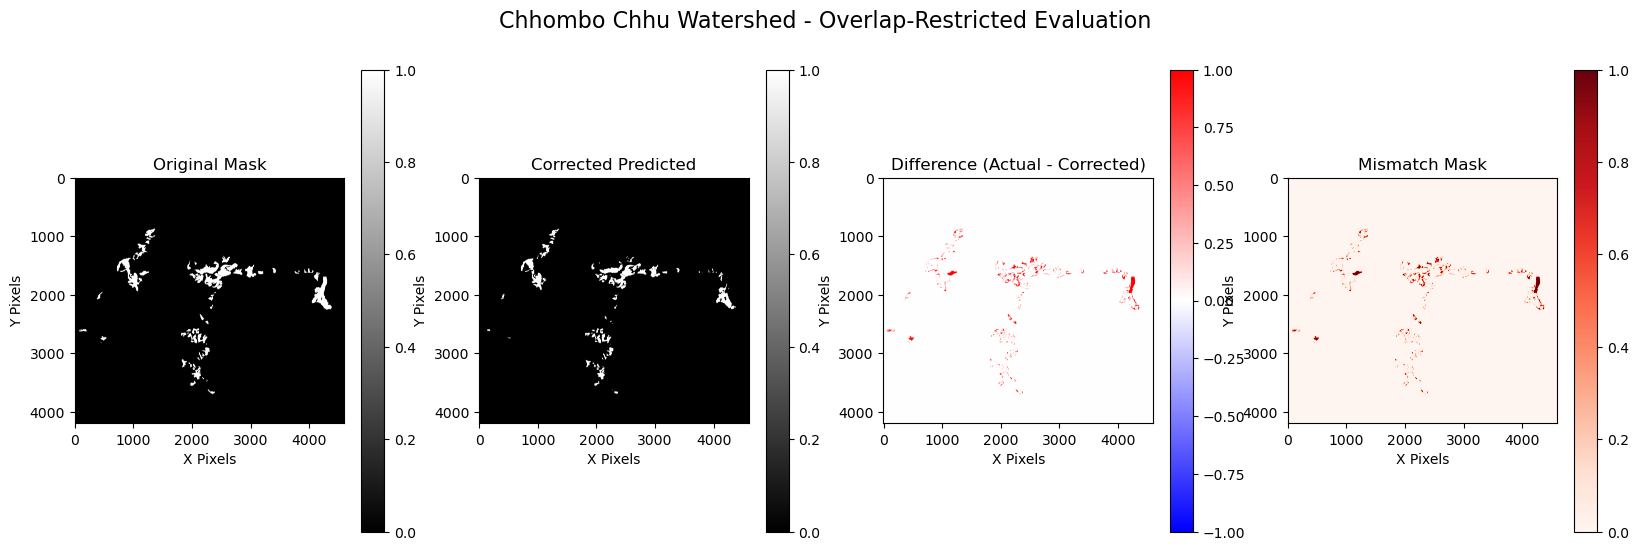

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/raster_cb__normalized_6band_predicted_raster.tif',
        'label': 'Chandra Bhaga basin'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/cb_vali_normalized_128_6band_predicted_raster.tif',
        'label': 'Miyer Valley region'
    },
    {
        'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/NEW_UK_TIF_fixedB10_6band_predicted_raster.tif',
        'label': 'Alaknanda and Bhagirathi basin'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/KASHMIR_NORMALIZED_255_final_6band_predicted_raster.tif',
        'label': 'Pangong Region'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/mlandsnet_sato_new/top_6/sf/sikkim_chaudhary_255_final_6band_predicted_raster.tif',
        'label': 'Chhombo Chhu Watershed'
    },
]

for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load actual mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted to match ground truth mask
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # === Key step: Remove predictions outside actual mask ===
    # Wherever actual mask is 0, predicted should be set to 0
    corrected_predicted = resampled_predicted.copy()
    corrected_predicted[original_mask == 0] = 0

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    corrected_predicted_valid = corrected_predicted[valid_mask]

    # === Accuracy metrics ===
    conf_matrix = confusion_matrix(original_mask_valid, corrected_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, corrected_predicted_valid)
    iou = jaccard_score(original_mask_valid, corrected_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, corrected_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, corrected_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, corrected_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, corrected_predicted_valid)

    # Print results
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # === Visualization ===
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Overlap-Restricted Evaluation", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])

    # Corrected Prediction
    im1 = axes[1].imshow(corrected_predicted, cmap='gray')
    axes[1].set_title("Corrected Predicted")
    plt.colorbar(im1, ax=axes[1])

    # Difference
    diff = original_mask.astype(int) - corrected_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Actual - Corrected)")
    plt.colorbar(im2, ax=axes[2])

    # Mismatch
    mismatch = (original_mask != corrected_predicted).astype(int)
    im3 = axes[3].imshow(mismatch, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

plt.show()